# Analysis of M66 (NGC 3627) with JWST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os, sys, glob, shutil

from astroquery.mast import Observations
from astropy.io import fits

from XRBID.AutoPhots import RunPhots, DaoFindObjects
from XRBID.WriteScript import (WriteReg, WriteDS9,
                              WriteScalings)
from XRBID.Sources import (LoadSources, GetCoords, GetIDs,
                           DaoClean, Crossref, GetDaoPhots)
from XRBID.DataFrameMod import (RemoveElse, FindUnique, BuildFrame,
                                Find)
from XRBID.Align import CorrectAstrometry, CalcPU
from XRBID.CMDs import MakeCMD, FitSED, PlotSED
from XRBID.XRTools import Lum, FindSNRs

import seaborn as sns
sys.path.insert(0, '/Users/undergradstudent/Research/XRB-Analysis/Notebooks')
from helpers.analysis import remove_unnamed, calculate_distance, calculate_velocity

# define directories to handle data in
cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandra_hst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/"
chandra_jwst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"
M66_dir = '/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/'

# jwst directories
f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

# hst directories
f275w = hstdir+"M66_mosaic_uvis_f275w_drc_sci.fits"
f336w = hstdir+"M66_mosaic_uvis_f336w_drc_sci.fits"
f438w = hstdir+"M66_mosaic_uvis_f438w_drc_sci.fits"
f555w = hstdir+"M66_mosaic_uvis_f555w_drc_sci.fits"
f814w = hstdir+"M66_mosaic_uvis_f814w_drc_sci.fits"

## Notes

**IMP**
- I initially used the 2sig found through the JWST analysis, but since the HST 2sig is bigger, I will be using that for my analysis. For that reason, I am reruning and doing a lot of the stuff again!

**Photometry**: <br>
- links for [conversion](https://jwst-docs.stsci.edu/jwst-near-infrared-camera#gsc.tab=0) and [filters](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-filters#gsc.tab=0).
- short wavelength pix conversion = 0.031''/pixel
- long wavelength pix conversion = 0.063''/pixel

**Infrared Object identification**
- I found SNRs in M66 which I should take a look at while doing the infrared object identifcation. They can be found on the wikipedia page for M66. 

**JWST**
- Found encircled energy fractions from [here](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-point-spread-functions#NIRCamPointSpreadFunctions-Encircledenergy).
- Zeropoints can be found here : [zeropoints](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-absolute-flux-calibration-and-zeropoints)
- **Mass Estimation**: This is the notebook where the mass estimation was first tested with the jwst CMD and the `XRBID.CMDs.FitSED` function.

**Misc**
- Always keep in mind that coordinates are flipped in a fits image

## Querying JWST Data

In [ ]:
%%time

filters = ["F150W", "F200W", "F150W", "F277W", "F444W"
           "F300M", "F335M", "F360M",
           "F187N", "F212N"]
proposal_id = [2107, 4793]
print("Finding observations for JWST images...")
obs_table = Observations.query_criteria(objectname="M66", obs_collection="JWST",
                                        filters=filters, proposal_id=proposal_id,
                                        instrument_name="NIRCAM/IMAGE")
print("Done")

Finding observations for JWST images...


In [5]:
obs_table

<Table masked=True length=8>
intentType obs_collection provenance_name ...   objID     objID1  distance
   str7         str4            str7      ...    str9      str9   float64 
---------- -------------- --------------- ... --------- --------- --------
   science           JWST         CALJWST ... 793836430 793836430      0.0
   science           JWST         CALJWST ... 747060856 747060856      0.0
   science           JWST         CALJWST ... 747060759 747060759      0.0
   science           JWST         CALJWST ... 793836338 793836338      0.0
   science           JWST         CALJWST ... 793836322 793836322      0.0
   science           JWST         CALJWST ... 793836405 793836405      0.0
   science           JWST         CALJWST ... 793836379 793836379      0.0
   science           JWST         CALJWST ... 747060796 747060796      0.0

In [6]:
# The code is downloading many extra files that are not needed. 
print("Downloading data.\n This may take several minutes... \n")
products = Observations.get_product_list(obs_table)

data_prod = ['I2D']       # other options are ['FLT','DRC','DRZ']
data_type = ['CALJWST']   # other options are ['CALACS','CALWF3','CALWP2']

Observations.download_products(products, project=data_type, 
                               productSubGroupDescription=data_prod)
print("Done")

 This may take several minutes... 



<Table masked=True length=33160>
  obsID   obs_collection dataproduct_type ... dataRights calib_level filters
   str9        str4            str5       ...    str6       int64      str5 
--------- -------------- ---------------- ... ---------- ----------- -------
109081772           JWST            image ...     PUBLIC           1   F200W
109081772           JWST            image ...     PUBLIC           1   F200W
109081772           JWST            image ...     PUBLIC           2   F200W
109081772           JWST            image ...     PUBLIC           1   F200W
109081772           JWST            image ...     PUBLIC           1   F200W
109081772           JWST            image ...     PUBLIC           2   F200W
109081772           JWST            image ...     PUBLIC           1   F200W
109081772           JWST            image ...     PUBLIC           1   F200W
109081772           JWST            image ...     PUBLIC           1   F200W
      ...            ...              ... ...        ...         ...     ...
234445657           JWST            image ...     PUBLIC           2   F187N
234445657           JWST            image ...     PUBLIC           2   F187N
234445657           JWST            image ...     PUBLIC           2   F187N
234445657           JWST            image ...     PUBLIC           2   F187N
234445657           JWST            image ...     PUBLIC           2   F187N
234445657           JWST            image ...     PUBLIC           2   F187N
234445657           JWST            image ...     PUBLIC           2   F187N
234445657           JWST            image ...     PUBLIC           2   F187N
234445657           JWST            image ...     PUBLIC           2   F187N
234445657           JWST            image ...     PUBLIC           1   F187N

Since the above code is downloading additional files that are not required, I am manually downloading data from this [link](https://archive.stsci.edu/hlsp/phangs.html#hst_image_products_table) for M66. 

The filters that I am using are: 360m, 335m, 300m, 200w

# Photometry

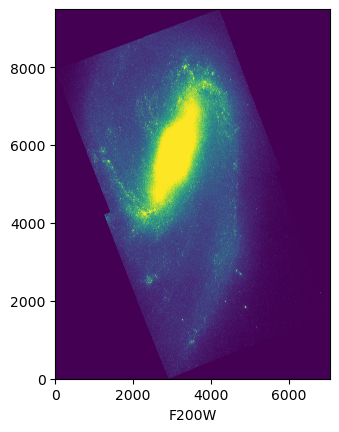

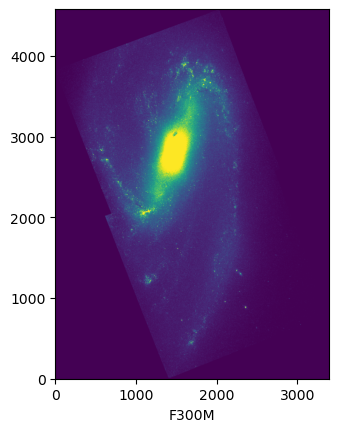

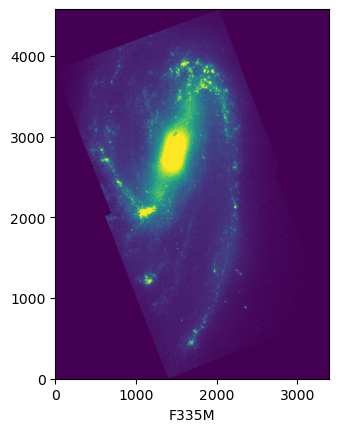

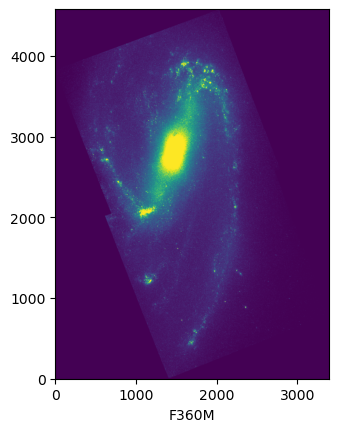

In [73]:
# just to see how the images look like
images = {
          "F200W" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits",
          "F300M" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits",
          "F335M" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits",
          "F360M" : jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"
}

for filter in images:
    hdu = fits.open(images[filter])
    data = hdu['sci'].data
    plt.imshow(data, origin='lower', vmin=0, vmax=10)
    plt.xlabel(filter)
    plt.show()

# def create_images(images, nrows, ncols, vmin, vmax):
#     ax, fig = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4,6))

#     for i, filter in enumerate(images):
#         hdu_image[i] = fits.getdata(images[filter])
#         ax[i].imshow(hdu_image, vmin=vmin, vmax=vmax)
#         ax[i].xlabel(images[filter])
#         plt.show

# create_images(images, nrows=2, ncols=2, vmin=0, vmax=10)

## JWST

### F200W

In [ ]:
find_stars(size=,
            sensitivity=)

0.14


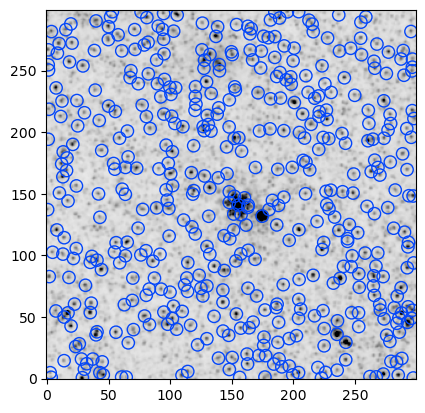

In [2]:
# I am satisfied with this configuration.

data = fits.getdata(f200w)
data = data[3200:3500, 3000:3300]
pixtoarcs = 0.031 # arcseconds for JWST Nircam short wavelength filters
fwhm = 0.14
print(fwhm)
objects = DaoFindObjects(data, fwhm=fwhm, pixtoarcs=pixtoarcs, plot=True, vmax=10)

In [2]:
cd(jwstdir)

In [ ]:
hdu_f200w = fits.open(f200w)
zeropoint = np.mean([25.55, 25.56, 25.60, 25.66])
apcorr, apcorr_err, apcorr_ext, aperr_ext = RunPhots(hdu_f200w, gal='M66', instrument='NIRCAM', filter='F200W',
                                                     fwhm_arcs=0.14, zeropoint=zeropoint, reg_correction=[0,1],
                                                     suffix='_test1', extended_rad=5)
hdu_f200w.close()

In [68]:
apcorr, apcorr_err, apcorr_ext, aperr_ext

((np.float64(-0.9432533390429116),),
 np.float64(0.22063308967907644),
 np.float64(-0.6547372320991942),
 np.float64(0.183335676482875))

### F300M - long filter

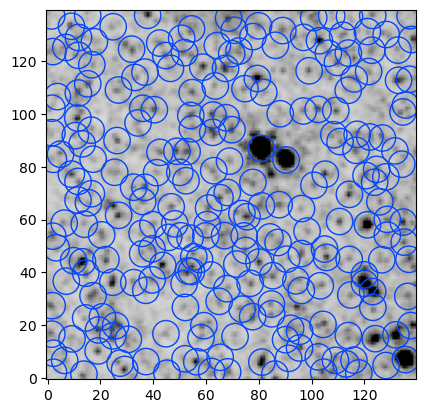

In [9]:
data = fits.getdata(f300m)
data = data[1530:1670, 1430:1570]
pixtoarcs = 0.063 # arcseconds for JWST Nircam long wavelength filters
fwhm = 0.3
objects = DaoFindObjects(data, fwhm=fwhm, threshold=2, pixtoarcs=pixtoarcs, plot=True, vmax=3.5)

In [10]:
instrument_info(f300m)

Instrument: NIRCAM 
Detector: NRCBLONG 
Module: B 
Channel: LONG 
Filter: F300M 
Pupil: CLEAR


In [ ]:
hdu = fits.open(f300m)
zeropoint = 24.04
# Test 1: I like the image coordinates that this output gives
apcorr, aperr, apcorr_ext, aperr_ext = RunPhots(hdu, gal='M66', instrument='NIRCAM', filter='F300M',
                                               fwhm_arcs=0.3, threshold=2, zeropoint=zeropoint,
                                               reg_correction=[1,1], extended_rad=5)

In [30]:
apcorr, aperr, apcorr_ext, aperr_ext

((np.float64(-0.78481712836287),),
 np.float64(0.306933205838483),
 np.float64(-0.5282181244768287),
 np.float64(0.2260012288120479))

1. CorrectAp: suffix parameter
2. Unitsfor photometry in RunPhots
3. small errors: 0.2 and 0.15 are good!
4. M101, M83 and M81 - I can do jwst analysis next!
5. SNR
6. strict moment 6

### F335M - long filter
Date: 23 May 2025

In [88]:
instrument_info(f335m)

Instrument: NIRCAM 
Detector: NRCBLONG 
Module: B 
Channel: LONG 
Filter: F335M 
Pupil: CLEAR


In [ ]:
hdu = fits.open(f335m)
zeropoint = 23.95

apcorr, aperr, apcorr_ext, aperr_ext = RunPhots(hdu, gal='M66', instrument='NIRCAM', filter='F335M',
                                               fwhm_arcs=0.3, threshold=2, zeropoint=zeropoint,
                                               reg_correction=[1,1], extended_rad=5, suffix='_test1')

In [ ]:
apcorr, aperr, apcorr_ext, aperr_ext

((np.float64(-0.9755221853576381),),
 np.float64(0.37631401061577546),
 np.float64(-0.6818044171522375),
 np.float64(0.2791374036787237))

### F360M - long filter

In [49]:
instrument_info(f360m)

Instrument: NIRCAM 
Detector: NRCBLONG 
Module: B 
Channel: LONG 
Filter: F360M 
Pupil: CLEAR


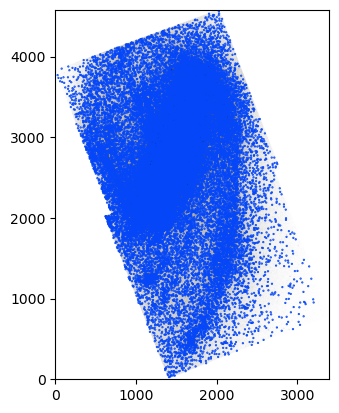

31982

In [47]:
data = fits.getdata(f360m)
# data = data[1550:1670, 1450:1660]
pixtoarcs = 0.063 # arcseconds for JWST Nircam long wavelength filters
objects = DaoFindObjects(data, fwhm=0.3, threshold=2, pixtoarcs=pixtoarcs, plot=True, vmax=3.5)
len(objects)

In [ ]:
hdu_f360m = fits.open(f360m)
zeropoint = 23.77
apcorr, aperr, apcorr_ext, aperr_ext = RunPhots(hdu_f360m, gal='M66', instrument='NIRCAM', filter='F360M',
                                               fwhm_arcs=0.3, threshold=2, zeropoint=zeropoint,
                                               reg_correction=[1,1], extended_rad=5, suffix='_test1')

In [55]:
apcorr, aperr, apcorr_ext, aperr_ext

((np.float64(-0.8656525139120455),),
 np.float64(0.28681072980075817),
 np.float64(-0.6430972067239484),
 np.float64(0.2291155826238405))

## HST

### F814W

In [94]:
f814w

'/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST/M66_mosaic_uvis_f814w_drc_sci.fits'

In [ ]:
f814w_data = fits.getdata(f814w)
f814w_data_sliced = f814w_data[3400:3700, 4400:4700]
pixtoarcs = 0.03962
f814w_objects = DaoFindObjects(f814w_data_sliced, fwhm=0.10*2, pixtoarcs=pixtoarcs, threshold=2, plot=True)

# investigating the daofind sources and extracting their photometry
f814w_hdu = fits.open(f814w)
apcorr, aperr, apcorr_ext, aperr_ext = RunPhots(f814w_hdu, gal="M66", instrument="WFC3",
                                               filter='F814W', fwhm_arcs=0.10*2, threshold=2,
                                               num_stars=20, extended_rad=8, reg_correction=[1,1])
f814w_hdu.close()

In [3]:
apcorr, aperr, apcorr_ext, aperr_ext

((np.float64(-0.8588325849729528),),
 np.float64(0.1807607521654574),
 np.float64(-0.3719457463759386),
 np.float64(0.10642947110641915))

### F555W

In [ ]:
f555w_data = fits.getdata(f555w)
f555w_data_sliced = f555w_data[3400:3700, 4400:4700]
pixtoarcs = 0.03962
fwhm = 0.18 * 2 # originally found 0.18 arcsec through ds9
f555w_objects = DaoFindObjects(f555w_data_sliced, fwhm=fwhm, pixtoarcs=pixtoarcs,
                               threshold=2, plot=True)

#investigating the daofind sources and extracting their photometry
f555w_hdu = fits.open(f555w)
apcorr555w, aperr555w, apcorr_ext555w, aperr_ext555w = RunPhots(f555w_hdu, gal="M66", instrument="WFC3",
                                               filter='F555W', fwhm_arcs=fwhm, threshold=2,
                                               num_stars=20, extended_rad=8, reg_correction=[1,1])
f555w_hdu.close()

In [11]:
apcorr555w, aperr555w, apcorr_ext555w, aperr_ext555w

((np.float64(-0.8814290765714752),),
 np.float64(0.24055442323969883),
 np.float64(-0.3472747023393392),
 np.float64(0.12601848622183956))

### F438W

In [ ]:
f438w_data = fits.getdata(f438w)
f438w_data_sliced = f438w_data[3400:3700, 4400:4700]
pixtoarcs = 0.03962
fwhm = 0.11 * 2 # originally found 0.18 arcsec through ds9
f438w_objects = DaoFindObjects(f438w_data_sliced, fwhm=fwhm, pixtoarcs=pixtoarcs,
                               threshold=2, plot=True, vmax=0.09)
print(len(f438w_objects)) # found with 195 sources fwhm=0.10

#investigating the daofind sources and extracting their photometry
f438w_hdu = fits.open(f438w)
apcorr438w, aperr438w, apcorr_ext438w, aperr_ext438w = RunPhots(f438w_hdu, gal="M66", instrument="WFC3",
                                               filter='F438W', fwhm_arcs=fwhm, threshold=2,
                                               num_stars=20, extended_rad=8, reg_correction=[1,1])
f438w_hdu.close()

In [45]:
apcorr438w, aperr438w, apcorr_ext438w, aperr_ext438w

((np.float64(-0.9175731144364969),),
 np.float64(0.2291917542835823),
 np.float64(-0.4745254777532202),
 np.float64(0.15543813531799572))

### F336W

In [ ]:
f336w_data = fits.getdata(f336w)
f336w_data_sliced = f336w_data[3400:3700, 4400:4700]
pixtoarcs = 0.03962
fwhm = 0.12 * 2 # originally found 0.18 arcsec through ds9
f336w_objects = DaoFindObjects(f336w_data_sliced, fwhm=fwhm, pixtoarcs=pixtoarcs,
                               threshold=2, plot=True, vmax=0.05)
print(len(f336w_objects)) # found with 195 sources fwhm=0.10

# investigating the daofind sources and extracting their photometry
f336w_hdu = fits.open(f336w)
apcorr336w, aperr336w, apcorr_ext336w, aperr_ext336w = RunPhots(f336w_hdu, gal="M66", instrument="WFC3",
                                               filter='F336W', fwhm_arcs=fwhm, threshold=2,
                                               num_stars=20, extended_rad=8, reg_correction=[1,1])
f336w_hdu.close()

In [60]:
apcorr336w, aperr336w, apcorr_ext336w, aperr_ext336w 

((np.float64(-0.9540754478692428),),
 np.float64(0.23448030394882666),
 np.float64(-0.43512525755218445),
 np.float64(0.13649683194194648))

### F275W

In [ ]:
f275w_data = fits.getdata(f275w)
f275w_data_sliced = f275w_data[4400:5000, 4300:4900]
pixtoarcs = 0.03962
fwhm = 0.12 * 2 # originally found 0.18 arcsec through ds9
f275w_objects = DaoFindObjects(f275w_data_sliced, fwhm=fwhm, pixtoarcs=pixtoarcs,
                               threshold=2, plot=True, vmax=0.015)
print(len(f275w_objects)) # found with 195 sources fwhm=0.10

#investigating the daofind sources and extracting their photometry
f275w_hdu = fits.open(f275w)
apcorr275w, aperr275w, apcorr_ext275w, aperr_ext275w = RunPhots(f275w_hdu, gal="M66", instrument="WFC3",
                                               filter='F275W', fwhm_arcs=fwhm, threshold=2,
                                               num_stars=20, extended_rad=8, reg_correction=[1,1])
f275w_hdu.close()

In [66]:
apcorr275w, aperr275w, apcorr_ext275w, aperr_ext275w

((np.float64(-0.9707309801124901),),
 np.float64(0.25887846989477437),
 np.float64(-0.4419304737417187),
 np.float64(0.1511766174865048))

# Astrometric Corrections

This section can entirely be ignored as I did not end up performing any astrometric corrections. Additionally, the portion on the 2 sig positional uncertainty is not useful either as I ended up using the 2 sig positional uncertainty of HST instead.

# Identifying Optical Counterparts to X-ray Sources

## Isolating Candidate Counterparts with    `DaoClean`

In [3]:
x,y = GetCoords(jwstdir+"M66_daofind_f200w_nircam_img.reg")
ids = GetIDs(jwstdir+"M66_daofind_f200w_nircam_img.reg")
ra,dec = GetCoords(jwstdir+"M66_daofind_f200w_nircam_fk5.reg")

# # # Compiling into a single DataFrame
DaoFrame = BuildFrame(headers=['DaoID','X','Y','RA','Dec'], 
                      values=[ids,x,y,ra,dec])
                      
display(DaoFrame)
DaoFrame.to_csv(jwstdir+"M66_daofind_nircam_coords.frame")

Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/M66_daofind_f200w_nircam_img.reg
Retrieving IDs from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/M66_daofind_f200w_nircam_img.reg
Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/M66_daofind_f200w_nircam_fk5.reg


DaoID            X            Y          RA        Dec
0            1  2924.060015    17.233289  170.063905  12.942310
1            2  2935.948938    16.743024  170.063801  12.942306
2            3  2940.043395    24.122714  170.063765  12.942369
3            4  2913.002787    24.673854  170.064002  12.942374
4            5  2928.996433    27.917984  170.063862  12.942402
...        ...          ...          ...         ...        ...
338489  338490  4209.310007  9462.788748  170.052636  13.022988
338490  338491  4182.418343  9464.476210  170.052871  13.023002
338491  338492  4217.247604  9468.846438  170.052566  13.023040
338492  338493  4190.522509  9471.099783  170.052800  13.023059
338493  338494  4210.284675  9475.132469  170.052627  13.023093

[338494 rows x 5 columns]

**Important Note**

I am incorporating the 2 sigma radius into my jwst work. 

In [4]:
# The dataFrame that I am using for the HST analysis
# This is being incorporated since I want to use 
# the 2sig of HST images for my analysis
M66_best = LoadSources(chandra_hst_dir+'M66_csc_bestrads.frame')

xsources, ysources = GetCoords(chandra_jwst_dir+'M66_bestrads_2sig_img.reg')

# The dataframe still has the original x and y coordinates in the JWST image
M66_best['X'] = xsources
M66_best['Y'] = ysources

# using the HST 2 sig
M66_best['2Sig (pix)'] = M66_best['2Sig'] / 0.03962   # Use the conversion rate of HST WFC3

# M66_best.to_csv(chandra_jwst_dir+'M66_csc_bestrads.frame')

display(M66_best)

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_csc_bestrads.frame...
Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_bestrads_2sig_img.reg


Unnamed: 0.1  Separation                  CSC ID          RA        Dec  \
0              0    0.603512   2CXO J112014.9+125929  170.062428  12.991495   
1              1    1.154310   2CXO J112015.0+125928  170.062878  12.991329   
2              2    4.249587   2CXO J112014.9+125933  170.062259  12.992633   
3              3    4.484088  2CXO J112015.2+125932X  170.063665  12.992189   
4              4    5.940189   2CXO J112015.3+125932  170.064119  12.992230   
..           ...         ...                     ...         ...        ...   
83            83  231.679093   2CXO J112030.5+130013  170.127457  13.003663   
84            84  237.496980   2CXO J112008.5+130307  170.035399  13.051914   
85            85  240.218881   2CXO J112019.6+130320  170.081736  13.055570   
86            86  246.797558   2CXO J112027.8+125649  170.116113  12.946999   
87            87  249.864798   2CXO J112025.4+130247  170.106001  13.046538   

    Err Ellipse Major  Err Ellipse Minor  Err Ellipse Angle  Significance  \
0            0.311932           0.311917           0.000000      9.567092   
1            0.317501           0.317501           0.000000      7.701153   
2            0.299684           0.298357           5.587902     12.795398   
3            3.446421           3.446421           0.000000     39.744111   
4            0.413187           0.343140          64.093176      5.142857   
..                ...                ...                ...           ...   
83           1.402157           0.820192           1.489236      3.575758   
84           0.774353           0.647498         139.851620      4.000000   
85           0.563631           0.427724         157.623228     10.427182   
86           1.754478           1.143646          33.705932      3.294118   
87           1.073411           0.672588         169.752370      4.324324   

   Likelihood  ... Counts hilim      1Sig      2Sig           X            Y  \
0        TRUE  ...   191.109641  0.115174  0.238746  3092.46810   5775.61640   
1        TRUE  ...   142.201784  0.118283  0.248443  3041.08760   5756.21730   
2        TRUE  ...   244.566017  0.113925  0.235415  3111.69780   5908.85640   
3        TRUE  ...  3427.710381  1.725878  3.451755  2951.33130   5856.84300   
4        TRUE  ...    46.639197  0.154105  0.345133  2899.58940   5861.66790   
..        ...  ...          ...       ...       ...         ...          ...   
83       TRUE  ...    23.316527  0.439176  1.071654 -4325.77070   7200.90170   
84       TRUE  ...    30.526982  0.423189  1.022475  6174.97000  12849.63500   
85       TRUE  ...   164.908744  0.194439  0.404728   890.15421  13277.38300   
86       TRUE  ...    22.727118  0.436688  1.067144 -3032.91700    566.64695   
87       TRUE  ...    34.482532  0.415924  1.000030 -1877.49020  12220.25200   

    2Sig (pix)      ID  Bounds      LogLx  (SNR)  
0     6.025886  CXO001      In  38.449069      0  
1     6.270647  CXO002      In  38.442754      0  
2     5.941826  CXO003      In  38.566181      0  
3    87.121537  CXO004      In        NaN      0  
4     8.711076  CXO005      In  37.911504      0  
..         ...     ...     ...        ...    ...  
83   27.048301  CXO084     Out  37.571116      0  
84   25.807047  CXO085     Out  37.855388      0  
85   10.215239  CXO086     Out  38.690923      0  
86   26.934484  CXO087     Out  37.533265      0  
87   25.240534  CXO088     Out  37.729994      0  

[88 rows x 39 columns]

In [5]:
# The wiggle room helped identify the cluster in the source 2CXO J112018.3+125900
DaoCleanFrame = DaoClean(daosources=DaoFrame, sources=M66_best, sourceid='CSC ID',
                         coordsys='fk5', coordheads=['RA', 'Dec'], radheader='2Sig',
                         wiggle=0.0000005)

DaoCleanFrame = DaoCleanFrame.rename(columns={'DaoID': 'F200W ID'})

display(DaoCleanFrame)

WriteReg(DaoCleanFrame, coordsys='fk5', width=2,
         outfile=chandra_jwst_dir+'M66_daoclean_f200w_nircam_fk5.reg',
         radius=0.1, radunit='arcsec',
         color='#9191E9')                 # Using a colorblind friendly color which does not seem very friendly

Cleaning DAOFind sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


F200W ID            X            Y          RA        Dec  \
0      186126  3095.278143  5769.996064  170.062403  12.991447   
1      186591  3098.298769  5777.274662  170.062377  12.991509   
2      184798  3043.030225  5749.281319  170.062861   12.99127   
3      185199  3035.930921  5754.396561  170.062923  12.991314   
4      185366  3042.938275  5757.419244  170.062862  12.991339   
...       ...          ...          ...         ...        ...   
1406    26276  4034.543404  2097.590954  170.054172  12.960079   
1407    26305  4021.687783   2099.17956  170.054284  12.960093   
1408    26519  4032.312552  2109.128343  170.054191  12.960178   
1409    26624  4024.074667  2114.406991  170.054263  12.960223   
1410    20630  2638.804107  1825.304918  170.066405  12.957754   

                     CSC ID  
0     2CXO J112014.9+125929  
1     2CXO J112014.9+125929  
2     2CXO J112015.0+125928  
3     2CXO J112015.0+125928  
4     2CXO J112015.0+125928  
...                     ...  
1406  2CXO J112013.0+125736  
1407  2CXO J112013.0+125736  
1408  2CXO J112013.0+125736  
1409  2CXO J112013.0+125736  
1410  2CXO J112015.9+125727  

[1411 rows x 6 columns]

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_daoclean_f200w_nircam_fk5.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_daoclean_f200w_nircam_fk5.reg saved!


In [6]:
cd(jwstdir)
regions = ['M66_daofind_f300m_nircam_fk5.reg',
           'M66_daofind_f335m_nircam_fk5.reg',
           'M66_daofind_f360m_nircam_fk5.reg']
DaoCleanMatch = Crossref(DaoCleanFrame, 
                         regions=regions, 
                         catalogs=['F300M', 'F335M', 'F360M'], coordheads=['RA','Dec'], coordsys='fk5',
                         sourceid="F200W ID", outfile=chandra_jwst_dir+"M66_daoclean_matches.frame",
                         search_radius=0.00005)

DaoCleanMatch

Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


RA        Dec  F200W ID F300M ID F335M ID F360M ID            X  \
0     170.062403  12.991447    186126    43256    39563      NaN  3095.278143   
1     170.062377  12.991509    186591    43256      NaN    45349  3098.298769   
2     170.062861  12.991270    184798    42915    39221    44861  3043.030225   
3     170.062923  12.991314    185199    42999    39292    44947  3035.930921   
4     170.062862  12.991339    185366    43115    39406    45067  3042.938275   
...          ...        ...       ...      ...      ...      ...          ...   
1486  170.054172  12.960079     26276      NaN      NaN      NaN  4034.543404   
1487  170.054284  12.960093     26305      NaN      NaN      NaN  4021.687783   
1488  170.054191  12.960178     26519     6497     5610     6873  4032.312552   
1489  170.054263  12.960223     26624      NaN     5634     6902  4024.074667   
1490  170.066405  12.957754     20630      NaN      NaN      NaN  2638.804107   

                Y                 CSC ID  
0     5769.996064  2CXO J112014.9+125929  
1     5777.274662  2CXO J112014.9+125929  
2     5749.281319  2CXO J112015.0+125928  
3     5754.396561  2CXO J112015.0+125928  
4     5757.419244  2CXO J112015.0+125928  
...           ...                    ...  
1486  2097.590954  2CXO J112013.0+125736  
1487  2099.179560  2CXO J112013.0+125736  
1488  2109.128343  2CXO J112013.0+125736  
1489  2114.406991  2CXO J112013.0+125736  
1490  1825.304918  2CXO J112015.9+125727  

[1491 rows x 9 columns]

## Checking Crossref results

In [7]:
# For each X-ray source, number the associated stars starting from 1.
tempcsc = DaoCleanMatch["CSC ID"][0] # Keeping track of the current X-ray source
DaoCleanMatch["StarID"] = None # Storing the star number for each X-ray source

starno = 1 # Star number counter

for i in range(len(DaoCleanMatch)): 
    # If this is a new CSC ID, save it to tempcsc and restart starno counter
    if tempcsc != DaoCleanMatch["CSC ID"][i]: 
        tempcsc = DaoCleanMatch["CSC ID"][i]
        starno = 1
    DaoCleanMatch["StarID"][i] = starno
    starno += 1 # adds one to the starno counter

WriteReg(DaoCleanMatch, coordsys="fk5", coordheads=["RA","Dec"], 
         idheader="StarID", width=2, fontsize=12, radius=0.05,
         radunit='arcsec', outfile=chandra_jwst_dir+"M66_XRB_candidates.reg",
         color='#1AFF1A')

# DaoCleanMatch has now renumbered each star associated with 
# an X-ray source for simplicity
DaoCleanMatch.to_csv(chandra_jwst_dir+"M66_daoclean_matches.frame")
display(DaoCleanMatch)

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_XRB_candidates.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_XRB_candidates.reg saved!


RA        Dec  F200W ID F300M ID F335M ID F360M ID            X  \
0     170.062403  12.991447    186126    43256    39563      NaN  3095.278143   
1     170.062377  12.991509    186591    43256      NaN    45349  3098.298769   
2     170.062861  12.991270    184798    42915    39221    44861  3043.030225   
3     170.062923  12.991314    185199    42999    39292    44947  3035.930921   
4     170.062862  12.991339    185366    43115    39406    45067  3042.938275   
...          ...        ...       ...      ...      ...      ...          ...   
1486  170.054172  12.960079     26276      NaN      NaN      NaN  4034.543404   
1487  170.054284  12.960093     26305      NaN      NaN      NaN  4021.687783   
1488  170.054191  12.960178     26519     6497     5610     6873  4032.312552   
1489  170.054263  12.960223     26624      NaN     5634     6902  4024.074667   
1490  170.066405  12.957754     20630      NaN      NaN      NaN  2638.804107   

                Y                 CSC ID StarID  
0     5769.996064  2CXO J112014.9+125929      1  
1     5777.274662  2CXO J112014.9+125929      2  
2     5749.281319  2CXO J112015.0+125928      1  
3     5754.396561  2CXO J112015.0+125928      2  
4     5757.419244  2CXO J112015.0+125928      3  
...           ...                    ...    ...  
1486  2097.590954  2CXO J112013.0+125736      2  
1487  2099.179560  2CXO J112013.0+125736      3  
1488  2109.128343  2CXO J112013.0+125736      4  
1489  2114.406991  2CXO J112013.0+125736      5  
1490  1825.304918  2CXO J112015.9+125727      1  

[1491 rows x 10 columns]

## Incorporating other catalogs

I am going to incorporate the phangs cluster and compact associations catalogs in my work detailed here. These catalogs were converted to a usable format in M66_corrected.ipynb. 

I am not incorporating the SNR catalog as none of the SNRs are near the X-ray regions. 

In [78]:
# Incorporating the phangs wfc3 cluster catalog (https://archive.stsci.edu/hlsp/phangs/phangs-cat)
phangs_cluster_cat = pd.read_csv(chandra_hst_dir+'M66_cluster_catalog.frame')
supernova_cat = pd.read_csv(chandra_hst_dir+'M66_snr_catalog.frame') # created by me by manually searching for SNR sources published online in M66

In [79]:
# Incorporating the wfc3 cluster catalog
regions = [chandra_jwst_dir+'M66_cluster_catalog_img_jwst.reg']

catalog = Crossref(DaoCleanMatch,
                   regions=regions,
                   catalogs=['Cluster'],
                   coordsys='image',
                   coordheads=['X', 'Y'],
                   search_radius=10,
                   sourceid='CSC ID',
                   outfile=chandra_jwst_dir+'M66_cluster_snr.frame')

display(Find(catalog, "Cluster ID != NaN"))
# display(Find(catalog, "SNR ID != NaN"))

Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


X            Y                 CSC ID Cluster ID          RA  \
0   3436.206448  5702.994832  2CXO J112014.2+125927       7367  170.059415   
1   3591.051442  5237.688919  2CXO J112013.9+125913       6598  170.058057   
2   3595.831157  5241.049704  2CXO J112013.9+125913       6598  170.058016   
3   1839.474085  4695.051304  2CXO J112017.6+125856       5530  170.073411   
4   1835.088387  4696.116555  2CXO J112017.6+125856       5530  170.073449   
5   1839.679859  4703.228352  2CXO J112017.6+125856       5530  170.073409   
6   1839.679859  4703.228352  2CXO J112017.6+125856       5530  170.073409   
7   1839.679859  4703.228352  2CXO J112017.6+125856       5530  170.073409   
8   1832.068470  4705.997793  2CXO J112017.6+125856       5530  170.073476   
9   1839.422026  4707.533305  2CXO J112017.6+125856       5530  170.073411   
10  1839.422026  4707.533305  2CXO J112017.6+125856       5530  170.073411   
11  1846.477546  4708.628705  2CXO J112017.6+125856       5530  170.073350   
12  1513.146703  4838.174085  2CXO J112018.3+125900       5876  170.076271   
13  1512.828713  4847.992319  2CXO J112018.3+125900       5876  170.076274   
14  3835.117127  7615.054456  2CXO J112013.4+130026       9731  170.055917   
15  3845.835689  7620.416230  2CXO J112013.4+130026       9731  170.055823   
16  3839.537236  7622.558697  2CXO J112013.4+130026       9731  170.055878   

          Dec  F200W ID  F300M ID  F335M ID  F360M ID  StarID  
0   12.990874    182007       NaN       NaN   44228.0       2  
1   12.986900    152875   36130.0       NaN       NaN       1  
2   12.986929    153064       NaN       NaN       NaN       2  
3   12.982265    121725   29226.0   26343.0       NaN       4  
4   12.982274    121779   29226.0   26343.0       NaN       6  
5   12.982335    122145   29226.0   26343.0   30934.0       9  
6   12.982335    122145   29351.0   26436.0       NaN      10  
7   12.982335    122145   29374.0       NaN       NaN      11  
8   12.982359    122297   29374.0       NaN       NaN      12  
9   12.982372    122427   29351.0   26436.0   30934.0      13  
10  12.982372    122427   29374.0       NaN       NaN      14  
11  12.982381    122478   29408.0   26507.0   30995.0      15  
12  12.983488    129631       NaN       NaN       NaN       1  
13  12.983572    130188   31152.0   28099.0   32781.0       2  
14  13.007206    295706       NaN       NaN       NaN       2  
15  13.007252    295975   67423.0   62555.0       NaN       3  
16  13.007270    296130   67423.0   62555.0   70563.0       4

In [80]:
# Incorporating a compact association catalog
phangs_compact_assoc_wfc3 = pd.read_csv(chandra_hst_dir+'assoc_catalog_ws16pc.frame')

region = [chandra_jwst_dir+'M66_compact_association_wfc3_img.reg']
compact_assoc_catalog = Crossref(DaoCleanMatch,
                                regions=region,
                                catalogs=['Compact Association'],
                                coordsys='image',
                                coordheads=['X', 'Y'],
                                search_radius=10,
                                sourceid='CSC ID',
                                outfile=chandra_jwst_dir+'M66_compact_association_wfc3_crossref.frame')

display(Find(compact_assoc_catalog, "Compact Association ID != NaN"))

# find unique csc ids which are crossreferenced with the catalog
cscid = []
id_list = Find(compact_assoc_catalog, ["Compact Association ID != NaN", 'CSC ID != 2CXO J112015.2+125932X'])['CSC ID'].tolist()
for id in id_list:
    if id not in cscid:
        cscid.append(id)

for id in cscid:
    print(id)

Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


X            Y                 CSC ID Compact Association ID  \
0   3043.030225  5749.281319  2CXO J112015.0+125928                 2733.0   
1   3035.930921  5754.396561  2CXO J112015.0+125928                 2733.0   
2   3042.938275  5757.419244  2CXO J112015.0+125928                 2733.0   
3   3035.951387  5759.029222  2CXO J112015.0+125928                 2733.0   
4   3046.747509  5758.129905  2CXO J112015.0+125928                 2733.0   
..          ...          ...                    ...                    ...   
88  3906.132648  7924.585690  2CXO J112013.2+130035                 3999.0   
89  3907.674038  7929.238743  2CXO J112013.2+130035                 3999.0   
90  3914.048873  7928.554326  2CXO J112013.2+130035                 3999.0   
91  4573.562999  3240.803139  2CXO J112011.8+125811                  748.0   
92  4572.818194  3244.231991  2CXO J112011.8+125811                  748.0   

            RA        Dec  F200W ID  F300M ID  F335M ID  F360M ID  StarID  
0   170.062861  12.991270    184798   42915.0   39221.0   44861.0       1  
1   170.062923  12.991314    185199   42999.0   39292.0   44947.0       2  
2   170.062862  12.991339    185366   43115.0   39406.0   45067.0       3  
3   170.062923  12.991353    185433       NaN       NaN       NaN       4  
4   170.062828  12.991345    185434   43115.0   39406.0   45067.0       5  
..         ...        ...       ...       ...       ...       ...     ...  
88  170.055294  13.009850    309162   70515.0       NaN       NaN       4  
89  170.055281  13.009889    309336   70659.0   65568.0       NaN       7  
90  170.055225  13.009884    309337   70599.0   65484.0   73863.0       8  
91  170.049447  12.969843     58363   14498.0   12732.0   15351.0       1  
92  170.049453  12.969873     58492   14498.0   12732.0   15351.0       2  

[93 rows x 11 columns]

2CXO J112015.0+125928
2CXO J112015.7+125845
2CXO J112017.6+125856
2CXO J112018.8+125932
2CXO J112018.8+125924
2CXO J112013.7+130025
2CXO J112019.1+125947
2CXO J112013.2+130035
2CXO J112011.8+125811


In [81]:
# Incorporating the acs compact association catalog 
phangs_compact_assoc_acs = pd.read_csv(chandra_hst_dir+'M66_assoc_catalog_acs-uvis.frame')

region = [chandra_jwst_dir+'M66_compact_association_acs_img.reg']
compact_assoc_catalog_acs = Crossref(DaoCleanMatch,
                                regions=region,
                                catalogs=['Compact Association (acs)'],
                                coordsys='image',
                                coordheads=['X', 'Y'],
                                search_radius=10,
                                sourceid='CSC ID',
                                outfile=chandra_jwst_dir+'M66_compact_association_acs_crossref.frame')

display(Find(compact_assoc_catalog_acs, "Compact Association (acs) ID != NaN"))

Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


X            Y                 CSC ID  \
0  1829.383214  4701.811236  2CXO J112017.6+125856   
1  1832.068470  4705.997793  2CXO J112017.6+125856   
2  1839.422026  4707.533305  2CXO J112017.6+125856   
3  1839.422026  4707.533305  2CXO J112017.6+125856   
4  1832.616147  4709.760941  2CXO J112017.6+125856   
5  1831.056011  4712.436955  2CXO J112017.6+125856   
6  1256.675065  5859.278629  2CXO J112018.8+125932   
7  1256.675065  5859.278629  2CXO J112018.8+125932   
8  1276.310489  5867.753729  2CXO J112018.8+125932   

  Compact Association (acs) ID          RA        Dec  F200W ID  F300M ID  \
0                         3252  170.073499  12.982323    122094       NaN   
1                         3252  170.073476  12.982359    122297   29374.0   
2                         3252  170.073411  12.982372    122427   29351.0   
3                         3252  170.073411  12.982372    122427   29374.0   
4                         3252  170.073471  12.982391    122537       NaN   
5                         3252  170.073485  12.982414    122694       NaN   
6                         4289  170.078520  12.992209    191794       NaN   
7                         4289  170.078520  12.992209    191794       NaN   
8                         4302  170.078348  12.992282    192296   44579.0   

   F335M ID  F360M ID  StarID  
0       NaN       NaN       8  
1       NaN       NaN      12  
2   26436.0   30934.0      13  
3       NaN       NaN      14  
4       NaN       NaN      16  
5       NaN       NaN      17  
6   40629.0   46394.0       6  
7   40736.0       NaN       7  
8   40824.0   46644.0      11

# Classifying Optical Counterparts

## Create postage stamps with and without cluster regions

In [88]:
M66_best = LoadSources(chandra_jwst_dir+"/M66_csc_bestrads.frame")
# Renaming each X-ray source as CXO001, CXO002, CXO003, etc. under header "ID"
M66_best["ID"] = ["CXO%03d" % (i+1) for i in range(len(M66_best))]

# Outputs a new scalings file 
WriteScalings(M66_best, outfile=chandra_jwst_dir+"M66_XRB_scalings.txt", 
              scalings=chandra_jwst_dir+"autoscalings.txt", idheader="ID")

cd(chandra_jwst_dir)
WriteDS9(M66_best, galaxy='M66', zoom=7,
        unique_scale=True, scales='M66_XRB_scalings.txt',
        regions=['M66_XRB_candidates.reg',
                 'M66_bestrads_1sig.reg',
                 'M66_bestrads_2sig.reg'],
        colorfiles=[jwstdir+'hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits',
                    jwstdir+'hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits',
                    jwstdir+'hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits'],
        basefilter=['green'], imgnames='XRB_images/M66_XRB_candidates',
        outfile='M66_XRB_candidates.sh', idheader='ID', filetype='png')
        # path_to_ds9="/Applications/SAOImageDS9.app/Contents/MacOS/ds9")

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST//M66_csc_bestrads.frame...
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_XRB_scalings.txt saved
DONE.
Writing M66_XRB_candidates.sh...
DONE


In [ ]:
# Create postage stamp images with daoclean matches regions, 1 and 2 sig radii and the cluster catalog
cd(chandra_jwst_dir)
WriteDS9(M66_best, galaxy='M66', zoom=7,
        unique_scale=True, scales='M66_XRB_scalings.txt',
        regions=['M66_XRB_candidates.reg',
                 'M66_bestrads_1sig.reg',
                 'M66_bestrads_2sig.reg',
                 'M66_cluster_catalog_fk5_jwst.reg'],
        colorfiles=[jwstdir+'hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits',
                    jwstdir+'hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits',
                    jwstdir+'hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits'],
        basefilter=['green'], imgnames='Cluster_images/M66_XRB_candidates',
        outfile='M66_XRB_candidates_with_clusters.sh', idheader='ID', filetype='png')

Writing M66_XRB_candidates_with_clusters.sh...
DONE


## Flagging out of bounds X-ray sources

In [95]:
# The only images that remain in this folder are 'good' X-ray sources
cd(chandra_jwst_dir+'Cluster_images')
imgfiles = glob.glob("*_env.png")
imgfiles.sort()
print(len(imgfiles))
goodxrbs = [i.split("_")[3] for i in imgfiles]

# Sets all X-ray sources as out-of-bounds by default
M66_best["Bounds"] = "Out"

# Then, sets the sources in the list above as within the bounds of the mosaic
for i in range(len(M66_best)): 
    if M66_best["ID"][i] in goodxrbs: 
        M66_best["Bounds"][i] = "In"

display(M66_best)

55


Unnamed: 0.1  Separation                  CSC ID          RA        Dec  \
0              0    0.603512   2CXO J112014.9+125929  170.062428  12.991495   
1              1    1.154310   2CXO J112015.0+125928  170.062878  12.991329   
2              2    4.249587   2CXO J112014.9+125933  170.062259  12.992633   
3              3    4.484088  2CXO J112015.2+125932X  170.063665  12.992189   
4              4    5.940189   2CXO J112015.3+125932  170.064119  12.992230   
..           ...         ...                     ...         ...        ...   
83            83  231.679093   2CXO J112030.5+130013  170.127457  13.003663   
84            84  237.496980   2CXO J112008.5+130307  170.035399  13.051914   
85            85  240.218881   2CXO J112019.6+130320  170.081736  13.055570   
86            86  246.797558   2CXO J112027.8+125649  170.116113  12.946999   
87            87  249.864798   2CXO J112025.4+130247  170.106001  13.046538   

    Err Ellipse Major  Err Ellipse Minor  Err Ellipse Angle  Significance  \
0            0.311932           0.311917           0.000000      9.567092   
1            0.317501           0.317501           0.000000      7.701153   
2            0.299684           0.298357           5.587902     12.795398   
3            3.446421           3.446421           0.000000     39.744111   
4            0.413187           0.343140          64.093176      5.142857   
..                ...                ...                ...           ...   
83           1.402157           0.820192           1.489236      3.575758   
84           0.774353           0.647498         139.851620      4.000000   
85           0.563631           0.427724         157.623228     10.427182   
86           1.754478           1.143646          33.705932      3.294118   
87           1.073411           0.672588         169.752370      4.324324   

   Likelihood  ... Counts hilim      1Sig      2Sig           X            Y  \
0        TRUE  ...   191.109641  0.115174  0.238746  3092.46810   5775.61640   
1        TRUE  ...   142.201784  0.118283  0.248443  3041.08760   5756.21730   
2        TRUE  ...   244.566017  0.113925  0.235415  3111.69780   5908.85640   
3        TRUE  ...  3427.710381  1.725878  3.451755  2951.33130   5856.84300   
4        TRUE  ...    46.639197  0.154105  0.345133  2899.58940   5861.66790   
..        ...  ...          ...       ...       ...         ...          ...   
83       TRUE  ...    23.316527  0.439176  1.071654 -4325.77070   7200.90170   
84       TRUE  ...    30.526982  0.423189  1.022475  6174.97000  12849.63500   
85       TRUE  ...   164.908744  0.194439  0.404728   890.15421  13277.38300   
86       TRUE  ...    22.727118  0.436688  1.067144 -3032.91700    566.64695   
87       TRUE  ...    34.482532  0.415924  1.000030 -1877.49020  12220.25200   

    2Sig (pix)      ID  Bounds      LogLx  (SNR)  
0     6.025886  CXO001      In  38.449069      0  
1     6.270647  CXO002      In  38.442754      0  
2     5.941826  CXO003      In  38.566181      0  
3    87.121537  CXO004      In        NaN      0  
4     8.711076  CXO005      In  37.911504      0  
..         ...     ...     ...        ...    ...  
83   27.048301  CXO084     Out  37.571116      0  
84   25.807047  CXO085     Out  37.855388      0  
85   10.215239  CXO086     Out  38.690923      0  
86   26.934484  CXO087     Out  37.533265      0  
87   25.240534  CXO088     Out  37.729994      0  

[88 rows x 39 columns]

## Classifying sources by eye

Note that in this analysis, I gave the JWST sources the same classification that I found in HST and then found the best stars in the JWST image. However, because of JWST's capabilities, we were able to identify stellar counterparts of X-ray sources even in LMXBs. 

My workflow for selecting the best star was to crossrefer the most luminous source with the highest mass estimated by SED fitting of the sources within the 2 sig radius of an X-ray source. The hierarchy for choosing the best star is (1) HMXB, (2) LMXB and (3) IMXB

Due to this, all the sources found in LMXBs are also going to be high mass stars which sort of contradicts the very definition of LMXBs :>D

In [146]:
M66_xrbs = Find(M66_best, "Bounds = In")

# Adding empty columns that I'll use later
M66_xrbs["Class"] = ""
M66_xrbs["Best Star"] = ""
M66_xrbs['Cluster ID'] = ""
M66_xrbs['Compact Association ID'] = ""
M66_xrbs['Compact Association (acs) ID'] = ""
M66_xrbs["Mass"] = ""
M66_xrbs["Notes"] = ""

M66_notes = BuildFrame(headers=["CSC ID", "ID", "Class", 
                               "Best Star", 'Cluster ID',
                               "Compact Association ID", 'Compact Association (acs) ID',
                               "Mass", "Notes"], 
                       values=[M66_xrbs["CSC ID"], 
                               M66_xrbs["ID"], 
                               M66_xrbs["Class"], 
                               M66_xrbs["Best Star"], 
                               M66_xrbs['Cluster ID'],
                               M66_xrbs['Compact Association ID'],
                               M66_xrbs['Compact Association (acs) ID'],
                               M66_xrbs["Mass"], 
                               M66_xrbs["Notes"]])

display(M66_notes)
# Saving to a new .txt file. Can also use .frame
M66_notes.to_csv(chandra_jwst_dir+"M66_XRB_notes.txt", index=False)

CSC ID      ID Class Best Star Cluster ID  \
0    2CXO J112014.9+125929  CXO001   NaN       NaN        NaN   
1    2CXO J112015.0+125928  CXO002   NaN       NaN        NaN   
2    2CXO J112014.9+125933  CXO003   NaN       NaN        NaN   
3   2CXO J112015.2+125932X  CXO004   NaN       NaN        NaN   
4    2CXO J112015.3+125932  CXO005   NaN       NaN        NaN   
5    2CXO J112015.0+125936  CXO006   NaN       NaN        NaN   
6    2CXO J112015.0+125921  CXO007   NaN       NaN        NaN   
7    2CXO J112015.2+125921  CXO008   NaN       NaN        NaN   
8    2CXO J112014.7+125937  CXO009   NaN       NaN        NaN   
9    2CXO J112015.0+125938  CXO010   NaN       NaN        NaN   
10   2CXO J112014.2+125927  CXO011   NaN       NaN        NaN   
11   2CXO J112014.1+125923  CXO012   NaN       NaN        NaN   
12   2CXO J112014.3+125918  CXO013   NaN       NaN        NaN   
13   2CXO J112015.3+125944  CXO014   NaN       NaN        NaN   
14   2CXO J112014.5+125946  CXO015   NaN       NaN        NaN   
15   2CXO J112015.8+125910  CXO016   NaN       NaN        NaN   
16   2CXO J112013.9+125913  CXO017   NaN       NaN        NaN   
17   2CXO J112013.4+125928  CXO018   NaN       NaN        NaN   
18   2CXO J112013.5+125944  CXO019   NaN       NaN        NaN   
19   2CXO J112015.5+125955  CXO020   NaN       NaN        NaN   
20   2CXO J112015.8+125904  CXO021   NaN       NaN        NaN   
21   2CXO J112012.8+125947  CXO022   NaN       NaN        NaN   
22   2CXO J112012.6+125947  CXO023   NaN       NaN        NaN   
23   2CXO J112016.8+125959  CXO024   NaN       NaN        NaN   
24   2CXO J112015.7+125845  CXO025   NaN       NaN        NaN   
25   2CXO J112017.1+130003  CXO026   NaN       NaN        NaN   
26   2CXO J112012.2+125952  CXO027   NaN       NaN        NaN   
27   2CXO J112012.0+125910  CXO028   NaN       NaN        NaN   
28   2CXO J112017.6+125856  CXO029   NaN       NaN        NaN   
29   2CXO J112015.8+130019  CXO030   NaN       NaN        NaN   
30   2CXO J112016.6+125844  CXO031   NaN       NaN        NaN   
31   2CXO J112018.2+125959  CXO032   NaN       NaN        NaN   
32   2CXO J112018.8+125932  CXO033   NaN       NaN        NaN   
33   2CXO J112018.3+125900  CXO034   NaN       NaN        NaN   
34   2CXO J112018.8+125924  CXO035   NaN       NaN        NaN   
35   2CXO J112013.7+130025  CXO036   NaN       NaN        NaN   
36   2CXO J112012.3+125846  CXO037   NaN       NaN        NaN   
37   2CXO J112011.3+125904  CXO038   NaN       NaN        NaN   
38   2CXO J112017.3+130019  CXO039   NaN       NaN        NaN   
39   2CXO J112013.4+130026  CXO040   NaN       NaN        NaN   
40   2CXO J112017.6+130017  CXO041   NaN       NaN        NaN   
41   2CXO J112019.1+125947  CXO042   NaN       NaN        NaN   
42   2CXO J112017.1+130025  CXO043   NaN       NaN        NaN   
43   2CXO J112016.7+125830  CXO044   NaN       NaN        NaN   
44   2CXO J112016.4+130034  CXO045   NaN       NaN        NaN   
45   2CXO J112013.2+130035  CXO046   NaN       NaN        NaN   
46   2CXO J112019.5+125958  CXO047   NaN       NaN        NaN   
47   2CXO J112014.8+125814  CXO048   NaN       NaN        NaN   
48   2CXO J112018.7+130027  CXO049   NaN       NaN        NaN   
49   2CXO J112017.5+125818  CXO050   NaN       NaN        NaN   
50   2CXO J112019.0+130027  CXO051   NaN       NaN        NaN   
51   2CXO J112011.8+125811  CXO052   NaN       NaN        NaN   
52   2CXO J112019.7+130030  CXO053   NaN       NaN        NaN   
53   2CXO J112013.0+125736  CXO060   NaN       NaN        NaN   
54   2CXO J112015.9+125727  CXO061   NaN       NaN        NaN   

   Compact Association ID Compact Association (acs) ID Mass Notes  
0                     NaN                          NaN  NaN   NaN  
1                     NaN                          NaN  NaN   NaN  
2                     NaN                          NaN  NaN   NaN  
3                     NaN                          NaN  NaN   NaN  
4                     NaN              

Since JWST has the imaging capabilities to detect the low mass X-ray binaries as well, I am going to rely on my HST data where the LMXB sources were the ones where the instrument was not able to detect the companion star.

In [147]:
hst_notes = pd.read_csv(chandra_hst_dir+"M66_XRB_notes.txt")
lmxbs_hst = Find(hst_notes, 'Class == LMXB')
lmxbs_hst_ids = lmxbs_hst['CSC ID'].tolist()

# Crossreferencing JWST sources with HST sources
for index, row in hst_notes.iterrows():
    for index2, row2 in M66_notes.iterrows():
        if hst_notes['CSC ID'][index] == M66_notes['CSC ID'][index2]:
            M66_notes['Class'][index2] = hst_notes['Class'][index]

M66_notes.to_csv(chandra_jwst_dir+'M66_XRB_notes.txt', index=False)
display(M66_notes)

CSC ID      ID                Class Best Star Cluster ID  \
0    2CXO J112014.9+125929  CXO001              Nucleus       NaN        NaN   
1    2CXO J112015.0+125928  CXO002  Compact Association       NaN        NaN   
2    2CXO J112014.9+125933  CXO003                 HMXB       NaN        NaN   
3   2CXO J112015.2+125932X  CXO004                  NaN       NaN        NaN   
4    2CXO J112015.3+125932  CXO005                 LMXB       NaN        NaN   
5    2CXO J112015.0+125936  CXO006                 HMXB       NaN        NaN   
6    2CXO J112015.0+125921  CXO007                 HMXB       NaN        NaN   
7    2CXO J112015.2+125921  CXO008                 HMXB       NaN        NaN   
8    2CXO J112014.7+125937  CXO009                 HMXB       NaN        NaN   
9    2CXO J112015.0+125938  CXO010                 HMXB       NaN        NaN   
10   2CXO J112014.2+125927  CXO011                 LMXB       NaN        NaN   
11   2CXO J112014.1+125923  CXO012                 LMXB       NaN        NaN   
12   2CXO J112014.3+125918  CXO013                 LMXB       NaN        NaN   
13   2CXO J112015.3+125944  CXO014                 HMXB       NaN        NaN   
14   2CXO J112014.5+125946  CXO015                 LMXB       NaN        NaN   
15   2CXO J112015.8+125910  CXO016                 LMXB       NaN        NaN   
16   2CXO J112013.9+125913  CXO017                 LMXB       NaN        NaN   
17   2CXO J112013.4+125928  CXO018                 LMXB       NaN        NaN   
18   2CXO J112013.5+125944  CXO019                 HMXB       NaN        NaN   
19   2CXO J112015.5+125955  CXO020                 LMXB       NaN        NaN   
20   2CXO J112015.8+125904  CXO021                 LMXB       NaN        NaN   
21   2CXO J112012.8+125947  CXO022                 HMXB       NaN        NaN   
22   2CXO J112012.6+125947  CXO023                 LMXB       NaN        NaN   
23   2CXO J112016.8+125959  CXO024                 HMXB       NaN        NaN   
24   2CXO J112015.7+125845  CXO025  Compact Association       NaN        NaN   
25   2CXO J112017.1+130003  CXO026                 LMXB       NaN        NaN   
26   2CXO J112012.2+125952  CXO027                 LMXB       NaN        NaN   
27   2CXO J112012.0+125910  CXO028                 LMXB       NaN        NaN   
28   2CXO J112017.6+125856  CXO029              Cluster       NaN        NaN   
29   2CXO J112015.8+130019  CXO030                 LMXB       NaN        NaN   
30   2CXO J112016.6+125844  CXO031                 LMXB       NaN        NaN   
31   2CXO J112018.2+125959  CXO032                 LMXB       NaN        NaN   
32   2CXO J112018.8+125932  CXO033  Compact Association       NaN        NaN   
33   2CXO J112018.3+125900  CXO034              Cluster       NaN        NaN   
34   2CXO J112018.8+125924  CXO035                 HMXB       NaN        NaN   
35   2CXO J112013.7+130025  CXO036                 HMXB       NaN        NaN   
36   2CXO J112012.3+125846  CXO037                 LMXB       NaN        NaN   
37   2CXO J112011.3+125904  CXO038                 LMXB       NaN        NaN   
38   2CXO J112017.3+130019  CXO039                 LMXB       NaN        NaN   
39   2CXO J112013.4+130026  CXO040              Cluster       NaN        NaN   
40   2CXO J112017.6+130017  CXO041                 LMXB       NaN        NaN   
41   2CXO J112019.1+125947  CXO042  Compact Association       NaN        NaN   
42   2CXO J112017.1+130025  CXO043                 LMXB       NaN        NaN   
43   2CXO J112016.7+125830  CXO044                 HMXB       NaN        NaN   
44   2CXO J112016.4+130034  CXO045                 LMXB       NaN        NaN   
45   2CXO J112013.2+130035  CXO046  Compact Association       NaN        NaN   
46   2CXO J112019.5+125958  CXO047                 HMXB       NaN        NaN   
47   2CXO J112014.8+125814  CXO048      Foreground Star       NaN        NaN   
48   2CXO J112018.7+130027  CXO049                 LMXB       NaN        NaN   
49   2CXO J112017.5+

In [ ]:
# Dropping the 2CXO J112015.2+125932X from my analysis
M66_notes = M66_notes.drop(3)
display(M66_notes)

CSC ID      ID                Class Best Star Cluster ID  \
0   2CXO J112014.9+125929  CXO001              Nucleus       NaN        NaN   
1   2CXO J112015.0+125928  CXO002  Compact Association       NaN        NaN   
2   2CXO J112014.9+125933  CXO003                 HMXB       NaN        NaN   
4   2CXO J112015.3+125932  CXO005                 LMXB       NaN        NaN   
5   2CXO J112015.0+125936  CXO006                 HMXB       NaN        NaN   
6   2CXO J112015.0+125921  CXO007                 HMXB       NaN        NaN   
7   2CXO J112015.2+125921  CXO008                 HMXB       NaN        NaN   
8   2CXO J112014.7+125937  CXO009                 HMXB       NaN        NaN   
9   2CXO J112015.0+125938  CXO010                 HMXB       NaN        NaN   
10  2CXO J112014.2+125927  CXO011                 LMXB       NaN        NaN   
11  2CXO J112014.1+125923  CXO012                 LMXB       NaN        NaN   
12  2CXO J112014.3+125918  CXO013                 LMXB       NaN        NaN   
13  2CXO J112015.3+125944  CXO014                 HMXB       NaN        NaN   
14  2CXO J112014.5+125946  CXO015                 LMXB       NaN        NaN   
15  2CXO J112015.8+125910  CXO016                 LMXB       NaN        NaN   
16  2CXO J112013.9+125913  CXO017                 LMXB       NaN        NaN   
17  2CXO J112013.4+125928  CXO018                 LMXB       NaN        NaN   
18  2CXO J112013.5+125944  CXO019                 HMXB       NaN        NaN   
19  2CXO J112015.5+125955  CXO020                 LMXB       NaN        NaN   
20  2CXO J112015.8+125904  CXO021                 LMXB       NaN        NaN   
21  2CXO J112012.8+125947  CXO022                 HMXB       NaN        NaN   
22  2CXO J112012.6+125947  CXO023                 LMXB       NaN        NaN   
23  2CXO J112016.8+125959  CXO024                 HMXB       NaN        NaN   
24  2CXO J112015.7+125845  CXO025  Compact Association       NaN        NaN   
25  2CXO J112017.1+130003  CXO026                 LMXB       NaN        NaN   
26  2CXO J112012.2+125952  CXO027                 LMXB       NaN        NaN   
27  2CXO J112012.0+125910  CXO028                 LMXB       NaN        NaN   
28  2CXO J112017.6+125856  CXO029              Cluster       NaN        NaN   
29  2CXO J112015.8+130019  CXO030                 LMXB       NaN        NaN   
30  2CXO J112016.6+125844  CXO031                 LMXB       NaN        NaN   
31  2CXO J112018.2+125959  CXO032                 LMXB       NaN        NaN   
32  2CXO J112018.8+125932  CXO033  Compact Association       NaN        NaN   
33  2CXO J112018.3+125900  CXO034              Cluster       NaN        NaN   
34  2CXO J112018.8+125924  CXO035                 HMXB       NaN        NaN   
35  2CXO J112013.7+130025  CXO036                 HMXB       NaN        NaN   
36  2CXO J112012.3+125846  CXO037                 LMXB       NaN        NaN   
37  2CXO J112011.3+125904  CXO038                 LMXB       NaN        NaN   
38  2CXO J112017.3+130019  CXO039                 LMXB       NaN        NaN   
39  2CXO J112013.4+130026  CXO040              Cluster       NaN        NaN   
40  2CXO J112017.6+130017  CXO041                 LMXB       NaN        NaN   
41  2CXO J112019.1+125947  CXO042  Compact Association       NaN        NaN   
42  2CXO J112017.1+130025  CXO043                 LMXB       NaN        NaN   
43  2CXO J112016.7+125830  CXO044                 HMXB       NaN        NaN   
44  2CXO J112016.4+130034  CXO045                 LMXB       NaN        NaN   
45  2CXO J112013.2+130035  CXO046  Compact Association       NaN        NaN   
46  2CXO J112019.5+125958  CXO047                 HMXB       NaN        NaN   
47  2CXO J112014.8+125814  CXO048      Foreground Star       NaN        NaN   
48  2CXO J112018.7+130027  CXO049                 LMXB       NaN        NaN   
49  2CXO J112017.5+125818  CXO050                 LMXB       NaN        NaN   
50  2CXO J112019.0+130027  CXO051                 HMXB       NaN     

In [ ]:
DaoCleanMatch = LoadSources(chandra_jwst_dir+'M66_daoclean_matches.frame')

dist = 10.1e6
dmod = 5 * np.log10(dist) - 5


DaoCleanPhots = GetDaoPhots(DaoCleanMatch, 
                            photfiles=[jwstdir+'photometry_M66_f200w_nircam_sources.ecsv',
                                       jwstdir+'photometry_M66_f300m_nircam_sources.ecsv',
                                       jwstdir+'photometry_M66_f335m_nircam_sources.ecsv',
                                       jwstdir+'photometry_M66_f360m_nircam_sources.ecsv'],
                            idheads=['F200W ID', 'F300M ID', 'F335M ID', 'F360M ID'],
                            filters=['F200W', 'F300M', 'F335M', 'F360M'],
                            magheader='aperture_mag_corr',
                            dmod=dmod,
                            return_err=True)

display(DaoCleanPhots)

# Rename column names to work with the input models
DaoCleanPhots = DaoCleanPhots.rename(columns={'F200W': 'F200Wmag',
                                            'F300M': 'F300Mmag',
                                            'F335M': 'F335Mmag',
                                            'F360M': 'F360Mmag',
                                            'F200W Err': 'F200Wmag Err',
                                            'F300M Err': 'F300Mmag Err',
                                            'F335M Err': 'F335Mmag Err',
                                            'F360M Err': 'F360Mmag Err'})

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_daoclean_matches.frame...
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f200w_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f300m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f335m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f360m_nircam_sources.ecsv


RA        Dec  F200W ID  F300M ID  F335M ID  F360M ID  \
0     170.062403  12.991447    186126   43256.0   39563.0       NaN   
1     170.062377  12.991509    186591   43256.0       NaN   45349.0   
2     170.062861  12.991270    184798   42915.0   39221.0   44861.0   
3     170.062923  12.991314    185199   42999.0   39292.0   44947.0   
4     170.062862  12.991339    185366   43115.0   39406.0   45067.0   
...          ...        ...       ...       ...       ...       ...   
1486  170.054172  12.960079     26276       NaN       NaN       NaN   
1487  170.054284  12.960093     26305       NaN       NaN       NaN   
1488  170.054191  12.960178     26519    6497.0    5610.0    6873.0   
1489  170.054263  12.960223     26624       NaN    5634.0    6902.0   
1490  170.066405  12.957754     20630       NaN       NaN       NaN   

                X            Y                 CSC ID  StarID      F200W  \
0     3095.278143  5769.996064  2CXO J112014.9+125929       1 -15.333932   
1     3098.298769  5777.274662  2CXO J112014.9+125929       2 -15.246148   
2     3043.030225  5749.281319  2CXO J112015.0+125928       1 -14.282815   
3     3035.930921  5754.396561  2CXO J112015.0+125928       2 -13.942074   
4     3042.938275  5757.419244  2CXO J112015.0+125928       3 -14.427260   
...           ...          ...                    ...     ...        ...   
1486  4034.543404  2097.590954  2CXO J112013.0+125736       2  -8.724507   
1487  4021.687783  2099.179560  2CXO J112013.0+125736       3  -8.388021   
1488  4032.312552  2109.128343  2CXO J112013.0+125736       4  -9.815808   
1489  4024.074667  2114.406991  2CXO J112013.0+125736       5  -7.191804   
1490  2638.804107  1825.304918  2CXO J112015.9+125727       1  -9.264999   

      F200W Err      F300M  F300M Err      F335M  F335M Err      F360M  \
0     -0.104048 -16.364897  -0.029836 -16.785937  -0.023996        NaN   
1     -0.112812 -16.364897  -0.029836        NaN        NaN -16.544547   
2     -0.219898 -15.514000  -0.065325 -15.745250  -0.062570 -15.710514   
3     -0.296408 -15.186742  -0.088302 -15.453093  -0.081888 -15.436789   
4     -0.200001 -15.646908  -0.057798 -15.966454  -0.051037 -15.959080   
...         ...        ...        ...        ...        ...        ...   
1486  -0.421119        NaN        NaN        NaN        NaN        NaN   
1487  -0.574976        NaN        NaN        NaN        NaN        NaN   
1488  -0.154548  -9.026162  -0.743486  -9.570411  -0.670797  -9.565069   
1489  -1.736334        NaN        NaN  -9.110913  -1.022644  -9.409558   
1490  -0.158024        NaN        NaN        NaN        NaN        NaN   

      F360M Err  
0           NaN  
1     -0.029958  
2     -0.064580  
3     -0.083097  
4     -0.051366  
...         ...  
1486        NaN  
1487        NaN  
1488  -0.606542  
1489  -0.700647  
1490        NaN  

[1491 rows x 18 columns]

In [ ]:
# Run this to show the X and Y positions of the source 
# along with the best fit models of the stars

for index, row in M66_notes.iterrows():
    print(f"#########################     CSC ID {M66_notes['CSC ID'][index]}     ########################")
    display(Find(M66_best, [f'CSC ID = {M66_notes['CSC ID'][index]}']))
    FitSED(df=Find(DaoCleanPhots, f'CSC ID = {M66_notes['CSC ID'][index]}'),
           min_models=10,
           idheader='StarID',
           instrument='nircam',
           input_model='/Users/undergradstudent/Research/XRB-Analysis/jwst-models/isochrone-query-step-0_009.dat')
    print("##########################################################################################################")

In [207]:
M66_notes = pd.read_csv(chandra_jwst_dir+"M66_XRB_notes.txt")
M66_notes

CSC ID      ID                     Class  Best Star  \
0   2CXO J112014.9+125929  CXO001                   Nucleus          1   
1   2CXO J112015.0+125928  CXO002       Compact Association          3   
2   2CXO J112014.9+125933  CXO003                      HMXB          4   
3   2CXO J112015.3+125932  CXO005                      LMXB          2   
4   2CXO J112015.0+125936  CXO006                      HMXB          1   
5   2CXO J112015.0+125921  CXO007                      HMXB          6   
6   2CXO J112015.2+125921  CXO008                      HMXB          5   
7   2CXO J112014.7+125937  CXO009                      HMXB         14   
8   2CXO J112015.0+125938  CXO010                      HMXB          6   
9   2CXO J112014.2+125927  CXO011              LMXB/Cluster          2   
10  2CXO J112014.1+125923  CXO012                      LMXB          6   
11  2CXO J112014.3+125918  CXO013                      LMXB          4   
12  2CXO J112015.3+125944  CXO014                      HMXB          8   
13  2CXO J112014.5+125946  CXO015                      LMXB          1   
14  2CXO J112015.8+125910  CXO016                      LMXB          4   
15  2CXO J112013.9+125913  CXO017              LMXB/Cluster          1   
16  2CXO J112013.4+125928  CXO018                      LMXB          3   
17  2CXO J112013.5+125944  CXO019                      HMXB          4   
18  2CXO J112015.5+125955  CXO020  LMXB/Compact Association          7   
19  2CXO J112015.8+125904  CXO021                      LMXB          6   
20  2CXO J112012.8+125947  CXO022                      HMXB          2   
21  2CXO J112012.6+125947  CXO023                      LMXB          4   
22  2CXO J112016.8+125959  CXO024                      HMXB          5   
23  2CXO J112015.7+125845  CXO025       Compact Association         15   
24  2CXO J112017.1+130003  CXO026                      LMXB          6   
25  2CXO J112012.2+125952  CXO027                      LMXB          9   
26  2CXO J112012.0+125910  CXO028                      LMXB          3   
27  2CXO J112017.6+125856  CXO029                   Cluster         10   
28  2CXO J112015.8+130019  CXO030                      LMXB          2   
29  2CXO J112016.6+125844  CXO031                      LMXB          6   
30  2CXO J112018.2+125959  CXO032                      LMXB          1   
31  2CXO J112018.8+125932  CXO033       Compact Association          9   
32  2CXO J112018.3+125900  CXO034                   Cluster          2   
33  2CXO J112018.8+125924  CXO035                      HMXB          9   
34  2CXO J112013.7+130025  CXO036                      HMXB         15   
35  2CXO J112012.3+125846  CXO037                      LMXB          1   
36  2CXO J112011.3+125904  CXO038                      LMXB          2   
37  2CXO J112017.3+130019  CXO039                      LMXB          6   
38  2CXO J112013.4+130026  CXO040                   Cluster          4   
39  2CXO J112017.6+130017  CXO041                      LMXB          1   
40  2CXO J112019.1+125947  CXO042       Compact Association         10   
41  2CXO J112017.1+130025  CXO043                      LMXB          3   
42  2CXO J112016.7+125830  CXO044                      HMXB          8   
43  2CXO J112016.4+130034  CXO045                      LMXB         22   
44  2CXO J112013.2+130035  CXO046       Compact Association          4   
45  2CXO J112019.5+125958  CXO047                      HMXB         13   
46  2CXO J112014.8+125814  CXO048           Foreground Star          6   
47  2CXO J112018.7+130027  CXO049                      LMXB          1   
48  2CXO J112017.5+125818  CXO050                      LMXB          1   
49  2CXO J112019.0+130027  CXO051                      HMXB         10   
50  2CXO J112011.8+125811  CXO052                      HMXB          5   
51  2CXO J112019.7+130030  CXO053                      LMXB          5   
52  2CXO J112013.0+125736  CXO060                      HMXB          4   
53  2CXO J112015.9+1257

## Identifying SNR from X-ray properties

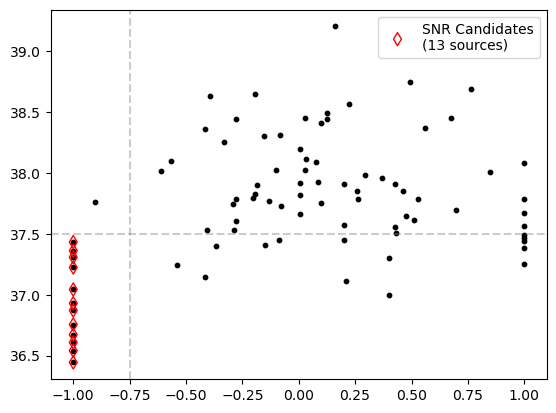

Unnamed: 0.1  Separation                 CSC ID          RA        Dec  \
0              6    8.100148  2CXO J112015.0+125921  170.062538  12.989251   
1              8    8.748180  2CXO J112014.7+125937  170.061339  12.993597   
2             24   45.142910  2CXO J112015.7+125845  170.065490  12.979281   
3             32   55.540360  2CXO J112018.8+125932  170.078417  12.992199   
4             34   56.010743  2CXO J112018.8+125924  170.078512  12.990211   
5             41   62.781313  2CXO J112019.1+125947  170.079790  12.996356   
6             43   64.596761  2CXO J112016.7+125830  170.069903  12.975028   
7             44   68.719164  2CXO J112016.4+130034  170.068581  13.009677   
8             46   72.223544  2CXO J112019.5+125958  170.081516  12.999423   
9             47   75.034310  2CXO J112014.8+125814  170.061855  12.970670   
10            50   82.862071  2CXO J112019.0+130027  170.079541  13.007541   
11            61  123.085174  2CXO J112013.7+130131  170.057214  13.025285   
12            68  163.975679  2CXO J112019.3+125658  170.080541  12.949440   

    Err Ellipse Major  Err Ellipse Minor  Err Ellipse Angle  Significance  \
0            0.417169           0.377474         174.326803      3.028571   
1            0.373752           0.353781         175.324238      4.062500   
2            0.496865           0.398594         114.179479      2.473684   
3            0.355246           0.352550         100.025275      4.722222   
4            0.382236           0.374887          10.207139      3.696970   
5            0.568604           0.431156         177.945615      2.270270   
6            0.432959           0.416387         110.602463      2.914286   
7            0.898680           0.567040         149.540655      1.846154   
8            0.611480           0.514987          16.123950      2.545455   
9            0.374988           0.359765          24.192297      4.315789   
10           0.683234           0.525060         178.786732      1.950000   
11           0.908715           0.908705           0.000000      2.000000   
12           0.773981           0.405921          35.437988      3.111111   

   Likelihood  ... Counts hilim      1Sig      2Sig           X           Y  \
0        TRUE  ...    21.057952  0.198328  0.467468  3079.93600  5512.89270   
1        TRUE  ...    24.189117  0.198165  0.465134  3216.65030  6021.71270   
2    MARGINAL  ...    15.428362  0.230993  0.557056  2743.17570  4345.60780   
3        TRUE  ...    39.647935  0.180155  0.412782  1268.45590  5858.11960   
4        TRUE  ...    27.972545  0.204380  0.478708  1257.55900  5625.36260   
5        TRUE  ...    10.844639  0.327688  0.814304  1111.85850  6344.73760   
6        TRUE  ...    18.872017  0.226934  0.542665  2239.73710  3847.70420   
7        TRUE  ...     7.793080  0.424152  1.077406  2390.50880  7904.35790   
8        TRUE  ...    11.651285  0.335104  0.832043   914.94744  6703.79160   
9        TRUE  ...    33.960968  0.182755  0.421194  3157.88090  3337.48430   
10   MARGINAL  ...     9.359211  0.401617  1.011693  1140.25440  7654.25270   
11   MARGINAL  ...     9.857108  0.469750  1.185622  3687.12100  9731.72050   
12       TRUE  ...    19.477549  0.324313  0.789514  1025.93450   851.99087   

    2Sig (pix)      ID  Bounds      LogLx  (SNR)  
0    11.798781  CXO007      In  37.043263      1  
1    11.739872  CXO009      In  37.307865      1  
2    14.059974  CXO025      In  36.755654      1  
3    10.418516  CXO033      In  37.432311      1  
4    12.082486  CXO035      In  37.223740      1  
5    20.552848  CXO042      In  36.671921      1  
6    13.696748  CXO044      In  36.870636      1  
7    27.193498  CXO045      In       -inf      1  
8    21.000582  CXO047      In  36.443881      1  
9    10.630845  CXO048      In  37.361746      1  
10   25.534906  CXO051      In  36.540719      1  
11   29.924844  CXO062     Out  36.608033      1  
12   19.927149  CXO069     Out  36.930156      1  

[13 rows x

In [211]:
M66_best['LogLx'] = np.log10(Lum(F=M66_best['Flux'], dist=1.01e+7)) # 10.1 Mpc as used by PHANGS (https://archive.stsci.edu/hlsp/phangs.html#hst_image_products_table) for their analysis
M66_best = FindSNRs(M66_best)
display(Find(M66_best, "(SNR) != 0"))
M66_best.to_csv(chandra_jwst_dir+'M66_csc_bestrads.frame')

This concludes the classification of optical counterparts of X-ray binaries

# Estimating XRB Masses with CMDs and SED fitting

In [5]:
M66_best = LoadSources(chandra_jwst_dir+'M66_csc_bestrads.frame')
DaoCleanMatch = LoadSources(chandra_jwst_dir+"M66_daoclean_matches.frame")
M66_notes = LoadSources(chandra_jwst_dir+'M66_XRB_notes.txt')

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_csc_bestrads.frame...
Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_daoclean_matches.frame...
Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_XRB_notes.txt...


## HMXBs

In [6]:
hmxbs = Find(M66_notes, 'Class == HMXB')

hmxb_df = BuildFrame(headers=DaoCleanMatch.columns.tolist())
for index1, row1 in DaoCleanMatch.iterrows():
    for index2, row2 in hmxbs.iterrows():
        if DaoCleanMatch['CSC ID'][index1] == hmxbs['CSC ID'][index2]:
            if DaoCleanMatch['StarID'][index1] == hmxbs['Best Star'][index2]:
                hmxb_df = hmxb_df._append(DaoCleanMatch.iloc[index1], ignore_index=True)

# Now, we have the sources associated with the best-stars of the HMXBs
display(hmxb_df)

RA        Dec F200W ID  F300M ID  F335M ID  F360M ID            X  \
0   170.062255  12.992622   194909       NaN       NaN       NaN  3112.115373   
1   170.062769  12.993379   200466   46243.0   42436.0   48378.0  3053.563733   
2   170.062553  12.989175   169227       NaN       NaN       NaN  3078.139903   
3   170.063436  12.989414   170933       NaN   36510.0   41929.0  2977.424760   
4   170.061405  12.993621   202302   46634.0   42805.0       NaN  3209.087814   
5   170.062865  12.993964   204900       NaN       NaN       NaN  3042.554415   
6   170.064057  12.995629   217222       NaN       NaN       NaN  2906.596588   
7   170.056415  12.995653   217443       NaN   45945.0   52227.0  3778.344403   
8   170.053561  12.996580   224400       NaN       NaN       NaN  4103.905660   
9   170.070130  12.999821   248059   56411.0   52210.0   59133.0  2213.826087   
10  170.078488  12.990329   177898   41500.0   37883.0   43394.0  1260.311740   
11  170.057334  13.006967   294365   67042.0   62189.0   70144.0  3673.486049   
12  170.069908  12.975097    80576   19795.0   17511.0   20943.0  2239.104290   
13  170.081482  12.999423   245225       NaN       NaN       NaN   918.769394   
14  170.079647  13.007501   297381   67667.0   62774.0   70814.0  1128.114227   
15  170.049502  12.969909    58631       NaN       NaN       NaN  4567.264252   
16  170.054191  12.960178    26519    6497.0    5610.0    6873.0  4032.312552   
17  170.066405  12.957754    20630       NaN       NaN       NaN  2638.804107   

              Y                 CSC ID StarID  
0   5907.603774  2CXO J112014.9+125933      4  
1   5996.243006  2CXO J112015.0+125936      1  
2   5503.968775  2CXO J112015.0+125921      6  
3   5532.041698  2CXO J112015.2+125921      5  
4   6024.547959  2CXO J112014.7+125937     14  
5   6064.707748  2CXO J112015.0+125938      6  
6   6259.641766  2CXO J112015.3+125944      8  
7   6262.444365  2CXO J112013.5+125944      4  
8   6371.060137  2CXO J112012.8+125947      2  
9   6750.389559  2CXO J112016.8+125959      5  
10  5639.166615  2CXO J112018.8+125924      9  
11  7587.077708  2CXO J112013.7+130025     15  
12  3855.747405  2CXO J112016.7+125830      8  
13  6703.892340  2CXO J112019.5+125958     13  
14  7649.563177  2CXO J112019.0+130027     10  
15  3248.497515  2CXO J112011.8+125811      5  
16  2109.128343  2CXO J112013.0+125736      4  
17  1825.304918  2CXO J112015.9+125727      1

In [7]:
dist = 11.32e6 # units pc from https://iopscience.iop.org/article/10.3847/1538-4357/ace162/meta#apjace162s2
dmod = 5 * np.log10(dist) - 5

hmxbs_photometry = GetDaoPhots(hmxb_df, 
                                photfiles=[jwstdir+'photometry_M66_f200w_nircam_sources.ecsv',
                                        jwstdir+'photometry_M66_f300m_nircam_sources.ecsv',
                                        jwstdir+'photometry_M66_f335m_nircam_sources.ecsv',
                                        jwstdir+'photometry_M66_f360m_nircam_sources.ecsv'],
                                idheads=['F200W ID', 'F300M ID', 'F335M ID', 'F360M ID'],
                                filters=['F200W', 'F300M', 'F335M', 'F360M'],
                                magheader='aperture_mag_corr',
                                dmod=dmod,
                                return_err=True)

display(hmxbs_photometry)

DaoCleanPhots = GetDaoPhots(DaoCleanMatch,
                            photfiles=[jwstdir+'photometry_M66_f200w_nircam_sources.ecsv',
                                        jwstdir+'photometry_M66_f300m_nircam_sources.ecsv',
                                        jwstdir+'photometry_M66_f335m_nircam_sources.ecsv',
                                        jwstdir+'photometry_M66_f360m_nircam_sources.ecsv'],
                            idheads=['F200W ID', 'F300M ID', 'F335M ID', 'F360M ID'],
                            filters=['F200W', 'F300M', 'F335M', 'F360M'],
                            magheader='aperture_mag_corr',
                            dmod=dmod,
                            return_err=True)

Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f200w_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f300m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f335m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f360m_nircam_sources.ecsv


RA        Dec F200W ID  F300M ID  F335M ID  F360M ID            X  \
0   170.062255  12.992622   194909       NaN       NaN       NaN  3112.115373   
1   170.062769  12.993379   200466   46243.0   42436.0   48378.0  3053.563733   
2   170.062553  12.989175   169227       NaN       NaN       NaN  3078.139903   
3   170.063436  12.989414   170933       NaN   36510.0   41929.0  2977.424760   
4   170.061405  12.993621   202302   46634.0   42805.0       NaN  3209.087814   
5   170.062865  12.993964   204900       NaN       NaN       NaN  3042.554415   
6   170.064057  12.995629   217222       NaN       NaN       NaN  2906.596588   
7   170.056415  12.995653   217443       NaN   45945.0   52227.0  3778.344403   
8   170.053561  12.996580   224400       NaN       NaN       NaN  4103.905660   
9   170.070130  12.999821   248059   56411.0   52210.0   59133.0  2213.826087   
10  170.078488  12.990329   177898   41500.0   37883.0   43394.0  1260.311740   
11  170.057334  13.006967   294365   67042.0   62189.0   70144.0  3673.486049   
12  170.069908  12.975097    80576   19795.0   17511.0   20943.0  2239.104290   
13  170.081482  12.999423   245225       NaN       NaN       NaN   918.769394   
14  170.079647  13.007501   297381   67667.0   62774.0   70814.0  1128.114227   
15  170.049502  12.969909    58631       NaN       NaN       NaN  4567.264252   
16  170.054191  12.960178    26519    6497.0    5610.0    6873.0  4032.312552   
17  170.066405  12.957754    20630       NaN       NaN       NaN  2638.804107   

              Y                 CSC ID StarID      F200W  F200W Err  \
0   5907.603774  2CXO J112014.9+125933      4 -12.429364  -0.794376   
1   5996.243006  2CXO J112015.0+125936      1 -11.485096  -1.170198   
2   5503.968775  2CXO J112015.0+125921      6  -8.730069 -12.083643   
3   5532.041698  2CXO J112015.2+125921      5 -10.929432  -1.621228   
4   6024.547959  2CXO J112014.7+125937     14 -10.945669  -1.563876   
5   6064.707748  2CXO J112015.0+125938      6  -9.746992  -4.277069   
6   6259.641766  2CXO J112015.3+125944      8  -9.410767  -2.476496   
7   6262.444365  2CXO J112013.5+125944      4 -10.409989  -0.511909   
8   6371.060137  2CXO J112012.8+125947      2  -9.577582  -0.588724   
9   6750.389559  2CXO J112016.8+125959      5 -10.244567  -0.203045   
10  5639.166615  2CXO J112018.8+125924      9 -11.915802  -0.044345   
11  7587.077708  2CXO J112013.7+130025     15 -10.015636  -0.637241   
12  3855.747405  2CXO J112016.7+125830      8  -9.432602  -0.621416   
13  6703.892340  2CXO J112019.5+125958     13  -9.175080  -0.322085   
14  7649.563177  2CXO J112019.0+130027     10 -10.535898  -0.084427   
15  3248.497515  2CXO J112011.8+125811      5  -9.960331  -0.246880   
16  2109.128343  2CXO J112013.0+125736      4 -10.063433  -0.154548   
17  1825.304918  2CXO J112015.9+125727      1  -9.512625  -0.158024   

        F300M  F300M Err      F335M  F335M Err      F360M  F360M Err  
0         NaN        NaN        NaN        NaN        NaN        NaN  
1  -12.425399  -0.857181 -12.763812  -0.754494 -12.858883  -0.694251  
2         NaN        NaN        NaN        NaN        NaN        NaN  
3         NaN        NaN -12.792294  -0.556261 -12.801434  -0.553809  
4  -12.388871  -0.640015 -12.576073  -0.645601        NaN        NaN  
5         NaN        NaN        NaN        NaN        NaN        NaN  
6         NaN        NaN        NaN        NaN        NaN        NaN  
7         NaN        NaN -10.898349  -0.777403 -10.705482  -0.904556  
8         NaN        NaN        NaN        NaN        NaN        NaN  
9   -9.400894  -0.929551  -9.589740  -1.031260  -9.237164  -1.337640  
10 -11.658351  -0.112651 -11.864673  -0.198527 -11.774265  -0.164105  
11  -9.793925  -1.654899        NaN   2.873029  -7.749557 -15.585417  
12        NaN   3.765975        NaN   3.839363        NaN   5.365663  
13        NaN        NaN        NaN        NaN        NaN        NaN  
14 -10.596953  -0.162914 -11.136535  -0.153732 -10.998740

Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f200w_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f300m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f335m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f360m_nircam_sources.ecsv


### CMDs

In [17]:
# change column names to make it compatible with FitSED models
columns = {
    'F200W': 'F2000W',
    'F200W Err': 'F2000W Err',
    'F300M': 'F3000M',
    'F300M Err': 'F3000M Err',
    'F335M': 'F3350M',
    'F335M Err': 'F3350M Err',
    'F360M': 'F3600M',
    'F360M Err': 'F3600M Err',
}

hmxbs_photometry = hmxbs_photometry.rename(columns=columns)
DaoCleanPhots = DaoCleanPhots.rename(columns=columns)

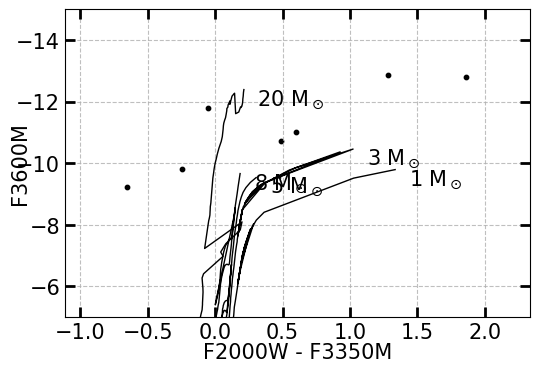

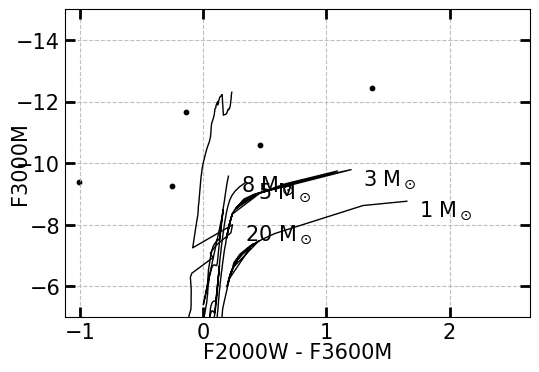

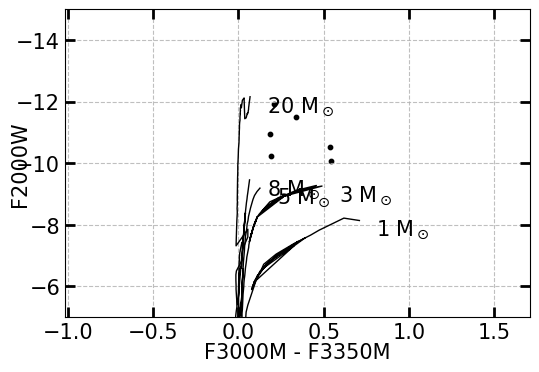

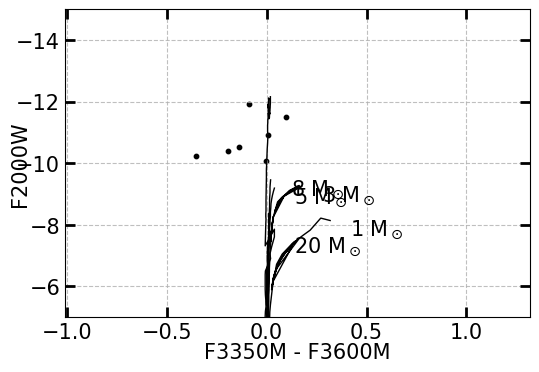

######## Photometry of DaoCleanMatches sources #############


(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F3350M - F3600M', ylabel='F2000W'>)

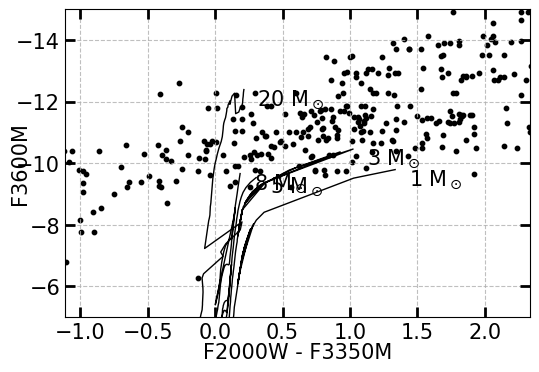

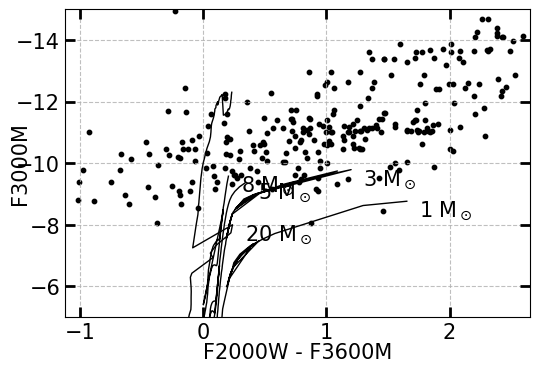

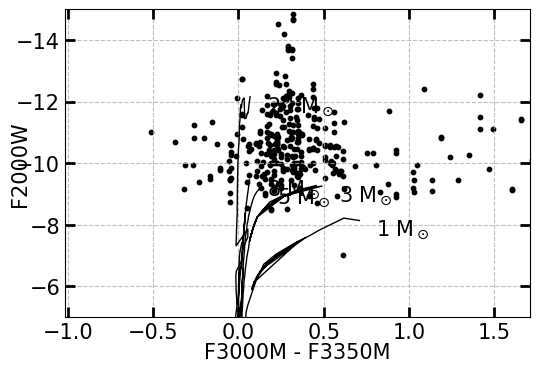

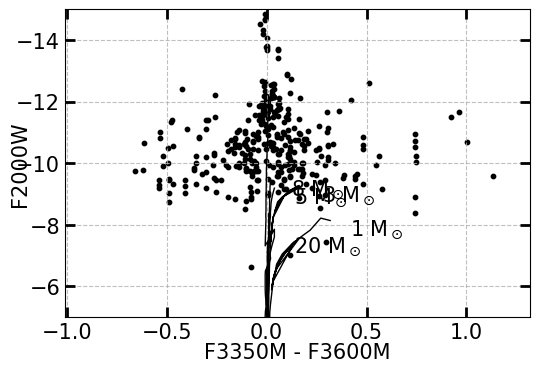

In [18]:
MakeCMD(sources=hmxbs_photometry,
        xcolor=['F2000W', 'F3350M'],
        ycolor='F3600M',
        instrument='nircam',
        ylim=(-5,-15))

MakeCMD(sources=hmxbs_photometry,
        xcolor=['F2000W', 'F3600M'],
        ycolor='F3000M',
        instrument='nircam',
        ylim=(-5,-15))

MakeCMD(sources=hmxbs_photometry,
        xcolor=['F3000M', 'F3350M'],
        ycolor='F2000W',
        instrument='nircam',
        ylim=(-5,-15))

MakeCMD(sources=hmxbs_photometry,
        xcolor=['F3350M', 'F3600M'],
        ycolor='F2000W',
        instrument='nircam',
        ylim=(-5,-15))

plt.show()

print("######## Photometry of DaoCleanMatches sources #############")
MakeCMD(xmodel=['F2000W', 'F3350M'],
        ymodel='F3600M',
        instrument='nircam',
        ylim=(-5, -15),
        sources=DaoCleanPhots)

MakeCMD(sources=DaoCleanPhots,
        xcolor=['F2000W', 'F3600M'],
        ycolor='F3000M',
        instrument='nircam',
        ylim=(-5,-15))

MakeCMD(sources=DaoCleanPhots,
        xcolor=['F3000M', 'F3350M'],
        ycolor='F2000W',
        instrument='nircam',
        ylim=(-5,-15))

MakeCMD(sources=DaoCleanPhots,
        xcolor=['F3350M', 'F3600M'],
        ycolor='F2000W',
        instrument='nircam',
        ylim=(-5,-15))

### SED fitting

In [25]:
# Rename column names to work with the input models
columns = {
    'F200W': 'F2000W',
    'F200W Err': 'F2000W Err',
    'F300M': 'F3000M',
    'F300M Err': 'F3000M Err',
    'F335M': 'F3350M',
    'F335M Err': 'F3350M Err',
    'F360M': 'F3600M',
    'F360M Err': 'F3600M Err',
}
hmxbs_photometry = hmxbs_photometry.rename(columns=columns)
# hmxbs_photometry = hmxbs_photometry.rename(columns={'F200W': 'F200Wmag',
#                                             'F300M': 'F300Mmag',
#                                             'F335M': 'F335Mmag',
#                                             'F360M': 'F360Mmag',
#                                             'F200W Err': 'F200Wmag Err',
#                                             'F300M Err': 'F300Mmag Err',
#                                             'F335M Err': 'F335Mmag Err',
#                                             'F360M Err': 'F360Mmag Err'})

Finding best-fit model(s)...
DONE
No best-fit model available for Source ID 2CXO J112014.9+125933.


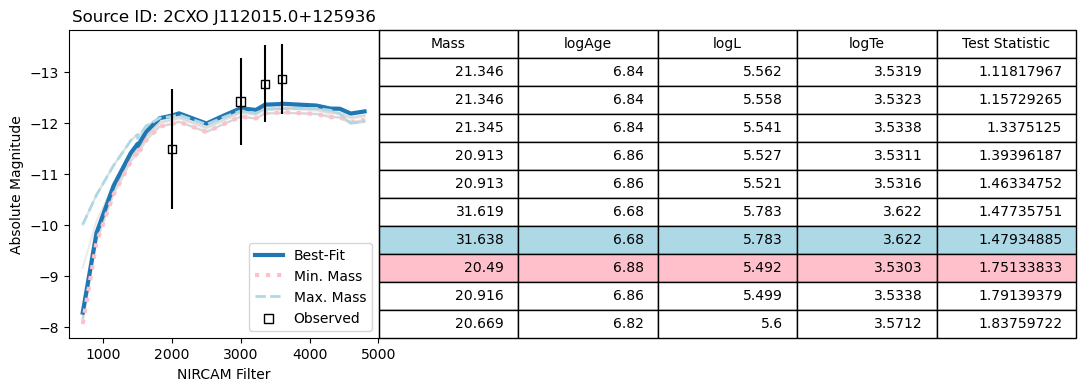

No best-fit model available for Source ID 2CXO J112015.0+125921.


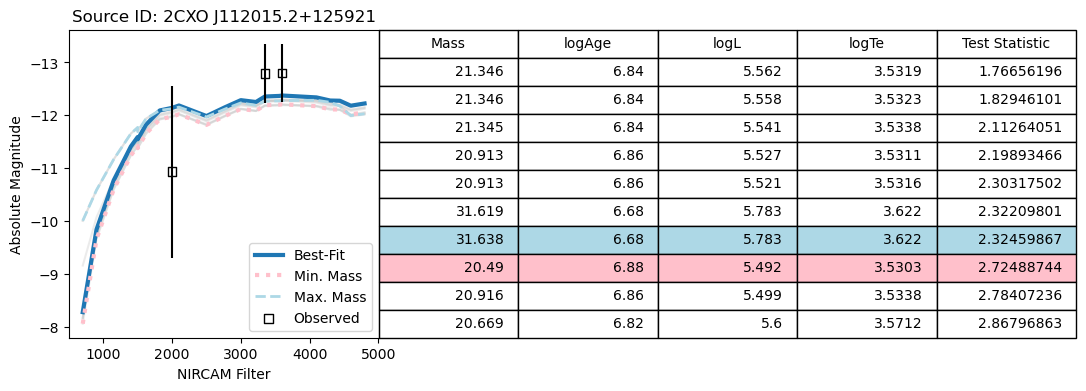

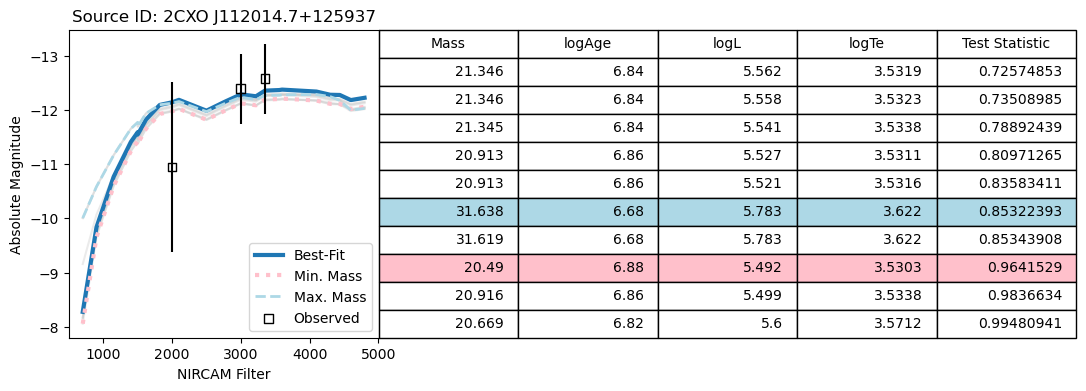

No best-fit model available for Source ID 2CXO J112015.0+125938.
No best-fit model available for Source ID 2CXO J112015.3+125944.


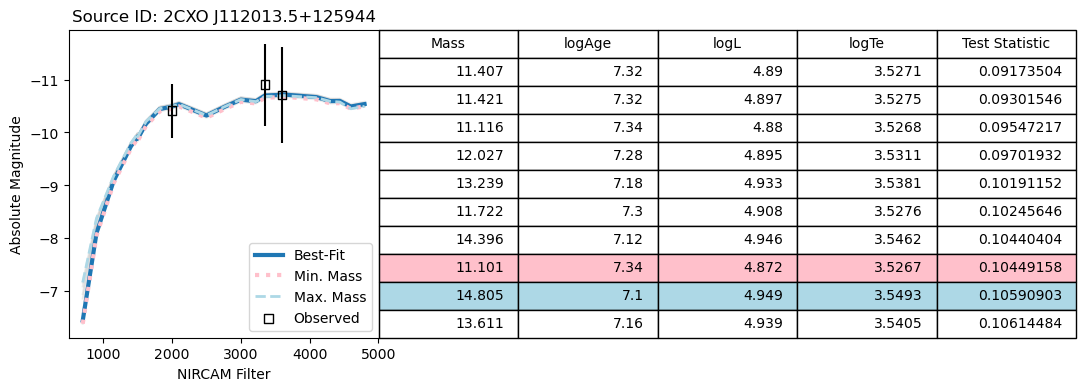

No best-fit model available for Source ID 2CXO J112012.8+125947.


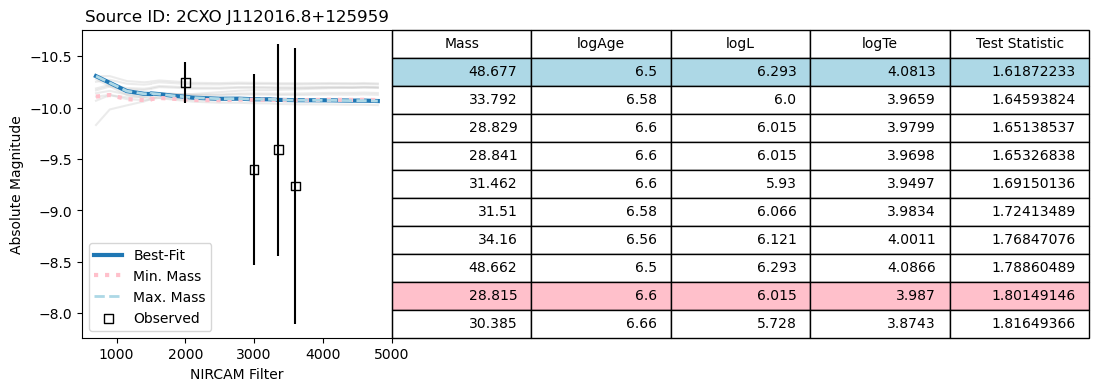

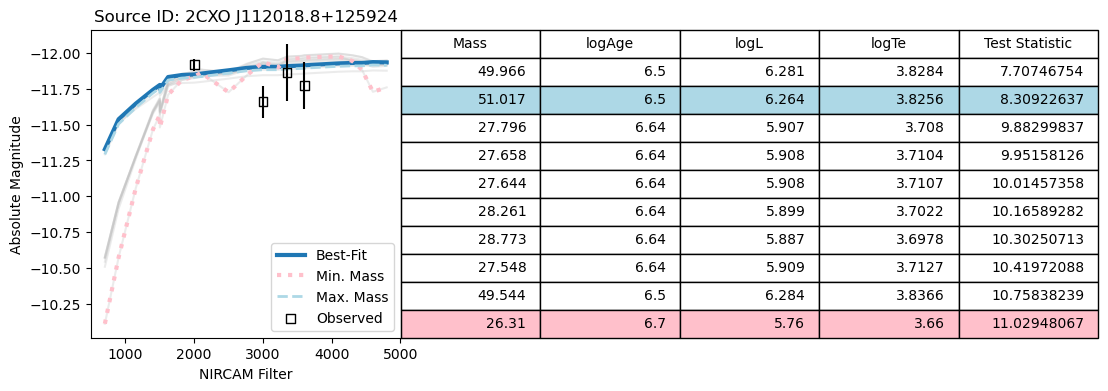

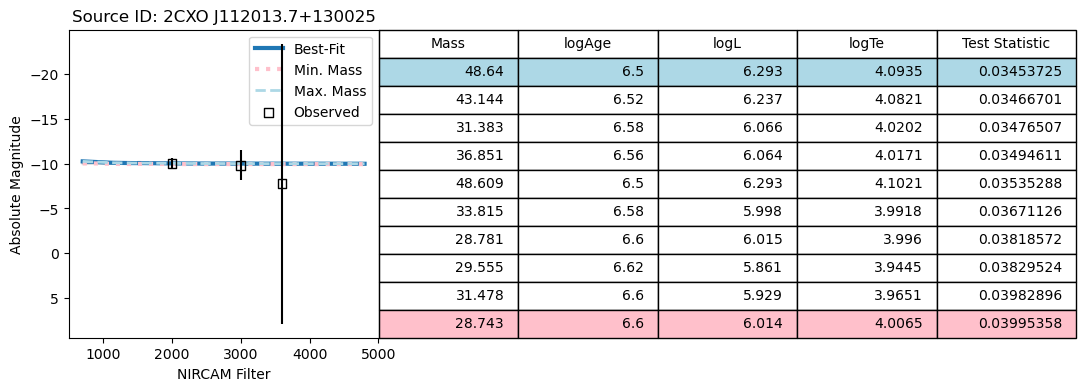

No best-fit model available for Source ID 2CXO J112016.7+125830.
No best-fit model available for Source ID 2CXO J112019.5+125958.


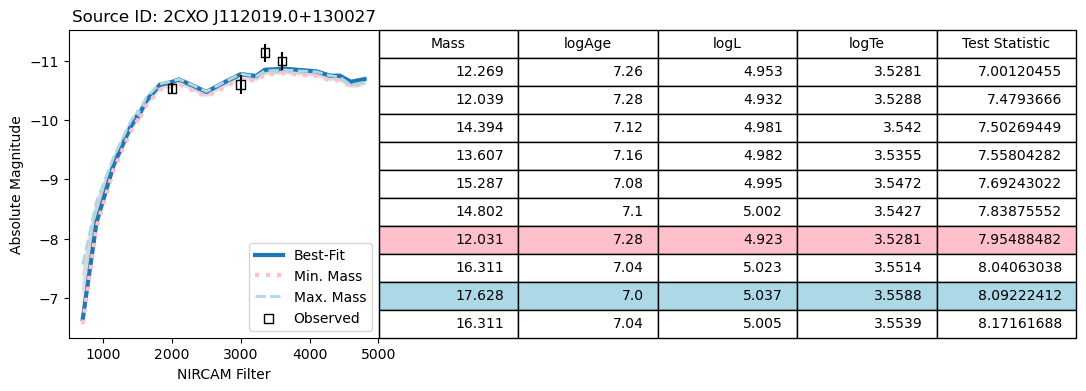

No best-fit model available for Source ID 2CXO J112011.8+125811.


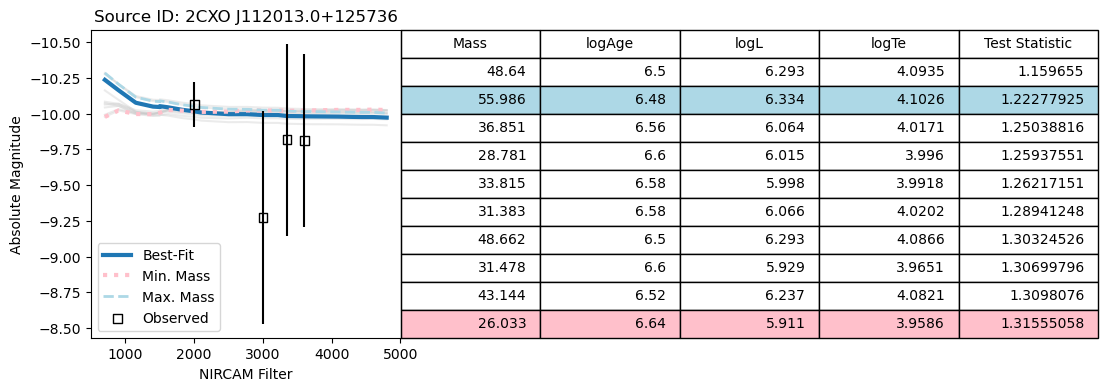

No best-fit model available for Source ID 2CXO J112015.9+125727.


Zini       MH  logAge       Mini   int_IMF    Mass   logL   logTe  \
0   0.0152  0.01508    6.50  86.382622  2.633449  48.640  6.293  4.0935   
1   0.0152  0.01508    6.52  77.945969  2.633379  43.144  6.237  4.0821   
2   0.0152  0.01508    6.58  58.736179  2.633130  31.383  6.066  4.0202   
3   0.0152  0.01508    6.56  63.933529  2.633214  36.851  6.064  4.0171   
4   0.0152  0.01508    6.50  86.388275  2.633449  48.609  6.293  4.1021   
..     ...      ...     ...        ...       ...     ...    ...     ...   
85  0.0152  0.01508    6.58  58.432178  2.633125  33.815  5.998  3.9918   
86  0.0152  0.01508    6.58  58.736179  2.633130  31.383  6.066  4.0202   
87  0.0152  0.01508    6.60  53.749969  2.633031  31.478  5.929  3.9651   
88  0.0152  0.01508    6.60  54.089111  2.633039  28.781  6.015  3.9960   
89  0.0152  0.01508    6.64  46.457661  2.632842  26.033  5.911  3.9586   

     logg label  ...  F2500M  F3000M  F3350M  F3600M  F4100M  F4300M  F4600M  \
0   1.158     1  ...  -9.996  -9.990  -9.983  -9.981  -9.979  -9.977  -9.976   
1   1.117     1  ...  -9.940  -9.935  -9.929  -9.926  -9.925  -9.923  -9.922   
2   0.902     1  ...  -9.966  -9.967  -9.963  -9.962  -9.963  -9.962  -9.963   
3   0.961     1  ...  -9.984  -9.985  -9.980  -9.979  -9.981  -9.980  -9.981   
4   1.192     1  ...  -9.933  -9.926  -9.919  -9.916  -9.914  -9.912  -9.911   
..    ...   ...  ...     ...     ...     ...     ...     ...     ...     ...   
85  0.888     1  ...  -9.997 -10.001  -9.997  -9.996  -9.999  -9.999 -10.000   
86  0.902     1  ...  -9.966  -9.967  -9.963  -9.962  -9.963  -9.962  -9.963   
87  0.820     1  ... -10.012 -10.020 -10.017 -10.017 -10.022 -10.022 -10.024   
88  0.819     1  ... -10.008 -10.011 -10.007 -10.007 -10.009 -10.009 -10.010   
89  0.729     1  ... -10.014 -10.022 -10.020 -10.021 -10.026 -10.026 -10.028   

    F4800M  Test Statistic                 CSC ID  
0   -9.972        0.034537  2CXO J112013.7+130025  
1   -9.918        0.034667  2CXO J112013.7+130025  
2   -9.959        0.034765  2CXO J112013.7+130025  
3   -9.976        0.034946  2CXO J112013.7+130025  
4   -9.907        0.035353  2CXO J112013.7+130025  
..     ...             ...                    ...  
85  -9.996        1.262172  2CXO J112013.0+125736  
86  -9.959        1.289412  2CXO J112013.0+125736  
87 -10.020        1.306998  2CXO J112013.0+125736  
88 -10.006        1.259376  2CXO J112013.0+125736  
89 -10.025        1.315551  2CXO J112013.0+125736  

[90 rows x 52 columns]

In [26]:
FitSED(df=hmxbs_photometry,
       min_models=10,
       idheader='CSC ID',
       instrument='nircam')
       #input_model='/Users/undergradstudent/Research/XRB-Analysis/jwst-models/isochrone-query-step-0_009.dat')

## LMXBs

In [27]:
lmxbs = Find(M66_notes, 'Class = LMXB')

In [28]:
# Create dataframe with only the columns of DaoCleanMatch.
# Then out of DaoCleanMatch, only add the best-star matches from 
# the lmxb dataframe to this new dataframe 
lmxbs_photometry = BuildFrame(headers=DaoCleanPhots.columns.tolist())
for index1, row1 in DaoCleanPhots.iterrows():
    for index2, row2 in lmxbs.iterrows():
        if DaoCleanPhots['CSC ID'][index1] == lmxbs['CSC ID'][index2]:
            if DaoCleanPhots['StarID'][index1] == lmxbs['Best Star'][index2]:
                lmxbs_photometry = lmxbs_photometry._append(DaoCleanPhots.iloc[index1], ignore_index=True)

In [31]:
# change column names to make it compatible with FitSED models

columns = {
    'F200W': 'F2000W',
    'F200W Err': 'F2000W Err',
    'F300M': 'F3000M',
    'F300M Err': 'F3000M Err',
    'F335M': 'F3350M',
    'F335M Err': 'F3350M Err',
    'F360M': 'F3600M',
    'F360M Err': 'F3600M Err',
}
lmxbs_photometry = lmxbs_photometry.rename(columns=columns)

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='F3350M - F3600M', ylabel='F2000W'>)

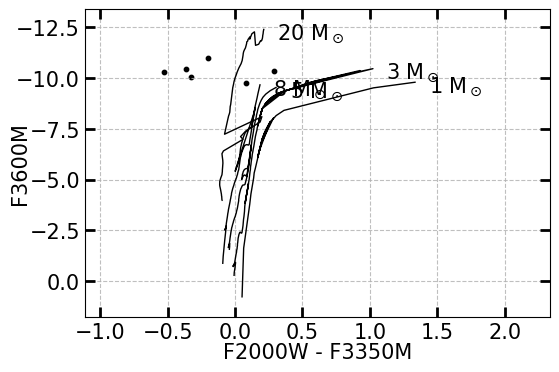

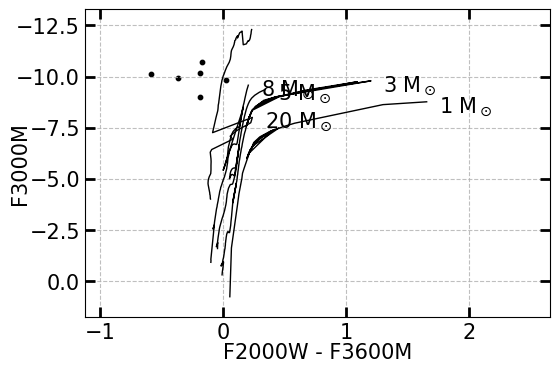

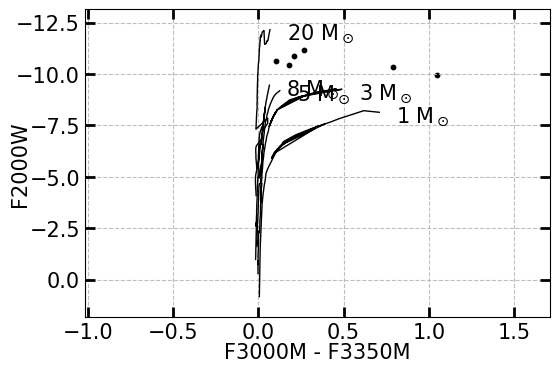

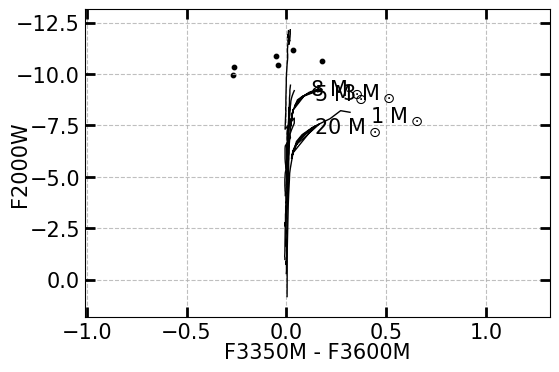

In [34]:
MakeCMD(sources=lmxbs_photometry,
        xcolor=['F2000W', 'F3350M'],
        ycolor='F3600M',
        instrument='nircam',)

MakeCMD(sources=lmxbs_photometry,
        xcolor=['F2000W', 'F3600M'],
        ycolor='F3000M',
        instrument='nircam',)

MakeCMD(sources=lmxbs_photometry,
        xcolor=['F3000M', 'F3350M'],
        ycolor='F2000W',
        instrument='nircam',)

MakeCMD(sources=lmxbs_photometry,
        xcolor=['F3350M', 'F3600M'],
        ycolor='F2000W',
        instrument='nircam',)


Finding best-fit model(s)...
DONE
No best-fit model available for Source ID 2CXO J112015.3+125932.
No best-fit model available for Source ID 2CXO J112014.1+125923.


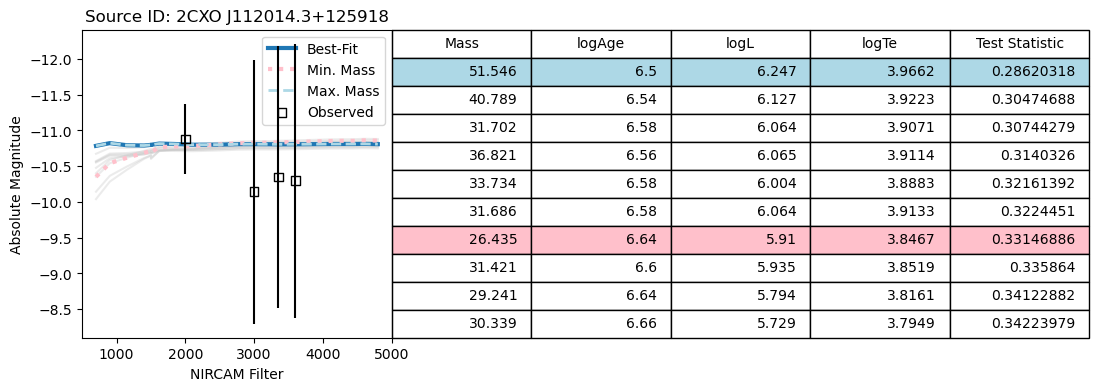

No best-fit model available for Source ID 2CXO J112014.5+125946.
No best-fit model available for Source ID 2CXO J112015.8+125910.
No best-fit model available for Source ID 2CXO J112013.4+125928.


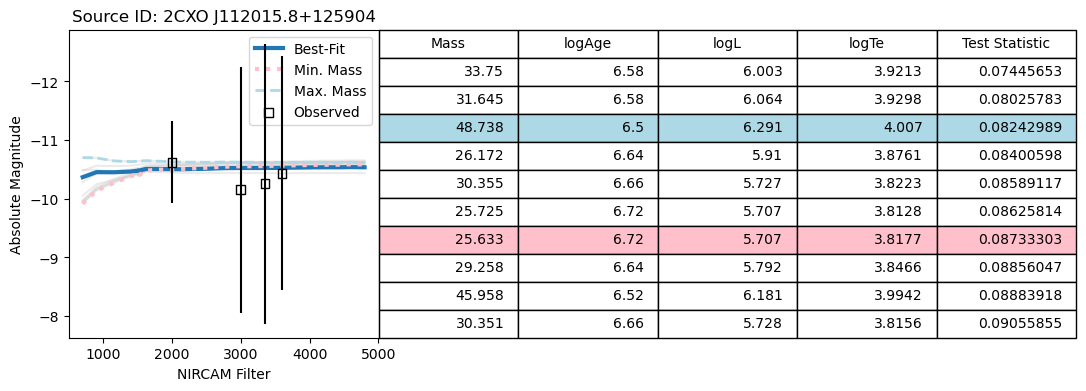

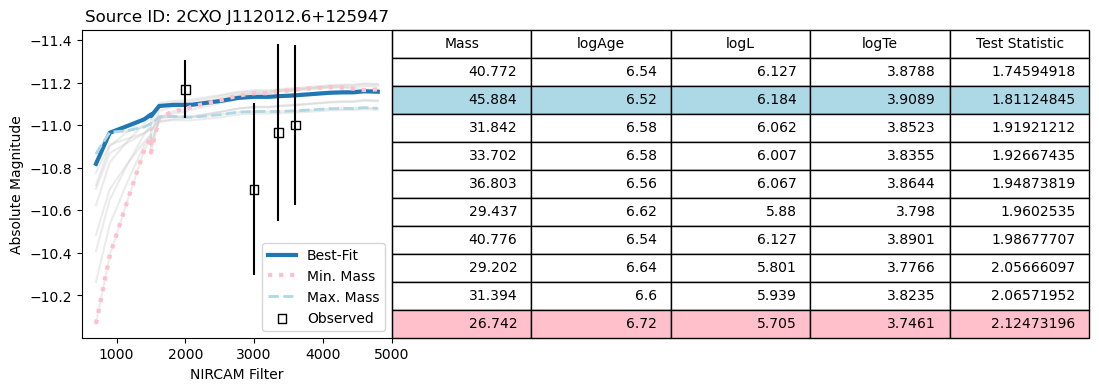

No best-fit model available for Source ID 2CXO J112017.1+130003.
No best-fit model available for Source ID 2CXO J112012.2+125952.


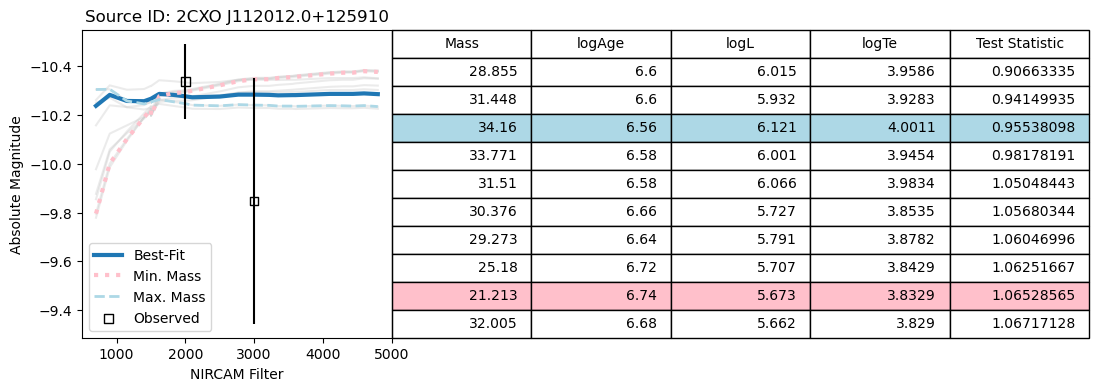

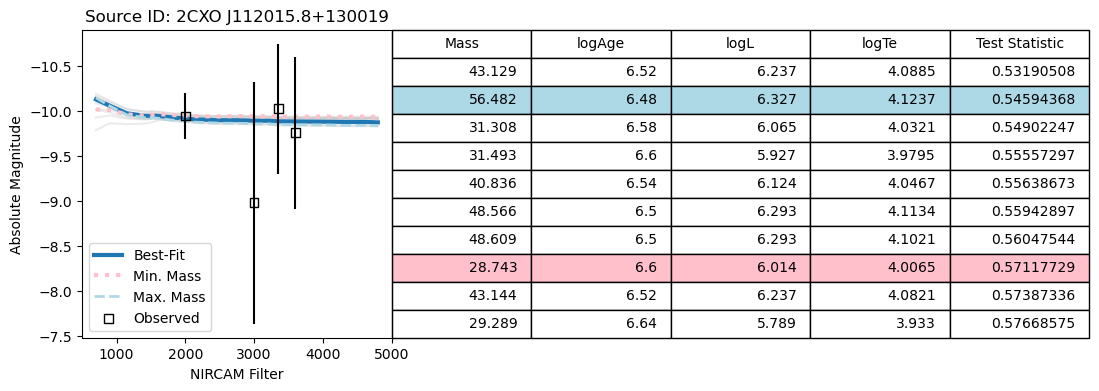

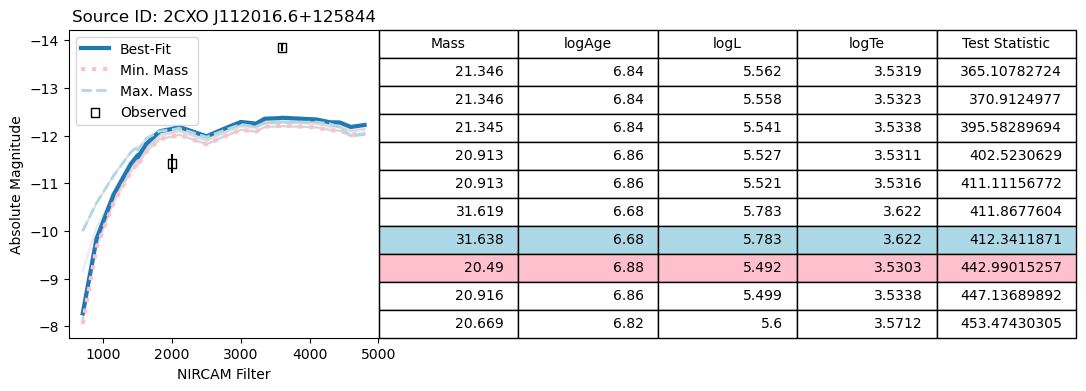

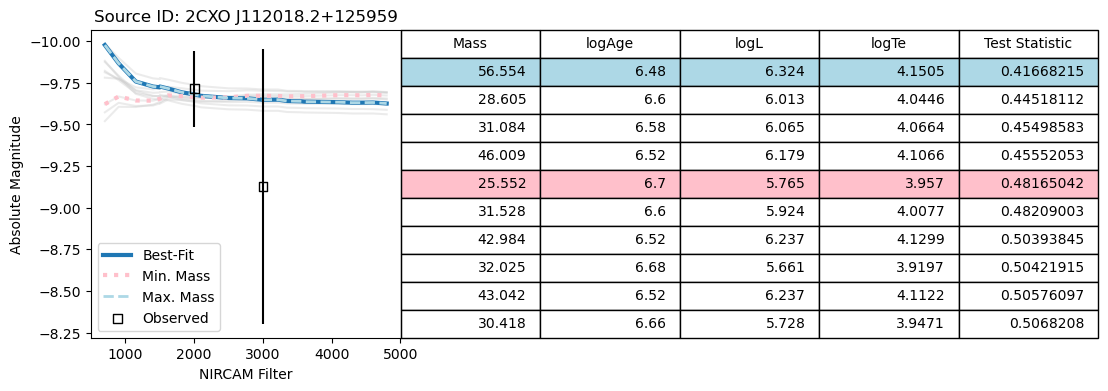

No best-fit model available for Source ID 2CXO J112012.3+125846.
No best-fit model available for Source ID 2CXO J112011.3+125904.
No best-fit model available for Source ID 2CXO J112017.3+130019.
No best-fit model available for Source ID 2CXO J112017.6+130017.
No best-fit model available for Source ID 2CXO J112017.1+130025.
No best-fit model available for Source ID 2CXO J112016.4+130034.
No best-fit model available for Source ID 2CXO J112018.7+130027.


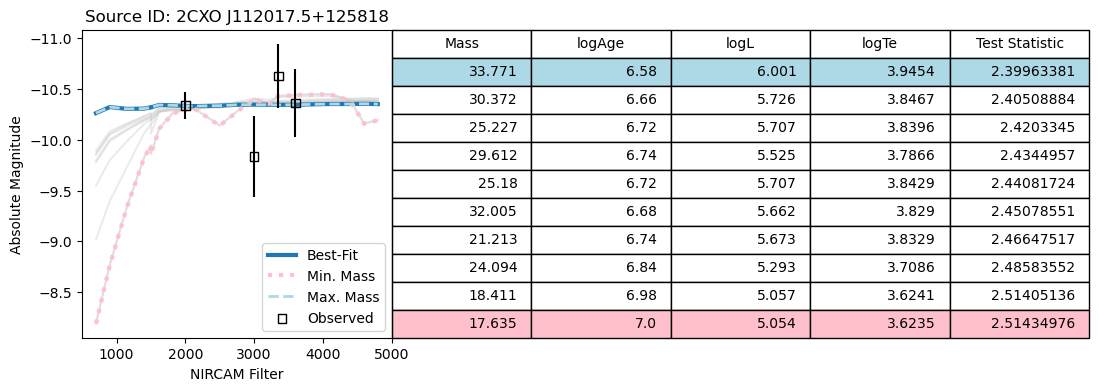

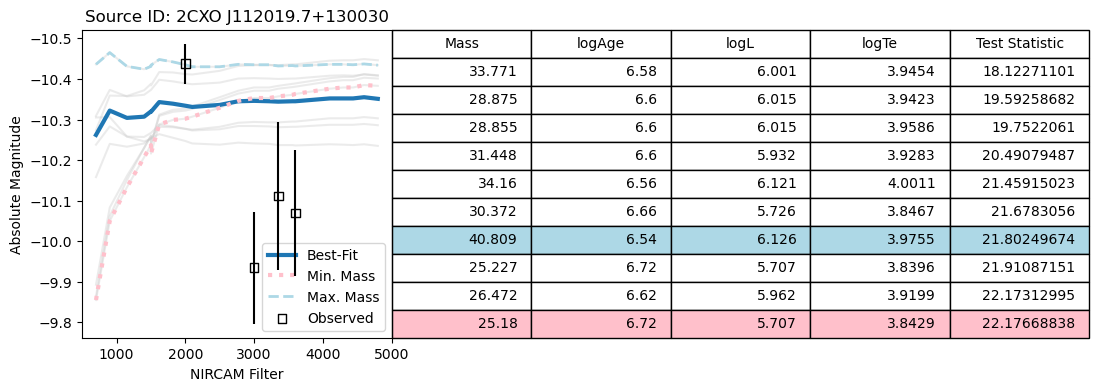

Zini       MH  logAge       Mini   int_IMF    Mass   logL   logTe  \
0   0.0152  0.01508    6.58  58.438358  2.633125  33.750  6.003  3.9213   
1   0.0152  0.01508    6.58  58.706402  2.633130  31.645  6.064  3.9298   
2   0.0152  0.01508    6.50  86.365433  2.633449  48.738  6.291  4.0070   
3   0.0152  0.01508    6.64  46.440449  2.632842  26.172  5.910  3.8761   
4   0.0152  0.01508    6.66  42.781147  2.632718  30.355  5.727  3.8223   
..     ...      ...     ...        ...       ...     ...    ...     ...   
85  0.0152  0.01508    6.60  54.082336  2.633039  28.855  6.015  3.9586   
86  0.0152  0.01508    6.62  50.028782  2.632943  26.472  5.962  3.9199   
87  0.0152  0.01508    6.66  42.777630  2.632718  30.372  5.726  3.8467   
88  0.0152  0.01508    6.72  36.739212  2.632451  25.227  5.707  3.8396   
89  0.0152  0.01508    6.72  36.750557  2.632452  25.180  5.707  3.8429   

     logg label  ...  F2500M  F3000M  F3350M  F3600M  F4100M  F4300M  F4600M  \
0   0.601     1  ... -10.511 -10.524 -10.524 -10.527 -10.535 -10.536 -10.539   
1   0.545     1  ... -10.602 -10.614 -10.613 -10.615 -10.622 -10.623 -10.626   
2   0.815     1  ... -10.622 -10.624 -10.619 -10.618 -10.621 -10.620 -10.621   
3   0.402     1  ... -10.590 -10.610 -10.613 -10.618 -10.630 -10.632 -10.637   
4   0.434     1  ... -10.543 -10.568 -10.573 -10.579 -10.591 -10.594 -10.601   
..    ...   ...  ...     ...     ...     ...     ...     ...     ...     ...   
85  0.670     1  ... -10.276 -10.284 -10.281 -10.282 -10.287 -10.287 -10.289   
86  0.530     1  ... -10.420 -10.434 -10.434 -10.436 -10.445 -10.446 -10.449   
87  0.533     1  ... -10.348 -10.371 -10.376 -10.381 -10.394 -10.397 -10.403   
88  0.443     1  ... -10.355 -10.379 -10.383 -10.389 -10.402 -10.405 -10.412   
89  0.455     1  ... -10.329 -10.353 -10.357 -10.363 -10.376 -10.379 -10.385   

    F4800M  Test Statistic                 CSC ID  
0  -10.536        0.074457  2CXO J112015.8+125904  
1  -10.623        0.080258  2CXO J112015.8+125904  
2  -10.617        0.082430  2CXO J112015.8+125904  
3  -10.635        0.084006  2CXO J112015.8+125904  
4  -10.598        0.085891  2CXO J112015.8+125904  
..     ...             ...                    ...  
85 -10.286       19.752206  2CXO J112019.7+130030  
86 -10.446       22.173130  2CXO J112019.7+130030  
87 -10.401       21.678306  2CXO J112019.7+130030  
88 -10.409       21.910872  2CXO J112019.7+130030  
89 -10.383       22.176688  2CXO J112019.7+130030  

[90 rows x 52 columns]

In [35]:
FitSED(df=lmxbs_photometry,
       min_models=10,
       idheader='CSC ID',
       instrument='nircam')
       #input_model='/Users/undergradstudent/Research/XRB-Analysis/jwst-models/isochrone-query-step-0_009.dat')

## Dust Extinction

Create a regions file with dust extinction of all sources within the 2sig

In [2]:
M66_notes = LoadSources(chandra_jwst_dir+"M66_XRB_notes.txt")
DaoCleanMatch = LoadSources(chandra_jwst_dir+"M66_daoclean_matches.frame")

# Extract photometry of sources
dist = 11.32e6 # units pc from https://iopscience.iop.org/article/10.3847/1538-4357/ace162/meta#apjace162s2
dmod = 5 * np.log10(dist) - 5

DaoCleanMatch = Find(DaoCleanMatch, 'CSC ID != 2CXO J112015.2+125932X')
DaoCleanPhots = GetDaoPhots(DaoCleanMatch,
                            photfiles=[jwstdir+'photometry_M66_f200w_nircam_sources.ecsv',
                                        jwstdir+'photometry_M66_f300m_nircam_sources.ecsv',
                                        jwstdir+'photometry_M66_f335m_nircam_sources.ecsv',
                                        jwstdir+'photometry_M66_f360m_nircam_sources.ecsv'],
                            idheads=['F200W ID', 'F300M ID', 'F335M ID', 'F360M ID'],
                            filters=['F200W', 'F300M', 'F335M', 'F360M'],
                            magheader='aperture_mag_corr',
                            dmod=dmod,
                            return_err=True)

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_XRB_notes.txt...
Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_daoclean_matches.frame...
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f200w_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f300m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f335m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f360m_nircam_sources.ecsv


In [3]:
# Rename column names to work with the input models
columns = {
    'F200W': 'F2000W',
    'F200W Err': 'F2000W Err',
    'F300M': 'F3000M',
    'F300M Err': 'F3000M Err',
    'F335M': 'F3350M',
    'F335M Err': 'F3350M Err',
    'F360M': 'F3600M',
    'F360M Err': 'F3600M Err',
}

DaoCleanPhots = DaoCleanPhots.rename(columns=columns)

In [4]:
# saved this code in analysis.py
def find_absorption(
    df_photometry,
    df_notes,
    model_ext=False,
    plotSED=False,
    cols=None,
    create_regions=False,
    outfile=None,
    fontsize=20
):
    '''
    Performs SED fitting on XRB sources and returns the dataframe with the model
    with the smallest test statistic.

    PARAMETERS
    ----------
    df_photometry : dataframe with the photometric measurements.
    df_notes      : dataframe with the header names (CSC ID in this case)
    '''
    photometry = df_photometry.copy()
    notes = df_notes.copy()
    absorption = pd.DataFrame()
    count = 0

    # to create a dataframe, absorption, with both the sourceid + the cscid
    for id in notes['CSC ID'].tolist():
        source = Find(photometry, f'CSC ID = {id}')
        for starid in source['StarID'].tolist():
            try:
                count += 1
                print(f"Count = {count}")
                print(f"Working on {id} {starid}")
                bestfit = FitSED(
                    df=Find(source, f'StarID = {starid}'),
                    instrument='nircam',
                    min_models=10,
                    plotSED=plotSED,
                    # input_model='/Users/undergradstudent/Research/XRB-Analysis/jwst-models/isochrone-query-step-0_009.dat',
                    model_ext=model_ext,
                    idheader='StarID'
                )
                bestfit['CSC ID'] = id
                
                # Add the row with the smallest test statistic to absorption
                bestfit = bestfit.sort_values(by='Test Statistic')
                min_model = Find(bestfit, f'Test Statistic = {min(bestfit['Test Statistic'])}').head(1)
                absorption = pd.concat((absorption, min_model), ignore_index=True)
            except:
                pass
    if cols: absorption = (absorption.copy())[cols]

    # get coordinates to create region files
    absorption = get_coords(absorption, df_photometry)
    absorption.to_csv(chandra_jwst_dir+'M66_XRB_dust_extinction.frame', index=False)
    if create_regions:
        WriteReg(
            sources=absorption,
            outfile=outfile,
            coordsys='fk5',
            color='blue',
            coordheads=['RA', 'Dec'],
            idheader='Av',
            radius=0.09,
            radunit='arcsec',
            fontsize=fontsize
        )

    return absorption


def get_coords(extinction_df, coords_df):
    temp = extinction_df.copy()
    temp['RA'] = ''
    temp['Dec'] = ''
    for index, row in coords_df.iterrows():
        for ind, ro in temp.iterrows():
            condition1 = (coords_df['CSC ID'][index] == temp['CSC ID'][ind])
            condition2 = (coords_df['StarID'][index] == temp['StarID'][ind])
            if condition1 and condition2:
                temp['RA'][ind] = coords_df['RA'][index]
                temp['Dec'][ind] = coords_df['Dec'][index]
    
    return temp

In [5]:
cols = [
        'logAge',
        'Mass',
        'Av',
        'logL',
        'logTe',
        'logg',
        'Test Statistic',
        'StarID',
        'CSC ID'
    ]

absorption = find_absorption(
    df_photometry=DaoCleanPhots,
    df_notes=M66_notes,
    model_ext=True,
    plotSED=False,
    cols=cols,
    create_regions=True,
    outfile=chandra_jwst_dir+"M66_XRB_dust_extinction.reg",
)

Count = 1
Working on 2CXO J112014.9+125929 1
Finding best-fit model(s)...
DONE
Count = 2
Working on 2CXO J112014.9+125929 2
Finding best-fit model(s)...
DONE
Count = 3
Working on 2CXO J112015.0+125928 1
Finding best-fit model(s)...
DONE
Count = 4
Working on 2CXO J112015.0+125928 2
Finding best-fit model(s)...
DONE
Count = 5
Working on 2CXO J112015.0+125928 3
Finding best-fit model(s)...
DONE
Count = 6
Working on 2CXO J112015.0+125928 4
Finding best-fit model(s)...
DONE
Count = 7
Working on 2CXO J112015.0+125928 5
Finding best-fit model(s)...
DONE
Count = 8
Working on 2CXO J112015.0+125928 6
Finding best-fit model(s)...
DONE
Count = 9
Working on 2CXO J112014.9+125933 1
Finding best-fit model(s)...
DONE
Count = 10
Working on 2CXO J112014.9+125933 2
Finding best-fit model(s)...
DONE
Count = 11
Working on 2CXO J112014.9+125933 3
Finding best-fit model(s)...
DONE
Count = 12
Working on 2CXO J112014.9+125933 4
Finding best-fit model(s)...
DONE
Count = 13
Working on 2CXO J112014.9+125933 5
Fin

In [6]:
absorption['Av'] = absorption['Av'].round(2)
WriteReg(
    sources=absorption,
    outfile=chandra_jwst_dir+'M66_XRB_dust_extinction_rounded.reg',
    coordsys='fk5',
    color='green',
    coordheads=['RA', 'Dec'],
    idheader='Av',
    radius=0.09,
    radunit='arcsec',
    fontsize=20
)

Saving /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_XRB_dust_extinction_rounded.reg
/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/M66_XRB_dust_extinction_rounded.reg saved!


In [7]:
# from analysis import find_absorption, get_coords

hmxb_photometry = pd.read_csv(chandra_jwst_dir+'M66_hmxbs_photometry_jwst.csv').reset_index(drop=True)
hmxb_notes = Find(pd.read_csv(chandra_jwst_dir+"M66_XRB_notes.txt"),
                  ['Class = HMXB'])
lmxb_photometry = pd.read_csv(chandra_jwst_dir+'M66_lmxbs_photometry_jwst.csv').reset_index(drop=True)
lmxb_notes = Find(pd.read_csv(chandra_jwst_dir+"M66_XRB_notes.txt"),
                  ['Class = LMXB'])

In [8]:
columns = {
    'F200W': 'F2000W',
    'F200W Err': 'F2000W Err',
    'F300M': 'F3000M',
    'F300M Err': 'F3000M Err',
    'F335M': 'F3350M',
    'F335M Err': 'F3350M Err',
    'F360M': 'F3600M',
    'F360M Err': 'F3600M Err',
}
hmxb_photometry = hmxb_photometry.rename(columns=columns)

Finding best-fit model(s)...
DONE
No best-fit model available for Source ID 2CXO J112014.9+125933.


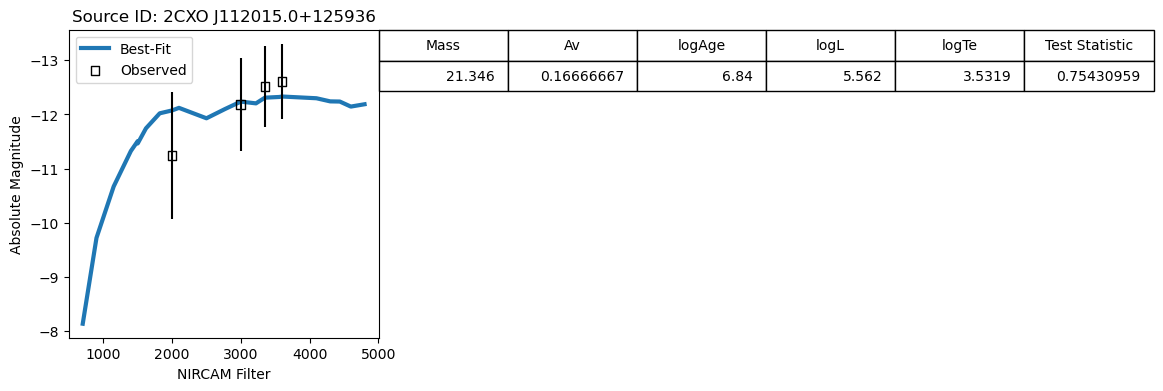

No best-fit model available for Source ID 2CXO J112015.0+125921.


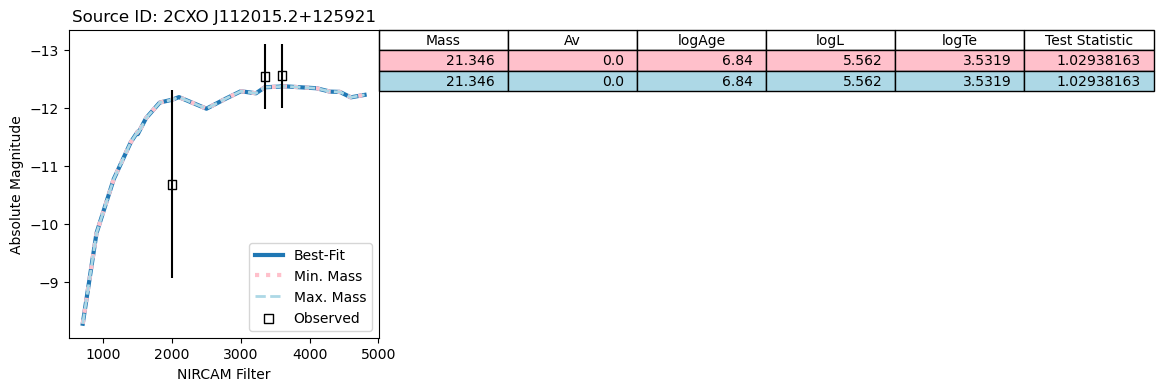

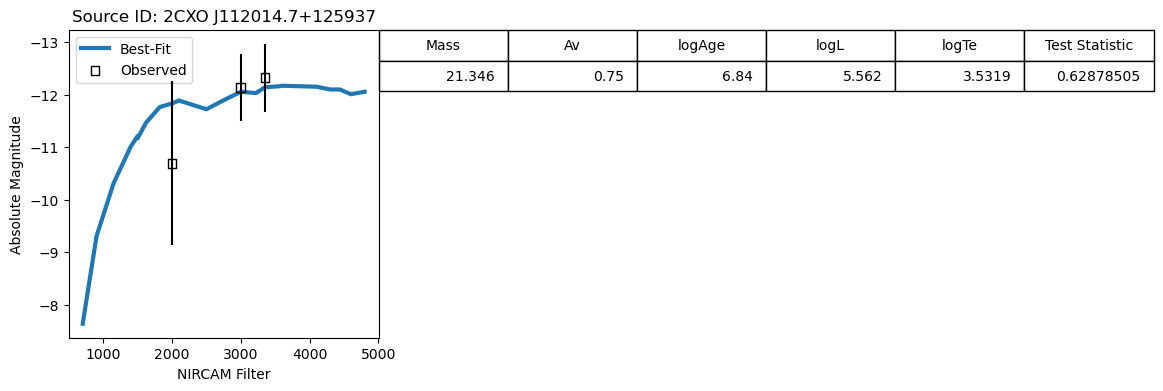

No best-fit model available for Source ID 2CXO J112015.0+125938.
No best-fit model available for Source ID 2CXO J112015.3+125944.


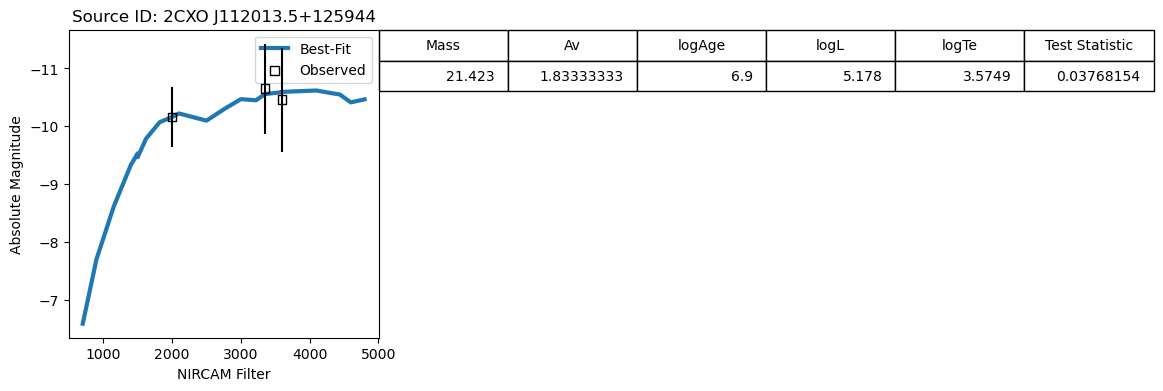

No best-fit model available for Source ID 2CXO J112012.8+125947.


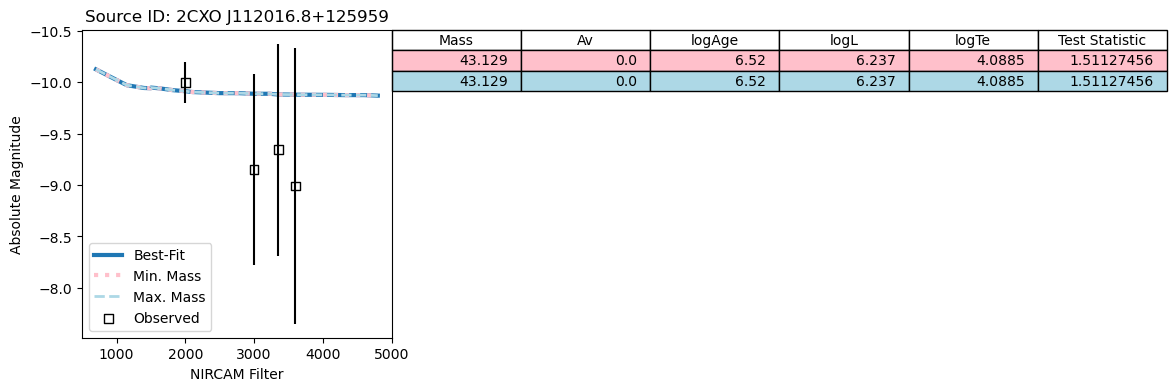

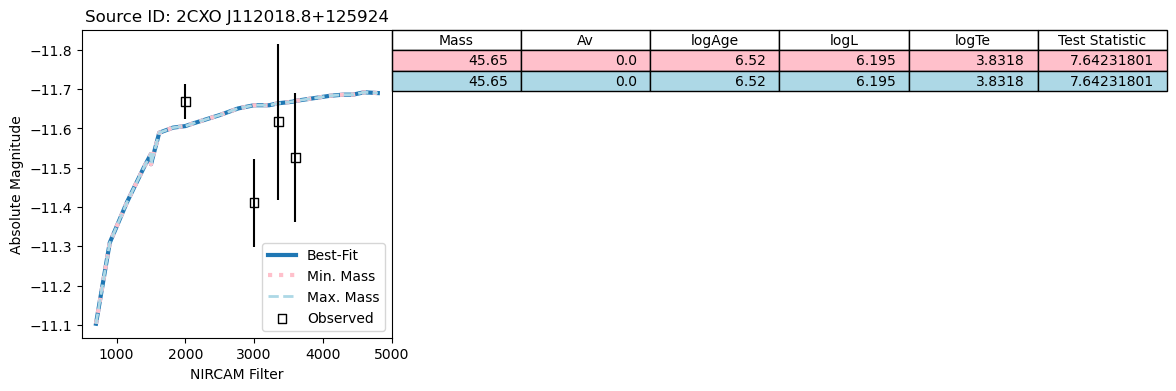

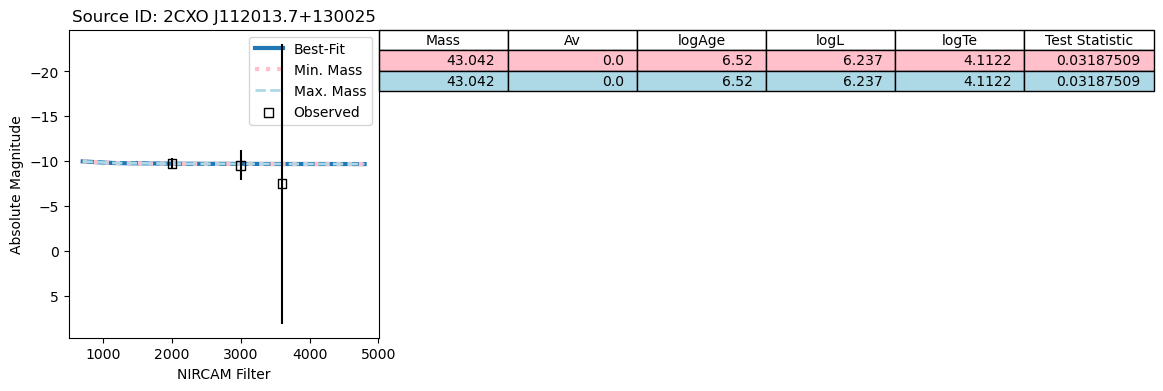

No best-fit model available for Source ID 2CXO J112016.7+125830.
No best-fit model available for Source ID 2CXO J112019.5+125958.


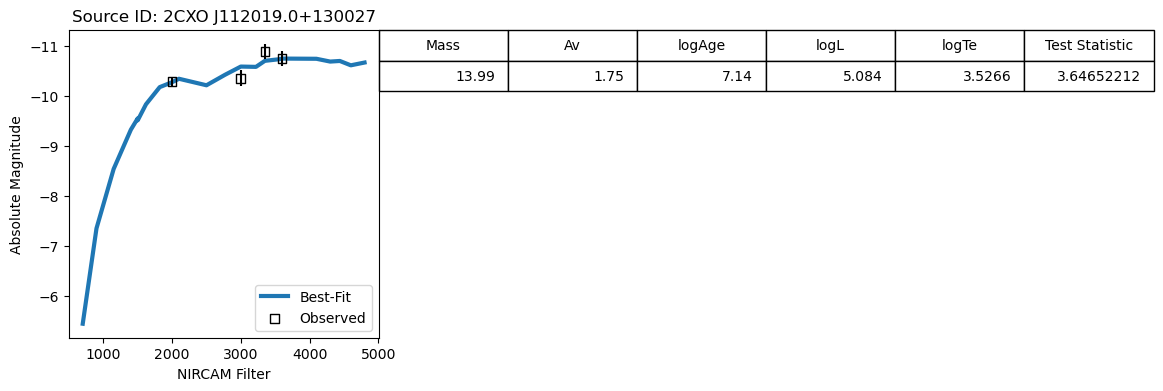

No best-fit model available for Source ID 2CXO J112011.8+125811.


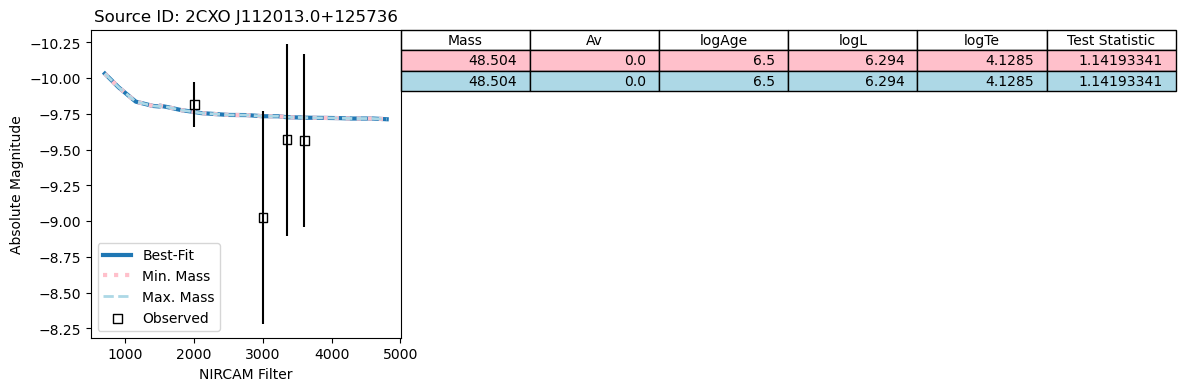

No best-fit model available for Source ID 2CXO J112015.9+125727.
14


In [9]:
fitsed = FitSED(
    df=hmxb_photometry,
    instrument='nircam',
    idheader='CSC ID',
    min_models=1,
    plotSED=True,
    model_ext=True,
    # input_model='/Users/undergradstudent/Research/XRB-Analysis/jwst-models/isochrone-query-step-0_009.dat'
)

print(len(fitsed))

In [10]:
hmxb_photometry

RA        Dec  F200W ID  F300M ID  F335M ID  F360M ID  \
0   170.062255  12.992622    194909       NaN       NaN       NaN   
1   170.062769  12.993379    200466   46243.0   42436.0   48378.0   
2   170.062553  12.989175    169227       NaN       NaN       NaN   
3   170.063436  12.989414    170933       NaN   36510.0   41929.0   
4   170.061405  12.993621    202302   46634.0   42805.0       NaN   
5   170.062865  12.993964    204900       NaN       NaN       NaN   
6   170.064057  12.995629    217222       NaN       NaN       NaN   
7   170.056415  12.995653    217443       NaN   45945.0   52227.0   
8   170.053561  12.996580    224400       NaN       NaN       NaN   
9   170.070130  12.999821    248059   56411.0   52210.0   59133.0   
10  170.078488  12.990329    177898   41500.0   37883.0   43394.0   
11  170.057334  13.006967    294365   67042.0   62189.0   70144.0   
12  170.069908  12.975097     80576   19795.0   17511.0   20943.0   
13  170.081482  12.999423    245225       NaN       NaN       NaN   
14  170.079647  13.007501    297381   67667.0   62774.0   70814.0   
15  170.049502  12.969909     58631       NaN       NaN       NaN   
16  170.054191  12.960178     26519    6497.0    5610.0    6873.0   
17  170.066405  12.957754     20630       NaN       NaN       NaN   

              X            Y                 CSC ID  StarID     F2000W  \
0   3112.115373  5907.603774  2CXO J112014.9+125933       4 -12.181739   
1   3053.563733  5996.243006  2CXO J112015.0+125936       1 -11.237470   
2   3078.139903  5503.968775  2CXO J112015.0+125921       6  -8.482443   
3   2977.424760  5532.041698  2CXO J112015.2+125921       5 -10.681807   
4   3209.087814  6024.547959  2CXO J112014.7+125937      14 -10.698044   
5   3042.554415  6064.707748  2CXO J112015.0+125938       6  -9.499366   
6   2906.596588  6259.641766  2CXO J112015.3+125944       8  -9.163141   
7   3778.344403  6262.444365  2CXO J112013.5+125944       4 -10.162363   
8   4103.905660  6371.060137  2CXO J112012.8+125947       2  -9.329957   
9   2213.826087  6750.389559  2CXO J112016.8+125959       5  -9.996942   
10  1260.311740  5639.166615  2CXO J112018.8+125924       9 -11.668177   
11  3673.486049  7587.077708  2CXO J112013.7+130025      15  -9.768010   
12  2239.104290  3855.747405  2CXO J112016.7+125830       8  -9.184977   
13   918.769394  6703.892340  2CXO J112019.5+125958      13  -8.927454   
14  1128.114227  7649.563177  2CXO J112019.0+130027      10 -10.288272   
15  4567.264252  3248.497515  2CXO J112011.8+125811       5  -9.712706   
16  4032.312552  2109.128343  2CXO J112013.0+125736       4  -9.815808   
17  2638.804107  1825.304918  2CXO J112015.9+125727       1  -9.264999   

    F2000W Err     F3000M  F3000M Err     F3350M  F3350M Err     F3600M  \
0    -0.794376        NaN         NaN        NaN         NaN        NaN   
1    -1.170198 -12.177774   -0.857181 -12.516187   -0.754494 -12.611258   
2   -12.083643        NaN         NaN        NaN         NaN        NaN   
3    -1.621228        NaN         NaN -12.544669   -0.556261 -12.553809   
4    -1.563876 -12.141246   -0.640015 -12.328448   -0.645601        NaN   
5    -4.277069        NaN         NaN        NaN         NaN        NaN   
6    -2.476496        NaN         NaN        NaN         NaN        NaN   
7    -0.511909        NaN         NaN -10.650724   -0.777403 -10.457856   
8    -0.588724        NaN         NaN        NaN         NaN        NaN   
9    -0.203045  -9.153268   -0.929551  -9.342115   -1.031260  -8.989539   
10   -0.044345 -11.410726   -0.112651 -11.617048   -0.198527 -11.526639   
11   -0.637241  -9.546300   -1.654899        NaN    2.873029  -7.501932   
12   -0.621416        NaN    3.765975        NaN    3.839363        NaN   
13   -0.322085        NaN         NaN        NaN         NaN        NaN   
14   -0.084427 -10.349328   -0.162914 -10.888910   -0.153732 -10.751115   
15   -0.246880        NaN         NaN        NaN         NaN        NaN   
16   -0.154548  -9

Finding best-fit model(s)...
DONE


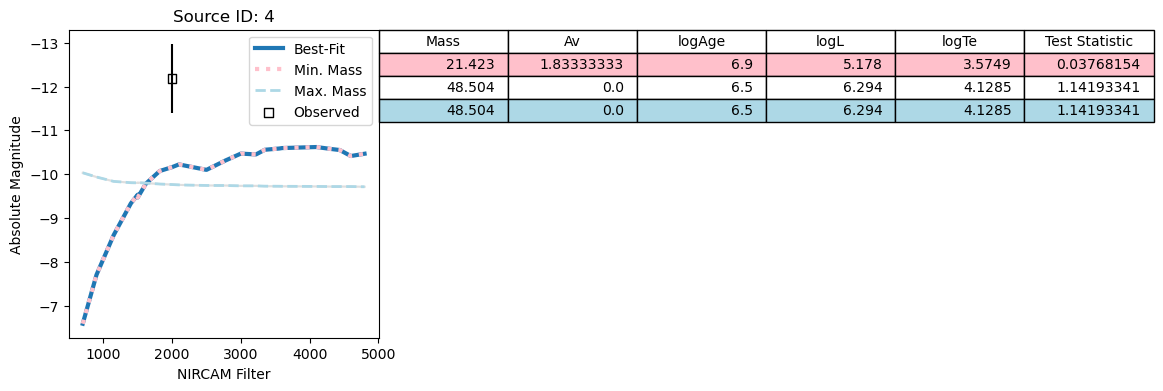

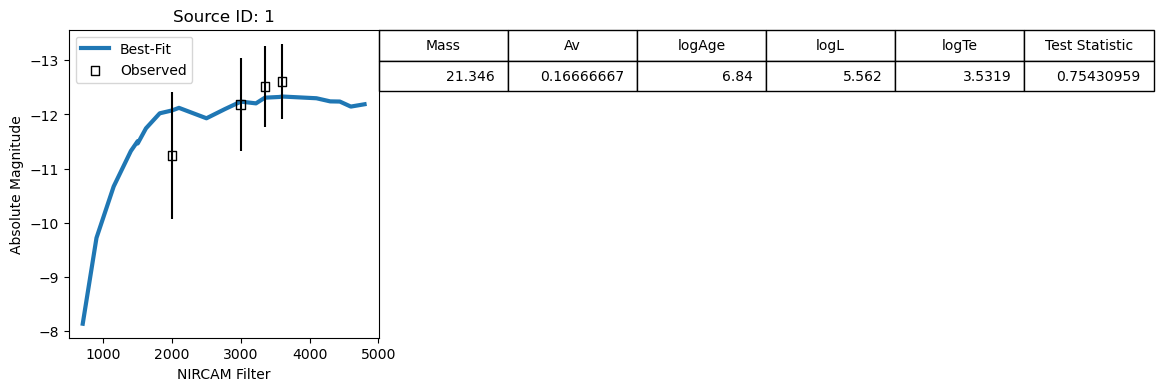

No best-fit model available for Source ID 6.


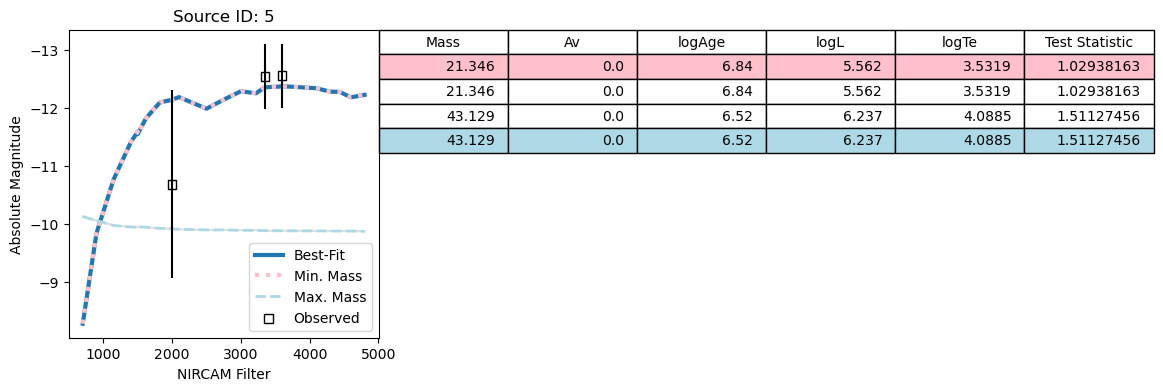

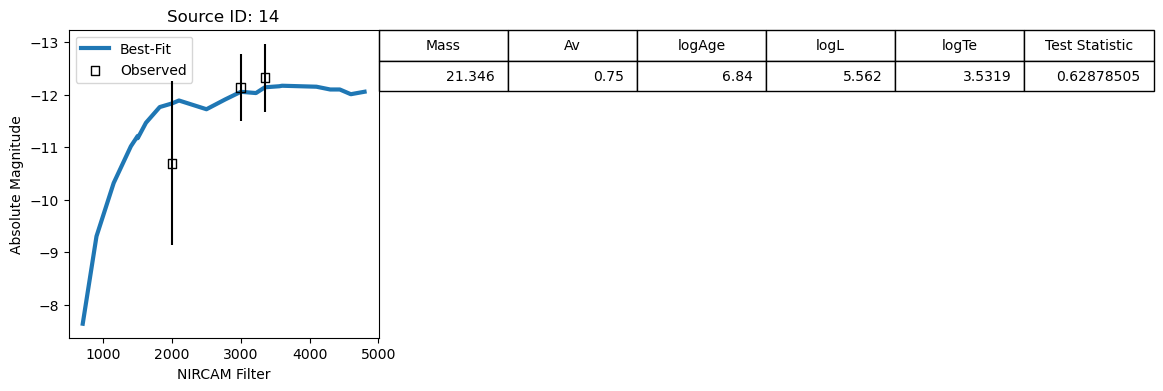

No best-fit model available for Source ID 6.
No best-fit model available for Source ID 8.


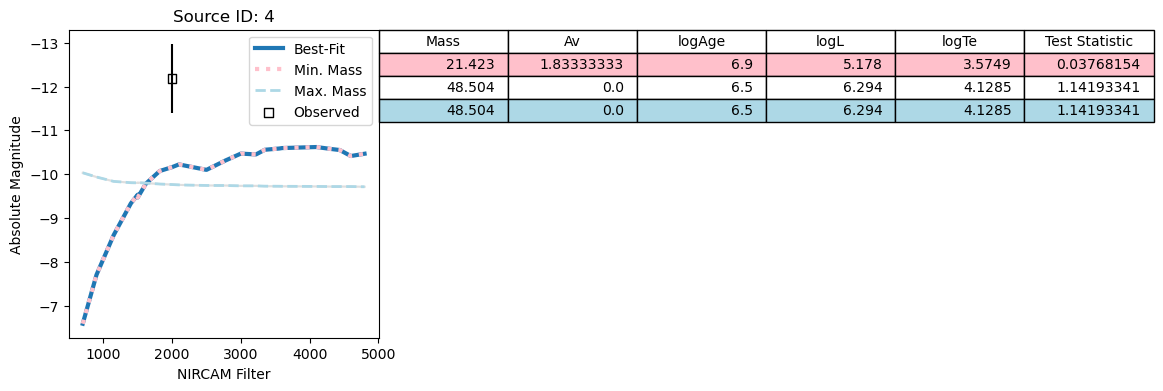

No best-fit model available for Source ID 2.


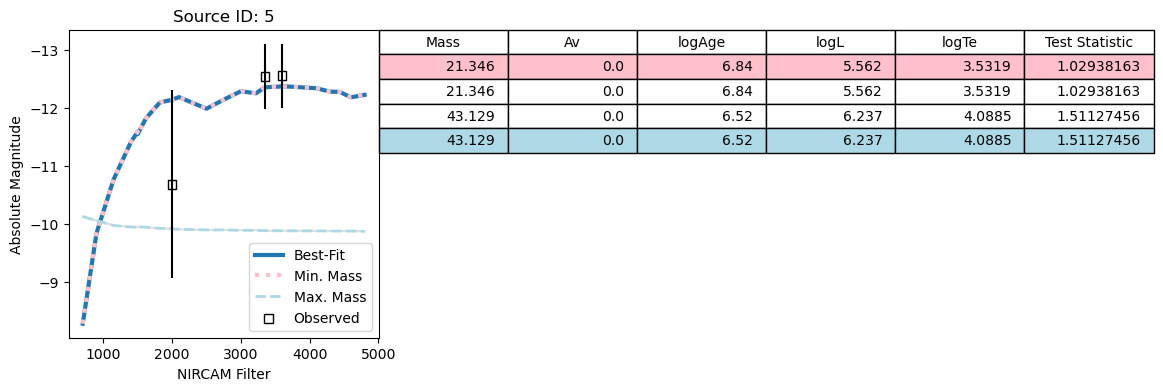

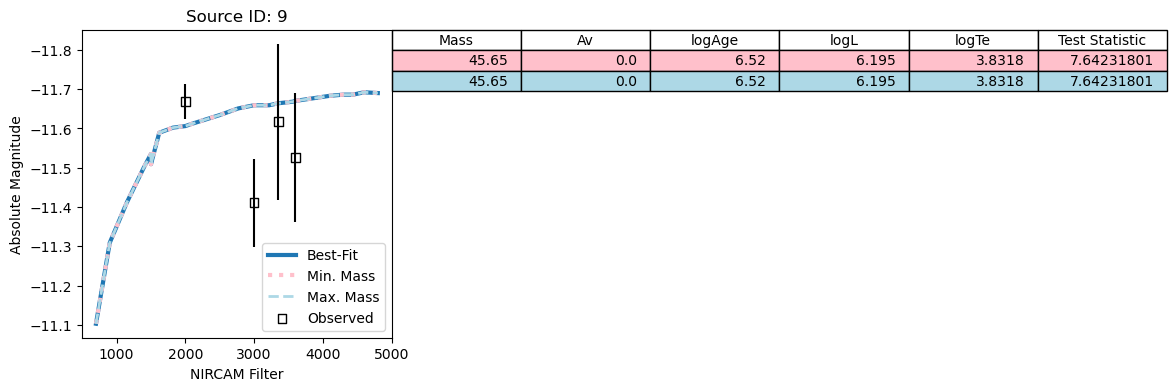

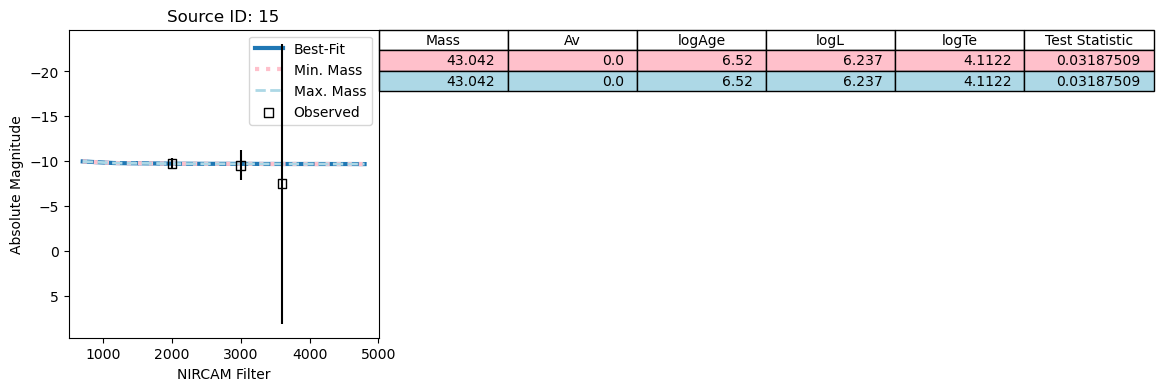

No best-fit model available for Source ID 8.
No best-fit model available for Source ID 13.


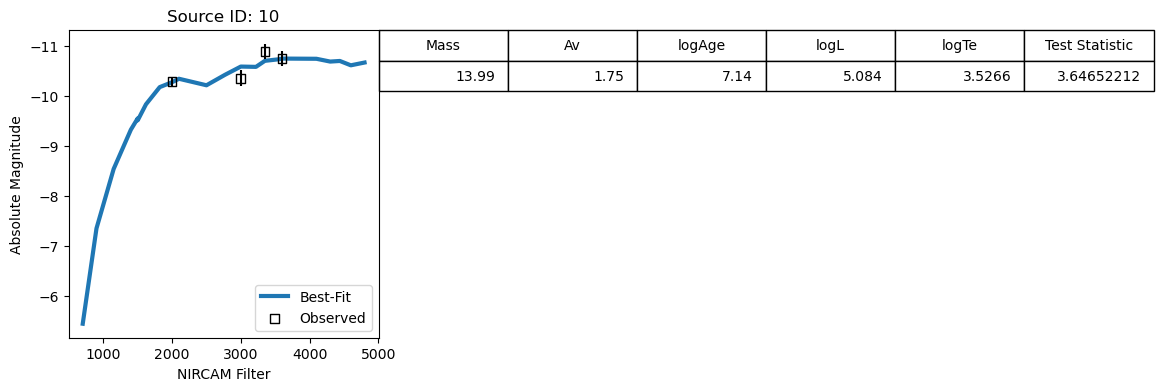

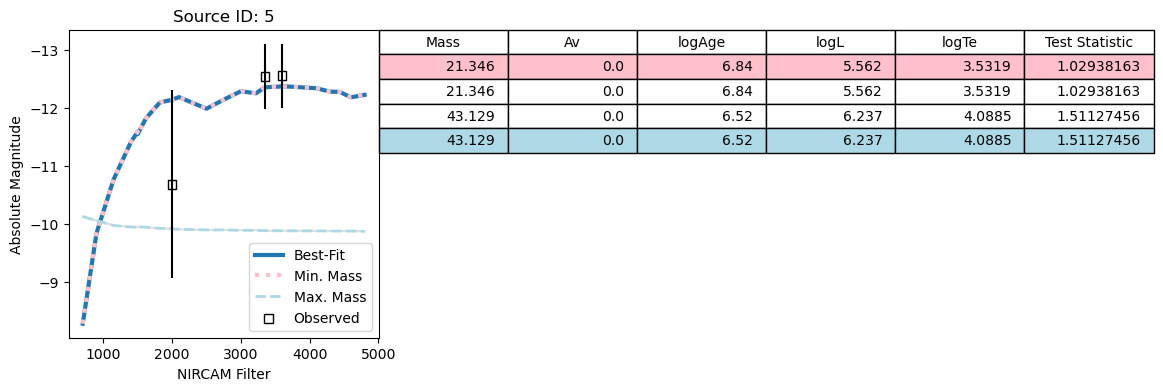

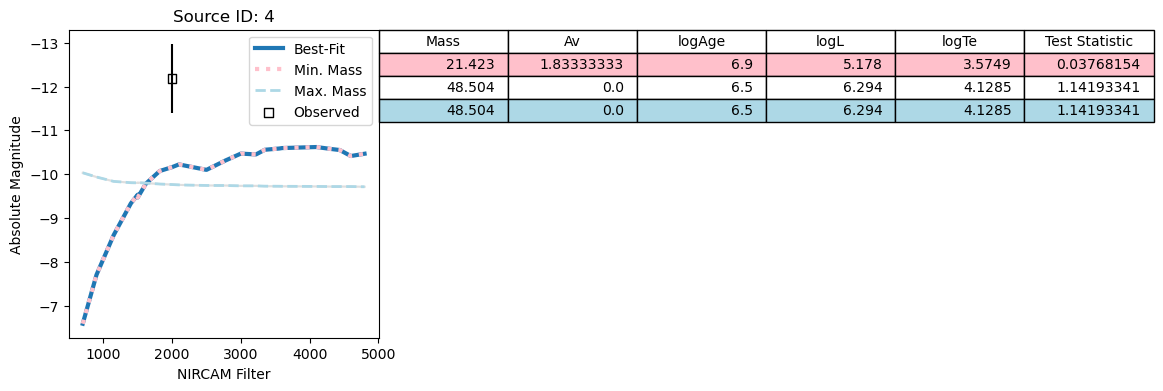

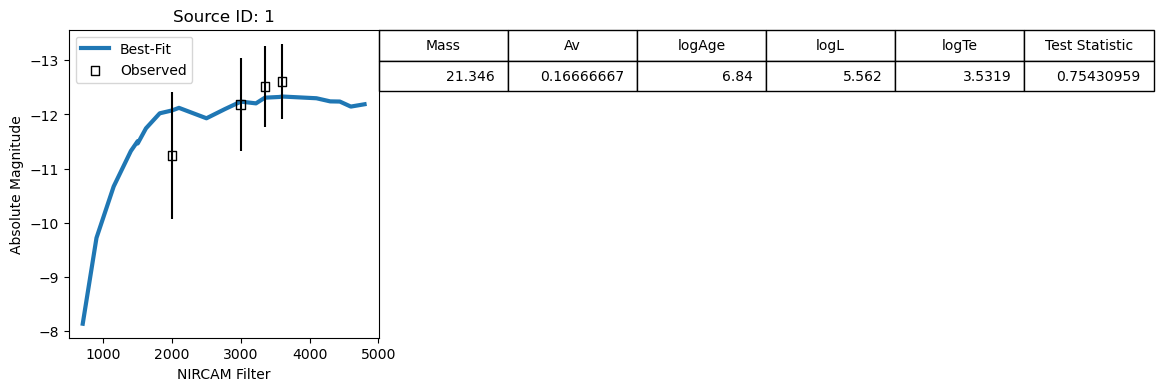

14


In [11]:
fitsed = FitSED(
    df=hmxb_photometry,
    instrument='nircam',
    idheader='StarID',
    min_models=1,
    plotSED=True,
    model_ext=True,
    # input_model='/Users/undergradstudent/Research/XRB-Analysis/jwst-models/isochrone-query-step-0_009.dat'
)

print(len(fitsed))

In [12]:
hmxb_photometry

RA        Dec  F200W ID  F300M ID  F335M ID  F360M ID  \
0   170.062255  12.992622    194909       NaN       NaN       NaN   
1   170.062769  12.993379    200466   46243.0   42436.0   48378.0   
2   170.062553  12.989175    169227       NaN       NaN       NaN   
3   170.063436  12.989414    170933       NaN   36510.0   41929.0   
4   170.061405  12.993621    202302   46634.0   42805.0       NaN   
5   170.062865  12.993964    204900       NaN       NaN       NaN   
6   170.064057  12.995629    217222       NaN       NaN       NaN   
7   170.056415  12.995653    217443       NaN   45945.0   52227.0   
8   170.053561  12.996580    224400       NaN       NaN       NaN   
9   170.070130  12.999821    248059   56411.0   52210.0   59133.0   
10  170.078488  12.990329    177898   41500.0   37883.0   43394.0   
11  170.057334  13.006967    294365   67042.0   62189.0   70144.0   
12  170.069908  12.975097     80576   19795.0   17511.0   20943.0   
13  170.081482  12.999423    245225       NaN       NaN       NaN   
14  170.079647  13.007501    297381   67667.0   62774.0   70814.0   
15  170.049502  12.969909     58631       NaN       NaN       NaN   
16  170.054191  12.960178     26519    6497.0    5610.0    6873.0   
17  170.066405  12.957754     20630       NaN       NaN       NaN   

              X            Y                 CSC ID  StarID     F2000W  \
0   3112.115373  5907.603774  2CXO J112014.9+125933       4 -12.181739   
1   3053.563733  5996.243006  2CXO J112015.0+125936       1 -11.237470   
2   3078.139903  5503.968775  2CXO J112015.0+125921       6  -8.482443   
3   2977.424760  5532.041698  2CXO J112015.2+125921       5 -10.681807   
4   3209.087814  6024.547959  2CXO J112014.7+125937      14 -10.698044   
5   3042.554415  6064.707748  2CXO J112015.0+125938       6  -9.499366   
6   2906.596588  6259.641766  2CXO J112015.3+125944       8  -9.163141   
7   3778.344403  6262.444365  2CXO J112013.5+125944       4 -10.162363   
8   4103.905660  6371.060137  2CXO J112012.8+125947       2  -9.329957   
9   2213.826087  6750.389559  2CXO J112016.8+125959       5  -9.996942   
10  1260.311740  5639.166615  2CXO J112018.8+125924       9 -11.668177   
11  3673.486049  7587.077708  2CXO J112013.7+130025      15  -9.768010   
12  2239.104290  3855.747405  2CXO J112016.7+125830       8  -9.184977   
13   918.769394  6703.892340  2CXO J112019.5+125958      13  -8.927454   
14  1128.114227  7649.563177  2CXO J112019.0+130027      10 -10.288272   
15  4567.264252  3248.497515  2CXO J112011.8+125811       5  -9.712706   
16  4032.312552  2109.128343  2CXO J112013.0+125736       4  -9.815808   
17  2638.804107  1825.304918  2CXO J112015.9+125727       1  -9.264999   

    F2000W Err     F3000M  F3000M Err     F3350M  F3350M Err     F3600M  \
0    -0.794376        NaN         NaN        NaN         NaN        NaN   
1    -1.170198 -12.177774   -0.857181 -12.516187   -0.754494 -12.611258   
2   -12.083643        NaN         NaN        NaN         NaN        NaN   
3    -1.621228        NaN         NaN -12.544669   -0.556261 -12.553809   
4    -1.563876 -12.141246   -0.640015 -12.328448   -0.645601        NaN   
5    -4.277069        NaN         NaN        NaN         NaN        NaN   
6    -2.476496        NaN         NaN        NaN         NaN        NaN   
7    -0.511909        NaN         NaN -10.650724   -0.777403 -10.457856   
8    -0.588724        NaN         NaN        NaN         NaN        NaN   
9    -0.203045  -9.153268   -0.929551  -9.342115   -1.031260  -8.989539   
10   -0.044345 -11.410726   -0.112651 -11.617048   -0.198527 -11.526639   
11   -0.637241  -9.546300   -1.654899        NaN    2.873029  -7.501932   
12   -0.621416        NaN    3.765975        NaN    3.839363        NaN   
13   -0.322085        NaN         NaN        NaN         NaN        NaN   
14   -0.084427 -10.349328   -0.162914 -10.888910   -0.153732 -10.751115   
15   -0.246880        NaN         NaN        NaN         NaN        NaN   
16   -0.154548  -9

In [13]:
hmxb_photometry[3:]

RA        Dec  F200W ID  F300M ID  F335M ID  F360M ID  \
3   170.063436  12.989414    170933       NaN   36510.0   41929.0   
4   170.061405  12.993621    202302   46634.0   42805.0       NaN   
5   170.062865  12.993964    204900       NaN       NaN       NaN   
6   170.064057  12.995629    217222       NaN       NaN       NaN   
7   170.056415  12.995653    217443       NaN   45945.0   52227.0   
8   170.053561  12.996580    224400       NaN       NaN       NaN   
9   170.070130  12.999821    248059   56411.0   52210.0   59133.0   
10  170.078488  12.990329    177898   41500.0   37883.0   43394.0   
11  170.057334  13.006967    294365   67042.0   62189.0   70144.0   
12  170.069908  12.975097     80576   19795.0   17511.0   20943.0   
13  170.081482  12.999423    245225       NaN       NaN       NaN   
14  170.079647  13.007501    297381   67667.0   62774.0   70814.0   
15  170.049502  12.969909     58631       NaN       NaN       NaN   
16  170.054191  12.960178     26519    6497.0    5610.0    6873.0   
17  170.066405  12.957754     20630       NaN       NaN       NaN   

              X            Y                 CSC ID  StarID     F2000W  \
3   2977.424760  5532.041698  2CXO J112015.2+125921       5 -10.681807   
4   3209.087814  6024.547959  2CXO J112014.7+125937      14 -10.698044   
5   3042.554415  6064.707748  2CXO J112015.0+125938       6  -9.499366   
6   2906.596588  6259.641766  2CXO J112015.3+125944       8  -9.163141   
7   3778.344403  6262.444365  2CXO J112013.5+125944       4 -10.162363   
8   4103.905660  6371.060137  2CXO J112012.8+125947       2  -9.329957   
9   2213.826087  6750.389559  2CXO J112016.8+125959       5  -9.996942   
10  1260.311740  5639.166615  2CXO J112018.8+125924       9 -11.668177   
11  3673.486049  7587.077708  2CXO J112013.7+130025      15  -9.768010   
12  2239.104290  3855.747405  2CXO J112016.7+125830       8  -9.184977   
13   918.769394  6703.892340  2CXO J112019.5+125958      13  -8.927454   
14  1128.114227  7649.563177  2CXO J112019.0+130027      10 -10.288272   
15  4567.264252  3248.497515  2CXO J112011.8+125811       5  -9.712706   
16  4032.312552  2109.128343  2CXO J112013.0+125736       4  -9.815808   
17  2638.804107  1825.304918  2CXO J112015.9+125727       1  -9.264999   

    F2000W Err     F3000M  F3000M Err     F3350M  F3350M Err     F3600M  \
3    -1.621228        NaN         NaN -12.544669   -0.556261 -12.553809   
4    -1.563876 -12.141246   -0.640015 -12.328448   -0.645601        NaN   
5    -4.277069        NaN         NaN        NaN         NaN        NaN   
6    -2.476496        NaN         NaN        NaN         NaN        NaN   
7    -0.511909        NaN         NaN -10.650724   -0.777403 -10.457856   
8    -0.588724        NaN         NaN        NaN         NaN        NaN   
9    -0.203045  -9.153268   -0.929551  -9.342115   -1.031260  -8.989539   
10   -0.044345 -11.410726   -0.112651 -11.617048   -0.198527 -11.526639   
11   -0.637241  -9.546300   -1.654899        NaN    2.873029  -7.501932   
12   -0.621416        NaN    3.765975        NaN    3.839363        NaN   
13   -0.322085        NaN         NaN        NaN         NaN        NaN   
14   -0.084427 -10.349328   -0.162914 -10.888910   -0.153732 -10.751115   
15   -0.246880        NaN         NaN        NaN         NaN        NaN   
16   -0.154548  -9.026162   -0.743486  -9.570411   -0.670797  -9.565069   
17   -0.158024        NaN         NaN        NaN         NaN        NaN   

    F3600M Err  
3    -0.553809  
4          NaN  
5          NaN  
6          NaN  
7    -0.904556  
8          NaN  
9    -1.337640  
10   -0.164105  
11  -15.585417  
12    5.365663  
13         NaN  
14   -0.150176  
15         NaN  
16   -0.606542  
17         NaN

Finding best-fit model(s)...
DONE


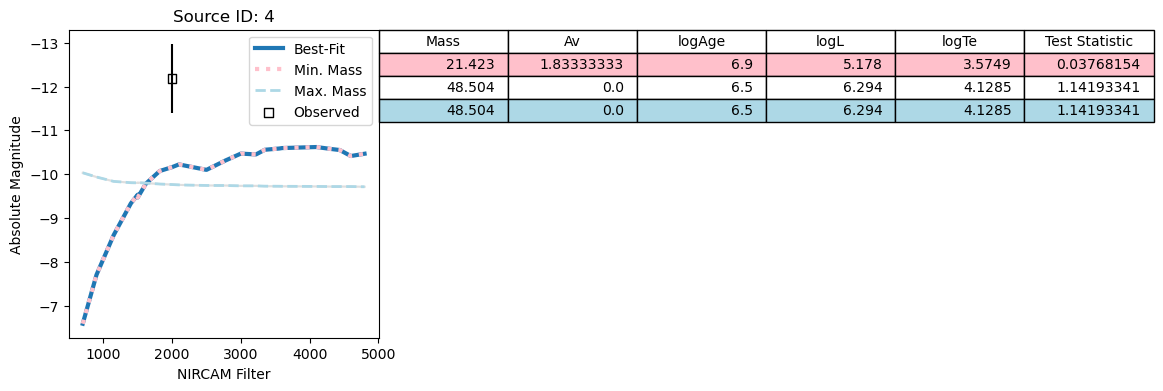

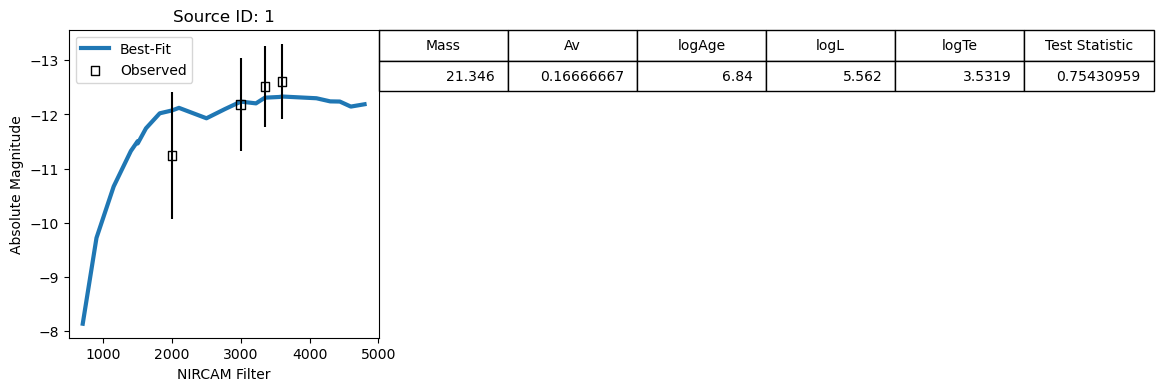

No best-fit model available for Source ID 6.


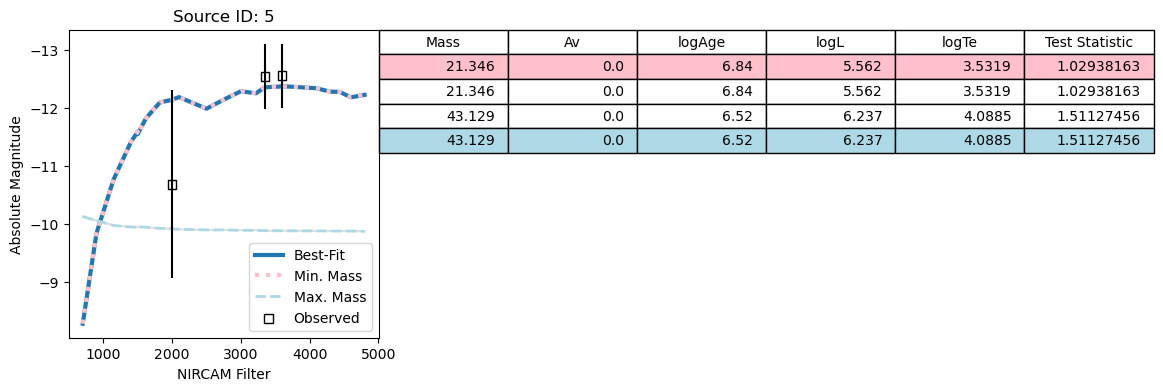

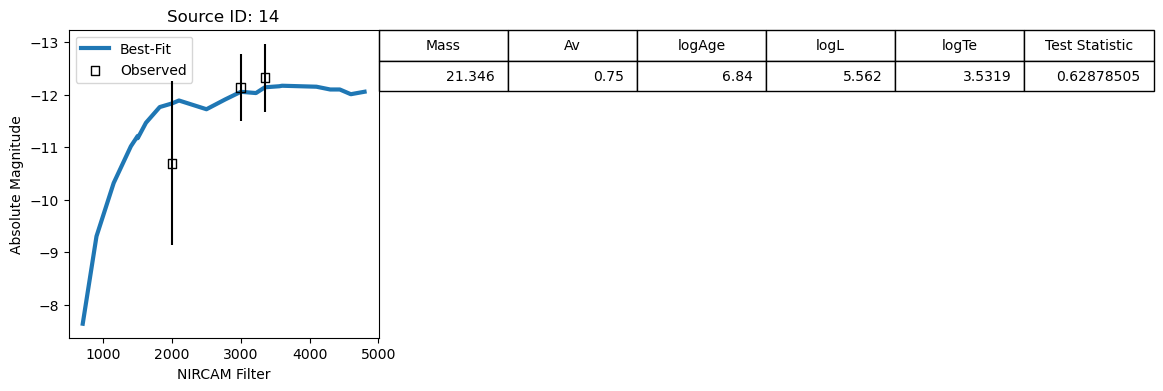

No best-fit model available for Source ID 6.
No best-fit model available for Source ID 8.


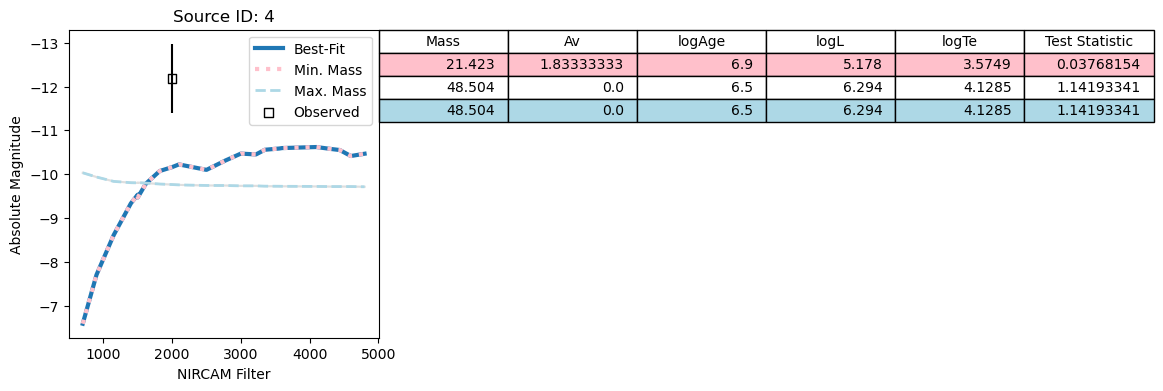

No best-fit model available for Source ID 2.


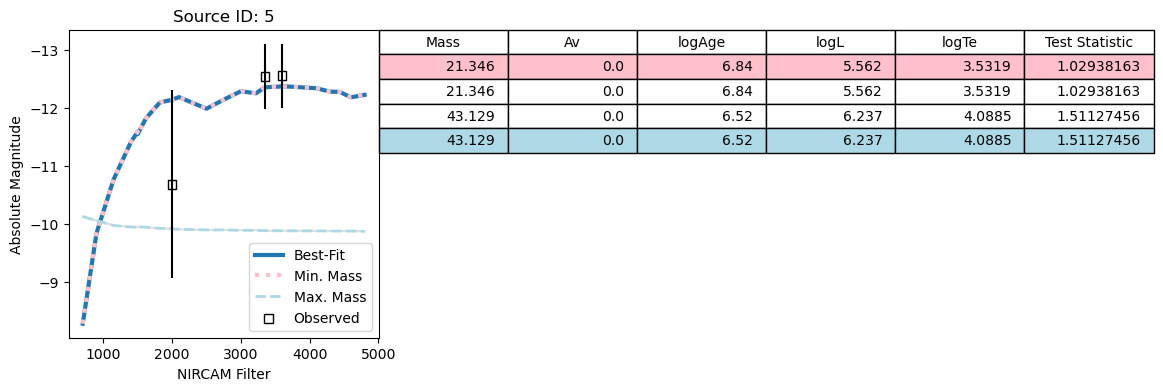

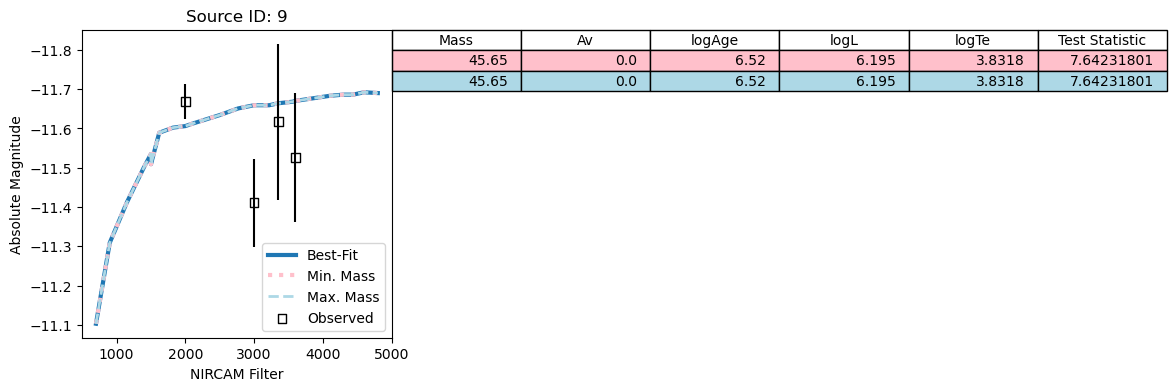

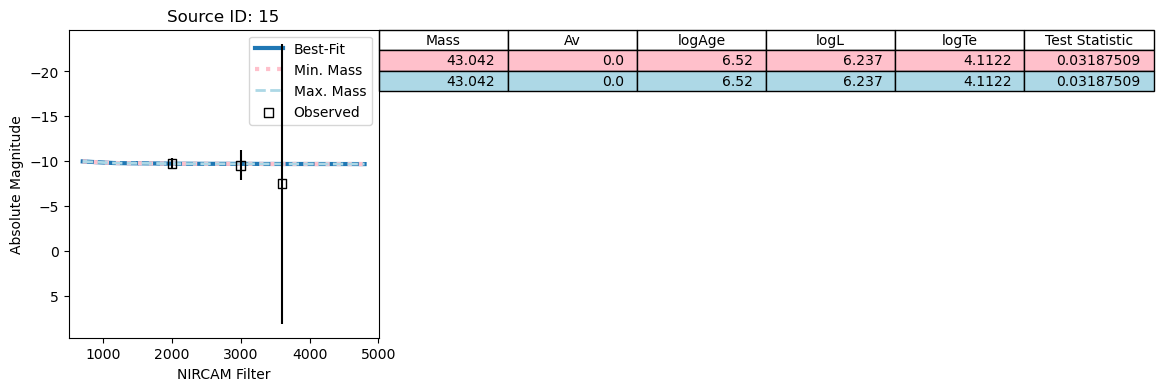

No best-fit model available for Source ID 8.
No best-fit model available for Source ID 13.


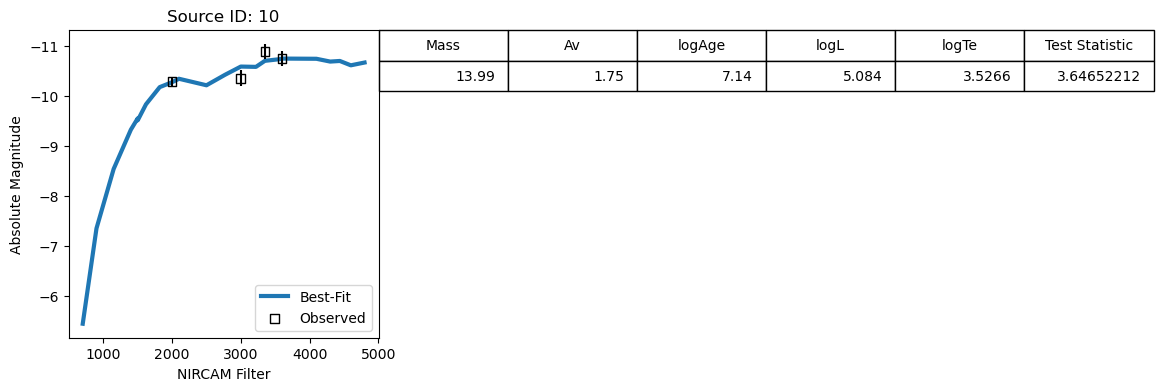

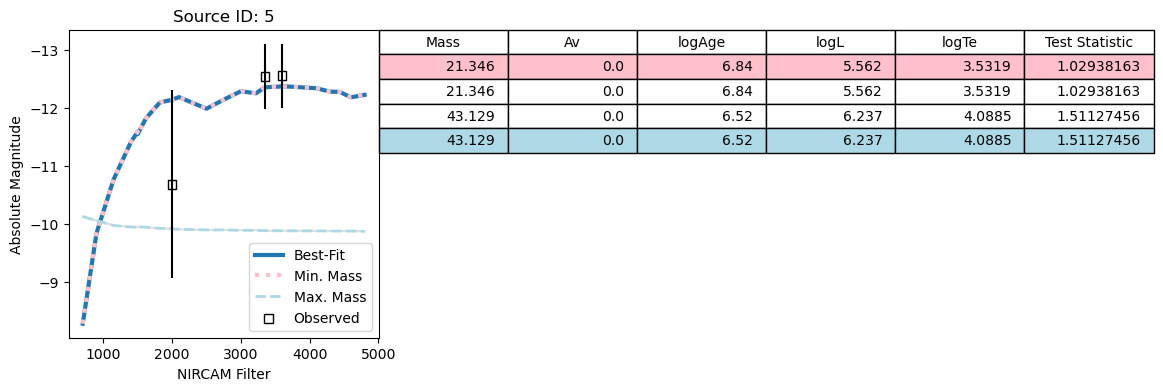

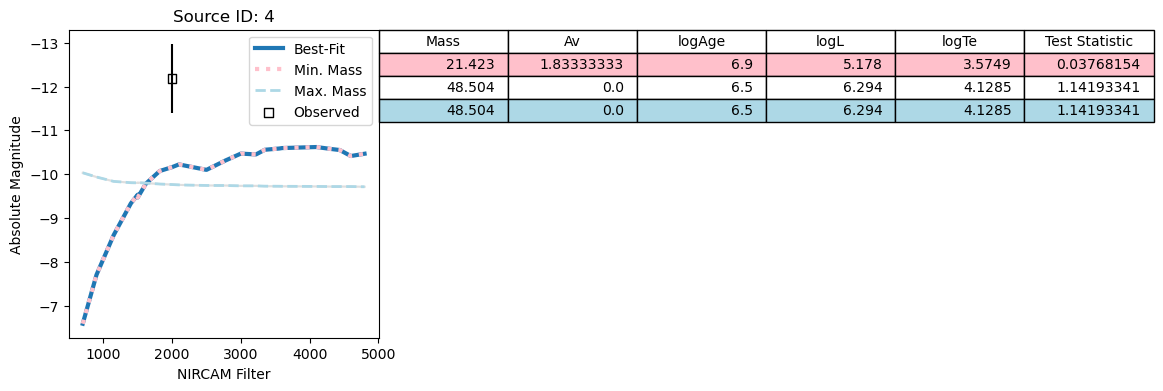

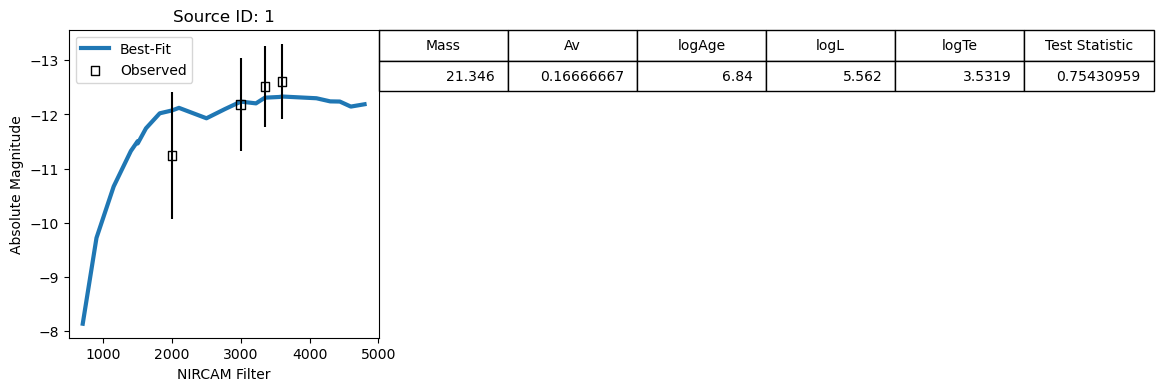

Zini       MH  logAge       Mini   int_IMF    Mass   logL   logTe  \
0   0.0152  0.01508    6.52  77.964279  2.633379  43.042  6.237  4.1122   
1   0.0152  0.01508    6.52  77.964279  2.633379  43.042  6.237  4.1122   
2   0.0152  0.01508    6.90  22.195520  2.631075  21.423  5.178  3.5749   
3   0.0152  0.01508    6.84  27.632059  2.631785  21.346  5.562  3.5319   
4   0.0152  0.01508    6.84  27.632059  2.631785  21.346  5.562  3.5319   
5   0.0152  0.01508    6.84  27.632059  2.631785  21.346  5.562  3.5319   
6   0.0152  0.01508    6.84  27.632059  2.631785  21.346  5.562  3.5319   
7   0.0152  0.01508    6.52  77.948517  2.633379  43.129  6.237  4.0885   
8   0.0152  0.01508    6.52  77.948517  2.633379  43.129  6.237  4.0885   
9   0.0152  0.01508    7.14  14.946802  2.629152  13.990  5.084  3.5266   
10  0.0152  0.01508    6.52  77.578400  2.633375  45.650  6.195  3.8318   
11  0.0152  0.01508    6.52  77.578400  2.633375  45.650  6.195  3.8318   
12  0.0152  0.01508    6.50  86.407707  2.633449  48.504  6.294  4.1285   
13  0.0152  0.01508    6.50  86.407707  2.633449  48.504  6.294  4.1285   

     logg label  ...     F3000M     F3350M     F3600M     F4100M     F4300M  \
0   1.236     1  ...  -9.710000  -9.702000  -9.699000  -9.697000  -9.695000   
1   1.236     1  ...  -9.710000  -9.702000  -9.699000  -9.697000  -9.695000   
2  -0.157     1  ... -10.469873 -10.557436 -10.595866 -10.619689 -10.577422   
3  -0.715     3  ... -12.058266 -12.144269 -12.173672 -12.155191 -12.102218   
4  -0.715     3  ... -12.236170 -12.308949 -12.330261 -12.298154 -12.240493   
5  -0.715     3  ... -12.287000 -12.356000 -12.375000 -12.339000 -12.280000   
6  -0.715     3  ... -12.287000 -12.356000 -12.375000 -12.339000 -12.280000   
7   1.142     1  ...  -9.887000  -9.880000  -9.878000  -9.876000  -9.874000   
8   1.142     1  ...  -9.887000  -9.880000  -9.878000  -9.876000  -9.874000   
9  -0.442     3  ... -10.585288 -10.699962 -10.745236 -10.741113 -10.685176   
10  0.182     1  ... -11.659000 -11.664000 -11.670000 -11.683000 -11.686000   
11  0.182     1  ... -11.659000 -11.664000 -11.670000 -11.683000 -11.686000   
12  1.296     1  ...  -9.734000  -9.727000  -9.724000  -9.721000  -9.718000   
13  1.296     1  ...  -9.734000  -9.727000  -9.724000  -9.721000  -9.718000   

       F4600M     F4800M        Av  Test Statistic  StarID  
0   -9.694000  -9.689000  0.000000        0.031875      15  
1   -9.694000  -9.689000  0.000000        0.031875      15  
2  -10.414462 -10.466629  1.833333        0.037682       4  
3  -12.012416 -12.059394  0.750000        0.628785      14  
4  -12.144315 -12.187421  0.166667        0.754310       1  
5  -12.182000 -12.224000  0.000000        1.029382       5  
6  -12.182000 -12.224000  0.000000        1.029382       5  
7   -9.874000  -9.869000  0.000000        1.511275       5  
8   -9.874000  -9.869000  0.000000        1.511275       5  
9  -10.610304 -10.665919  1.750000        3.646522      10  
10 -11.692000 -11.690000  0.000000        7.642318       9  
11 -11.692000 -11.690000  0.000000        7.642318       9  
12  -9.718000  -9.713000  0.000000        1.141933       4  
13  -9.718000  -9.713000  0.000000        1.141933       4  

[14 rows x 53 columns]

In [14]:
fitsed = FitSED(
    df=hmxb_photometry,
    instrument='nircam',
    idheader='StarID',
    min_models=1,
    plotSED=True,
    model_ext=True,
    # input_model='/Users/undergradstudent/Research/XRB-Analysis/jwst-models/isochrone-query-step-0_009.dat'
)
display(fitsed)

Now, I am creating a regions file with only the JWST best star sources

In [15]:
DaoCleanMatch = pd.read_csv(chandra_jwst_dir+"M66_daoclean_matches.frame")
M66_notes = pd.read_csv(chandra_jwst_dir+"M66_XRB_notes.txt")

# Extract photometry of sources
dist = 11.32e6 # units pc from https://iopscience.iop.org/article/10.3847/1538-4357/ace162/meta#apjace162s2
dmod = 5 * np.log10(dist) - 5

DaoCleanMatch = Find(DaoCleanMatch, 'CSC ID != 2CXO J112015.2+125932X')
DaoCleanPhots = GetDaoPhots(DaoCleanMatch,
                            photfiles=[jwstdir+'photometry_M66_f200w_nircam_sources.ecsv',
                                        jwstdir+'photometry_M66_f300m_nircam_sources.ecsv',
                                        jwstdir+'photometry_M66_f335m_nircam_sources.ecsv',
                                        jwstdir+'photometry_M66_f360m_nircam_sources.ecsv'],
                            idheads=['F200W ID', 'F300M ID', 'F335M ID', 'F360M ID'],
                            filters=['F200W', 'F300M', 'F335M', 'F360M'],
                            magheader='aperture_mag_corr',
                            dmod=dmod,
                            return_err=True)

Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f200w_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f300m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f335m_nircam_sources.ecsv
Searching /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/photometry_M66_f360m_nircam_sources.ecsv


# Quantifying the ejection rate of X-ray Binaries from star clusters

## Quick little SED fitting to extract masses and ages of best stars

In [20]:
M66_notes = remove_unnamed(pd.read_csv(chandra_jwst_dir+"M66_XRB_notes.txt"))
daoclean = remove_unnamed(pd.read_csv(chandra_jwst_dir+'M66_daoclean_matches.frame'))
# Remove the unwanted source
daoclean = daoclean.query('`CSC ID` != "2CXO J112015.2+125932X"').reset_index(drop=True)

In [21]:
dist = 11.32e6 # units pc from https://iopscience.iop.org/article/10.3847/1538-4357/ace162/meta#apjace162s2
dmod = 5 * np.log10(dist) - 5
cd(jwstdir)
photometry = GetDaoPhots(daoclean, 
                        photfiles=['photometry_M66_f200w_nircam_sources.ecsv',
                                    'photometry_M66_f300m_nircam_sources.ecsv',
                                    'photometry_M66_f335m_nircam_sources.ecsv',
                                    'photometry_M66_f360m_nircam_sources.ecsv'],
                        idheads=['F200W ID', 'F300M ID', 'F335M ID', 'F360M ID'],
                        filters=['F200W', 'F300M', 'F335M', 'F360M'],
                        magheader='aperture_mag_corr', dmod=dmod)
photometry['Star ID'] = daoclean['StarID']
photometry['ID'] = photometry['CSC ID'] + '-' + photometry['Star ID'].astype(str)
photometry
display(photometry) 

Searching photometry_M66_f200w_nircam_sources.ecsv
Searching photometry_M66_f300m_nircam_sources.ecsv
Searching photometry_M66_f335m_nircam_sources.ecsv
Searching photometry_M66_f360m_nircam_sources.ecsv


RA        Dec  F200W ID  F300M ID  F335M ID  F360M ID  \
0    170.062403  12.991447    186126   43256.0   39563.0       NaN   
1    170.062377  12.991509    186591   43256.0       NaN   45349.0   
2    170.062861  12.991270    184798   42915.0   39221.0   44861.0   
3    170.062923  12.991314    185199   42999.0   39292.0   44947.0   
4    170.062862  12.991339    185366   43115.0   39406.0   45067.0   
..          ...        ...       ...       ...       ...       ...   
530  170.054172  12.960079     26276       NaN       NaN       NaN   
531  170.054284  12.960093     26305       NaN       NaN       NaN   
532  170.054191  12.960178     26519    6497.0    5610.0    6873.0   
533  170.054263  12.960223     26624       NaN    5634.0    6902.0   
534  170.066405  12.957754     20630       NaN       NaN       NaN   

               X            Y                 CSC ID  StarID      F200W  \
0    3095.278143  5769.996064  2CXO J112014.9+125929       1 -15.581557   
1    3098.298769  5777.274662  2CXO J112014.9+125929       2 -15.493773   
2    3043.030225  5749.281319  2CXO J112015.0+125928       1 -14.530440   
3    3035.930921  5754.396561  2CXO J112015.0+125928       2 -14.189699   
4    3042.938275  5757.419244  2CXO J112015.0+125928       3 -14.674885   
..           ...          ...                    ...     ...        ...   
530  4034.543404  2097.590954  2CXO J112013.0+125736       2  -8.972132   
531  4021.687783  2099.179560  2CXO J112013.0+125736       3  -8.635646   
532  4032.312552  2109.128343  2CXO J112013.0+125736       4 -10.063433   
533  4024.074667  2114.406991  2CXO J112013.0+125736       5  -7.439429   
534  2638.804107  1825.304918  2CXO J112015.9+125727       1  -9.512625   

     F200W Err      F300M  F300M Err      F335M  F335M Err      F360M  \
0    -0.104048 -16.612522  -0.029836 -17.033562  -0.023996        NaN   
1    -0.112812 -16.612522  -0.029836        NaN        NaN -16.792172   
2    -0.219898 -15.761625  -0.065325 -15.992875  -0.062570 -15.958139   
3    -0.296408 -15.434368  -0.088302 -15.700718  -0.081888 -15.684414   
4    -0.200001 -15.894534  -0.057798 -16.214079  -0.051037 -16.206706   
..         ...        ...        ...        ...        ...        ...   
530  -0.421119        NaN        NaN        NaN        NaN        NaN   
531  -0.574976        NaN        NaN        NaN        NaN        NaN   
532  -0.154548  -9.273787  -0.743486  -9.818036  -0.670797  -9.812694   
533  -1.736334        NaN        NaN  -9.358539  -1.022644  -9.657184   
534  -0.158024        NaN        NaN        NaN        NaN        NaN   

     F360M Err  Star ID                       ID  
0          NaN        1  2CXO J112014.9+125929-1  
1    -0.029958        2  2CXO J112014.9+125929-2  
2    -0.064580        1  2CXO J112015.0+125928-1  
3    -0.083097        2  2CXO J112015.0+125928-2  
4    -0.051366        3  2CXO J112015.0+125928-3  
..         ...      ...                      ...  
530        NaN        2  2CXO J112013.0+125736-2  
531        NaN        3  2CXO J112013.0+125736-3  
532  -0.606542        4  2CXO J112013.0+125736-4  
533  -0.700647        5  2CXO J112013.0+125736-5  
534        NaN        1  2CXO J112015.9+125727-1  

[535 rows x 20 columns]

In [22]:
photometry.to_csv(chandra_jwst_dir+"M66_daoclean_matches_photometry.csv")

In [23]:
columns = {
    'F200W': 'F2000W',
    'F200W Err': 'F2000W Err',
    'F300M': 'F3000M',
    'F300M Err': 'F3000M Err',
    'F335M': 'F3350M',
    'F335M Err': 'F3350M Err',
    'F360M': 'F3600M',
    'F360M Err': 'F3600M Err',
}
photometry = photometry.rename(columns=columns)

In [24]:
photometry

RA        Dec  F200W ID  F300M ID  F335M ID  F360M ID  \
0    170.062403  12.991447    186126   43256.0   39563.0       NaN   
1    170.062377  12.991509    186591   43256.0       NaN   45349.0   
2    170.062861  12.991270    184798   42915.0   39221.0   44861.0   
3    170.062923  12.991314    185199   42999.0   39292.0   44947.0   
4    170.062862  12.991339    185366   43115.0   39406.0   45067.0   
..          ...        ...       ...       ...       ...       ...   
530  170.054172  12.960079     26276       NaN       NaN       NaN   
531  170.054284  12.960093     26305       NaN       NaN       NaN   
532  170.054191  12.960178     26519    6497.0    5610.0    6873.0   
533  170.054263  12.960223     26624       NaN    5634.0    6902.0   
534  170.066405  12.957754     20630       NaN       NaN       NaN   

               X            Y                 CSC ID  StarID     F2000W  \
0    3095.278143  5769.996064  2CXO J112014.9+125929       1 -15.581557   
1    3098.298769  5777.274662  2CXO J112014.9+125929       2 -15.493773   
2    3043.030225  5749.281319  2CXO J112015.0+125928       1 -14.530440   
3    3035.930921  5754.396561  2CXO J112015.0+125928       2 -14.189699   
4    3042.938275  5757.419244  2CXO J112015.0+125928       3 -14.674885   
..           ...          ...                    ...     ...        ...   
530  4034.543404  2097.590954  2CXO J112013.0+125736       2  -8.972132   
531  4021.687783  2099.179560  2CXO J112013.0+125736       3  -8.635646   
532  4032.312552  2109.128343  2CXO J112013.0+125736       4 -10.063433   
533  4024.074667  2114.406991  2CXO J112013.0+125736       5  -7.439429   
534  2638.804107  1825.304918  2CXO J112015.9+125727       1  -9.512625   

     F2000W Err     F3000M  F3000M Err     F3350M  F3350M Err     F3600M  \
0     -0.104048 -16.612522   -0.029836 -17.033562   -0.023996        NaN   
1     -0.112812 -16.612522   -0.029836        NaN         NaN -16.792172   
2     -0.219898 -15.761625   -0.065325 -15.992875   -0.062570 -15.958139   
3     -0.296408 -15.434368   -0.088302 -15.700718   -0.081888 -15.684414   
4     -0.200001 -15.894534   -0.057798 -16.214079   -0.051037 -16.206706   
..          ...        ...         ...        ...         ...        ...   
530   -0.421119        NaN         NaN        NaN         NaN        NaN   
531   -0.574976        NaN         NaN        NaN         NaN        NaN   
532   -0.154548  -9.273787   -0.743486  -9.818036   -0.670797  -9.812694   
533   -1.736334        NaN         NaN  -9.358539   -1.022644  -9.657184   
534   -0.158024        NaN         NaN        NaN         NaN        NaN   

     F3600M Err  Star ID                       ID  
0           NaN        1  2CXO J112014.9+125929-1  
1     -0.029958        2  2CXO J112014.9+125929-2  
2     -0.064580        1  2CXO J112015.0+125928-1  
3     -0.083097        2  2CXO J112015.0+125928-2  
4     -0.051366        3  2CXO J112015.0+125928-3  
..          ...      ...                      ...  
530         NaN        2  2CXO J112013.0+125736-2  
531         NaN        3  2CXO J112013.0+125736-3  
532   -0.606542        4  2CXO J112013.0+125736-4  
533   -0.700647        5  2CXO J112013.0+125736-5  
534         NaN        1  2CXO J112015.9+125727-1  

[535 rows x 20 columns]

In [25]:
best_fit = FitSED(
    df=photometry,
    idheader='ID',
    min_models=1,
    instrument='nircam',
    plotSED=False,
    model_ext=False
)
best_fit.to_csv(chandra_jwst_dir+"M66_daoclean_matches_sed_fitting.csv")

Finding best-fit model(s)...
DONE


## Merging dataframes

In [26]:
M66_notes = M66_notes.rename(columns={'ID' : "Auxiliary ID"})
M66_notes['ID'] = M66_notes['CSC ID'] + '-' + M66_notes['Best Star'].astype(str)
M66_notes = M66_notes.query('Class == "HMXB" or Class == "LMXB"')
M66_notes = M66_notes[['CSC ID', 'ID', 'Class', 'Best Star']]
temp = photometry[['RA', 'Dec', 'ID']]
M66_xrbs = M66_notes.merge(temp, on='ID', how='left')

# Adding Star ages and masses to the main dataframe
best_fit['Age'] = 10 ** best_fit['logAge'].values
temp = best_fit[['ID', 'Age', 'Mass']]
M66_xrbs = M66_xrbs.merge(temp, on='ID', how='left')

# Adding the 2 Sig positional uncertainty
M66_best = remove_unnamed(pd.read_csv(chandra_jwst_dir+'M66_csc_bestrads.frame'))
temp = M66_best[['CSC ID', '2Sig']]
M66_xrbs = M66_xrbs.merge(temp, on='CSC ID', how='left')

import astropy.units as u
# Converting the 2 sig from arcsecs to km 
M66_xrbs['2 Sig (pc)'] = M66_xrbs['2Sig'].values * 45.4 # pc
M66_xrbs['2 Sig (km)'] = (M66_xrbs['2 Sig (pc)'].values * u.pc.to(u.km))

M66_xrbs.to_csv(chandra_jwst_dir+"M66_XRBs_quantifying_ejection_rates.txt")

## Calculating Distances and Velocities

In [27]:
# Importing the phangs cluster catalog from https://archive.stsci.edu/hlsp/phangs/phangs-cat
clustercat = remove_unnamed(pd.read_csv(M66_dir+"ngc3627_cluster_catalog/M66_phangs_wfc3_cluster_catalog.frame"))

In [28]:
# Change column names to usable names
columns = {
    'ID_PHANGS_CLUSTERS'       : 'Cluster ID',
    'PHANGS_AGE_MINCHISQ'      : 'Cluster Age (Myr)',
    'PHANGS_AGE_MINCHISQ_ERR'  : 'Cluster Age Err (Myr)',
    'PHANGS_MASS_MINCHISQ'     : 'Cluster Mass (M_sun)',
    'PHANGS_MASS_MINCHISQ_ERR' : 'Cluster Mass Err (M_sun)',
    'PHANGS_EBV_MINCHISQ'      : 'Cluster Extinction',
    'PHANGS_EBV_MINCHISQ_ERR'  : 'Cluster Extinction Err',
    'PHANGS_REDUCED_MINCHISQ'  : 'Cluster MinChiSqd'
}
# Only include the columns that I will be using in the dataframe
clustercat = clustercat.rename(columns=columns, inplace=False)
clustercat = clustercat[['Cluster ID', 'Cluster Age (Myr)',
                         'Cluster Age Err (Myr)', 'Cluster Mass (M_sun)',
                         'Cluster Mass Err (M_sun)', 'Cluster Extinction',
                         'Cluster Extinction Err', 'Cluster MinChiSqd']]

In [29]:
search_radius = 1000 / (3600 * 45.4)
print(f'Using search radius: {search_radius}')

Using search radius: 0.006118453255017132


In [30]:
distances = calculate_distance(
    df=M66_xrbs,
    regions=[M66_dir+'ngc3627_cluster_catalog/M66_phangs_cluster_catalog_wfc3_fk5.reg'],
    catalogs=['Cluster'],
    search_radius=search_radius,
    imagefilename=f200w,
    instrument='nircams',
    coordsys='fk5',
    coordheads=['RA', 'Dec']
)

distances

Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


RA        Dec                 CSC ID Cluster ID  \
0     170.062255  12.992622  2CXO J112014.9+125933       6740   
1     170.062255  12.992622  2CXO J112014.9+125933       6788   
2     170.062255  12.992622  2CXO J112014.9+125933       6969   
3     170.062255  12.992622  2CXO J112014.9+125933       7009   
4     170.062255  12.992622  2CXO J112014.9+125933       7020   
...          ...        ...                    ...        ...   
1629  170.066405  12.957754  2CXO J112015.9+125727        955   
1630  170.066405  12.957754  2CXO J112015.9+125727        977   
1631  170.066405  12.957754  2CXO J112015.9+125727       1081   
1632  170.066405  12.957754  2CXO J112015.9+125727       1126   
1633  170.066405  12.957754  2CXO J112015.9+125727       1269   

                           ID Class Best Star  Age Mass      2Sig 2 Sig (pc)  \
0     2CXO J112014.9+125933-4  HMXB         4  nan  nan  0.235415  10.687848   
1     2CXO J112014.9+125933-4  HMXB         4  nan  nan  0.235415  10.687848   
2     2CXO J112014.9+125933-4  HMXB         4  nan  nan  0.235415  10.687848   
3     2CXO J112014.9+125933-4  HMXB         4  nan  nan  0.235415  10.687848   
4     2CXO J112014.9+125933-4  HMXB         4  nan  nan  0.235415  10.687848   
...                       ...   ...       ...  ...  ...       ...        ...   
1629  2CXO J112015.9+125727-1  HMXB         1  nan  nan  0.344518  15.641119   
1630  2CXO J112015.9+125727-1  HMXB         1  nan  nan  0.344518  15.641119   
1631  2CXO J112015.9+125727-1  HMXB         1  nan  nan  0.344518  15.641119   
1632  2CXO J112015.9+125727-1  HMXB         1  nan  nan  0.344518  15.641119   
1633  2CXO J112015.9+125727-1  HMXB         1  nan  nan  0.344518  15.641119   

                2 Sig (km)  Cluster RA  Cluster Dec  \
0     329792523495880.9375  170.061854    12.987710   
1     329792523495880.9375  170.061841    12.987972   
2     329792523495880.9375  170.058295    12.988915   
3     329792523495880.9375  170.057686    12.989116   
4     329792523495880.9375  170.058562    12.989207   
...                    ...         ...          ...   
1629   482634502291683.875  170.066643    12.958279   
1630   482634502291683.875  170.066755    12.958495   
1631   482634502291683.875  170.064060    12.959637   
1632   482634502291683.875  170.064792    12.960144   
1633   482634502291683.875  170.065566    12.962296   

      Cluster Separation (arcsecs)  Cluster Separation (pc)  \
0                        17.886058               813.815649   
1                        16.939269               770.736762   
2                        19.422395               883.718957   
3                        20.569985               935.934308   
4                        18.007040               819.320313   
...                            ...                      ...   
1629                      2.085350                94.883425   
1630                      2.961195               134.734377   
1631                     10.747639               489.017595   
1632                     10.384508               472.495125   
1633                     16.751577               762.196765   

      Cluster Separation (km)  
0                2.511173e+16  
1                2.378245e+16  
2                2.726872e+16  
3                2.887992e+16  
4                2.528158e+16  
...                       ...  
1629             2.927797e+15  
1630             4.157468e+15  
1631             1.508951e+16  
1632             1.457968e+16  
1633             2.351893e+16  

[1634 rows x 17 columns]

In [36]:
# Convert cluster ages from Myr to s
ages_Myr, ages_err_Myr = distances['Cluster Age (Myr)'].values * u.Myr, distances['Cluster Age Err (Myr)'].values * u.Myr
ages_s, ages_err_s = ages_Myr.to(u.s), ages_err_Myr.to(u.s)
# save to distances df
distances['Cluster Age (s)'] = ages_s.value
distances['Cluster Age Err (s)'] = ages_err_s.value


In [ ]:
velocity = calculate_velocity(
    df=distances,
    catalog='Cluster',
    coordheads=['Cluster Separation (km)', 'Cluster Age (s)'],
    errorheads=['2 Sig (km)', 'Cluster Age Err (s)'],
    shorten_df=False,
)

velocity

Make sure that the distances and ages are in km and seconds respectively...


RA        Dec                 CSC ID Cluster ID  \
0     170.062255  12.992622  2CXO J112014.9+125933       6740   
1     170.062255  12.992622  2CXO J112014.9+125933       6788   
2     170.062255  12.992622  2CXO J112014.9+125933       6969   
3     170.062255  12.992622  2CXO J112014.9+125933       7009   
4     170.062255  12.992622  2CXO J112014.9+125933       7020   
...          ...        ...                    ...        ...   
1629  170.066405  12.957754  2CXO J112015.9+125727        955   
1630  170.066405  12.957754  2CXO J112015.9+125727        977   
1631  170.066405  12.957754  2CXO J112015.9+125727       1081   
1632  170.066405  12.957754  2CXO J112015.9+125727       1126   
1633  170.066405  12.957754  2CXO J112015.9+125727       1269   

                           ID Class Best Star  Age Mass      2Sig  ...  \
0     2CXO J112014.9+125933-4  HMXB         4  nan  nan  0.235415  ...   
1     2CXO J112014.9+125933-4  HMXB         4  nan  nan  0.235415  ...   
2     2CXO J112014.9+125933-4  HMXB         4  nan  nan  0.235415  ...   
3     2CXO J112014.9+125933-4  HMXB         4  nan  nan  0.235415  ...   
4     2CXO J112014.9+125933-4  HMXB         4  nan  nan  0.235415  ...   
...                       ...   ...       ...  ...  ...       ...  ...   
1629  2CXO J112015.9+125727-1  HMXB         1  nan  nan  0.344518  ...   
1630  2CXO J112015.9+125727-1  HMXB         1  nan  nan  0.344518  ...   
1631  2CXO J112015.9+125727-1  HMXB         1  nan  nan  0.344518  ...   
1632  2CXO J112015.9+125727-1  HMXB         1  nan  nan  0.344518  ...   
1633  2CXO J112015.9+125727-1  HMXB         1  nan  nan  0.344518  ...   

     Cluster Age Err (Myr) Cluster Mass (M_sun)  Cluster Mass Err (M_sun)  \
0                    153.0         32159.451166              67739.414328   
1                    120.0        174363.656114              17070.864641   
2                     77.0         69972.213290              11389.178992   
3                     48.0        206060.938059              14694.145980   
4                     34.0         43030.350062                573.446002   
...                    ...                  ...                       ...   
1629                   0.0          3392.611769                409.826212   
1630                   0.0         21144.495487               3117.465232   
1631                 144.0        142368.052732              10776.308747   
1632                   0.0          5177.537284                407.456920   
1633                  38.0         22519.544513                689.461192   

      Cluster Extinction  Cluster Extinction Err  Cluster MinChiSqd  \
0                   0.80                    0.50          23.386633   
1                   0.00                    0.01           3.086535   
2                   0.10                    0.09           1.464285   
3                   0.01                    0.09           0.208602   
4                   0.26                    0.07           0.680461   
...                  ...                     ...                ...   
1629                0.12                    0.03           0.307157   
1630                0.18                    0.04           3.213938   
1631                0.04                    0.05           0.253677   
1632                0.01                    0.02           0.881166   
1633                0.00                    0.04           2.923908   

      Cluster Age (s)  Cluster Age Err (s)  Cluster Velocity (km/s)  \
0        1.577880e+14         4.828313e+15               159.148522   
1        2.808626e+16         3.786912e+15                 0.846765   
2        1.577880e+16         2.429935e+15                 1.728187   
3        4.986101e+15         1.514765e+15                 5.792084   
4        3.471336e+15         1.072958e+15                 7.282955   
...               ...                  ...                      ...   
1629     1.262304e+14         0.000000e+00                23.194069  

In [44]:
cols = ['RA', 'Dec', 'CSC ID', 'Cluster ID', 'ID', 'Class', 'Best Star',
       'Age', 'Mass', '2Sig', '2 Sig (pc)', '2 Sig (km)', 'Cluster RA',
       'Cluster Dec', 'Cluster Age (Myr)', 'Cluster Age Err (Myr)',
       'Cluster Mass (M_sun)', 'Cluster Mass Err (M_sun)',
       'Cluster Extinction', 'Cluster Extinction Err',
       'Cluster MinChiSqd', 'Cluster Age (s)', 'Cluster Age Err (s)',
       'Cluster Separation (arcsecs)',
       'Cluster Separation (pc)', 'Cluster Separation (km)',
       'Cluster Velocity (km/s)', 'Cluster Velocity Err (km/s)']

velocity = velocity[cols]

In [46]:
v = (np.round(velocity['Cluster Velocity (km/s)'].values, decimals=2).astype(str) + ' km/s').tolist()
print(v)
from helpers.regions import WriteReg
WriteReg(
    sources=velocity,
    outfile=chandra_jwst_dir+'M66_XRBs_quantifying_xrb_ejection.reg',
    coordsys='fk5',
    coordheads=['RA', 'Dec'],
    additional_coords=['Cluster RA', 'Cluster Dec'],
    reg_type='ruler',
    label=v,
    radunit='degrees',
)

['159.15 km/s', '0.85 km/s', '1.73 km/s', '5.79 km/s', '7.28 km/s', '12.18 km/s', '3.0 km/s', '1.19 km/s', '0.25 km/s', '4.7 km/s', '3.27 km/s', '0.34 km/s', '6.09 km/s', '0.8 km/s', '3.41 km/s', '0.11 km/s', '3.54 km/s', '3.07 km/s', '0.82 km/s', '0.04 km/s', '169.29 km/s', '0.98 km/s', '1.11 km/s', '2.58 km/s', '3.35 km/s', '0.99 km/s', '138.05 km/s', '4.88 km/s', '3.26 km/s', '3.19 km/s', '5.35 km/s', '295.81 km/s', '160.63 km/s', '0.86 km/s', '10.93 km/s', '8.56 km/s', '7.0 km/s', '3.85 km/s', '30.32 km/s', '31.71 km/s', '1.49 km/s', '4.03 km/s', '101.41 km/s', '102.85 km/s', '1.63 km/s', '0.14 km/s', '4.76 km/s', '0.37 km/s', '4.23 km/s', '0.21 km/s', '1.8 km/s', '3.47 km/s', '114.22 km/s', '1.64 km/s', '27.63 km/s', '1.29 km/s', '0.16 km/s', '1.48 km/s', '22.92 km/s', '9.7 km/s', '28.53 km/s', '3.01 km/s', '109.39 km/s', '48.35 km/s', '117.29 km/s', '4.6 km/s', '2.84 km/s', '185.35 km/s', '0.99 km/s', '8.59 km/s', '12.95 km/s', '2.08 km/s', '3.67 km/s', '1.47 km/s', '0.26 km/s', 

## Distance and velocity KDEs and histogram plots

Maximum distance: 1009.9690666625593 pc
Minimum distance: 35.302546985172846 pc


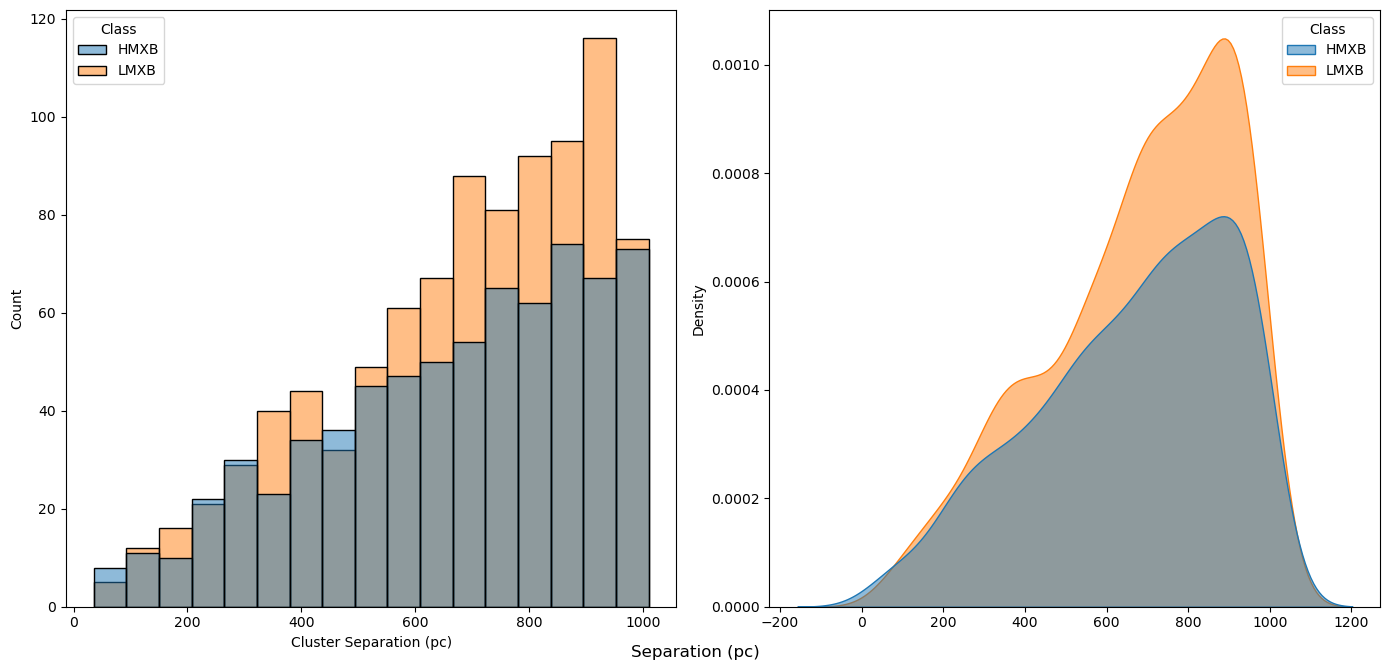

In [47]:
print(f'Maximum distance: {max(distances['Cluster Separation (pc)'])} pc')
print(f'Minimum distance: {min(distances['Cluster Separation (pc)'])} pc')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.histplot(
    data=velocity,
    x='Cluster Separation (pc)',
    hue='Class',
    legend=True,
    # kind='hist',
    # palette='pastel',
    alpha=0.5,
    ax=ax[0]
)
# ax[0].set(xlabel=None)

sns.kdeplot(
    data=velocity,
    x='Cluster Separation (pc)',
    fill=True, 
    ax=ax[1], 
    alpha=0.5,
    hue='Class',
    # palette='pastel'
)
ax[1].set(xlabel=None)

# ax[1].hist(x=velocity['Cluster Separation (pc)'].values, bins=30)
# ax[1].set_ylabel('Counts')

fig.supxlabel("Separation (pc)", x=0.5, y=0.05)
plt.tight_layout()
plt.show()


Maximum velocity: 971.7886276576179 km/s
Minimum velocity: 0.03820388967538953 km/s


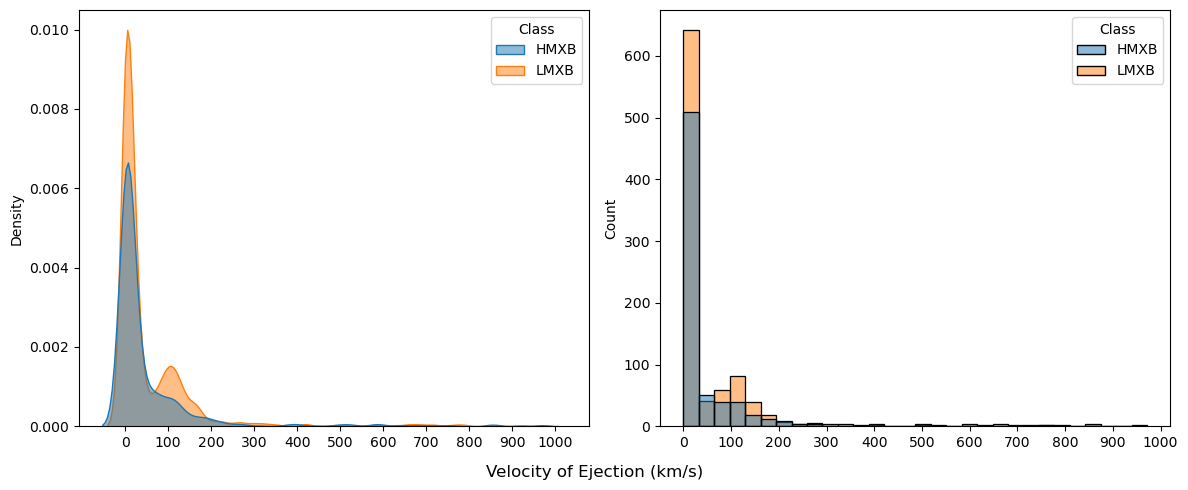

In [50]:
print(f'Maximum velocity: {max(velocity['Cluster Velocity (km/s)'])} km/s')
print(f'Minimum velocity: {min(velocity['Cluster Velocity (km/s)'])} km/s')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.kdeplot(
    data=velocity, 
    x='Cluster Velocity (km/s)',
    hue='Class',
    bw_adjust=0.5,
    fill=True,
    ax=ax[0],
    alpha=0.5
)
ax[0].set(xlabel=None)
ax[0].set_xticks([i * 100 for i in range(0, 11)])

sns.histplot(
    data=velocity,
    x='Cluster Velocity (km/s)',
    hue='Class',
    bins=30,
    ax=ax[1], 
    alpha=0.5
)
ax[1].set_xticks([i * 100 for i in range(0, 11)])
ax[1].set(xlabel=None)
fig.supxlabel("Velocity of Ejection (km/s)", x=0.5, y=0.03)
plt.tight_layout()
plt.show()